# **TSC of Cryptocurrency Price Trend Based on OS-CNN**
**Time Series Classification of Cryptocurrency Price Trend Based on Omni Scale-Convolutional neural networks**

  วัตถุประสงค์ของ Project นี้คือเพื่อทำนายแนวโน้มในอนาคตของอนุกรมเวลาของสกุลเงินดิจิทัล (Cryptocurrency) และระบบการชำระเงินแลกเปลี่ยนกันโดยใช้สกุลเงินดิจิทัลทั่วโลกที่สร้างขึ้นในปี 2552
Project นี้ใช้ชุดข้อมูลที่ได้รับจาก Binance API
โดยเฉพาะอย่างยิ่ง โดยมีขั้นตอนดังนี้  
1. Data Preparation
2. Define Model
3. Compile
4. Fit(Train)
5. Save
6. Load
7. Prediction
8. Evaluation

# **1.Load Data**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as py
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import math
import time
from statistics import mean
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, f1_score, precision_score, recall_score, roc_auc_score, classification_report

from random import sample
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict 
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# get code from github
!git clone https://github.com/Wensi-Tang/OS-CNN.git

#change path to OS-CNN
%cd /content/OS-CNN

Cloning into 'OS-CNN'...
remote: Enumerating objects: 578, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 578 (delta 4), reused 5 (delta 0), pack-reused 564
Receiving objects: 100% (578/578), 49.43 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/OS-CNN


In [ ]:
# Library for run OS-CNN
import os
from os.path import dirname
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN
from Classifiers.OS_CNN.OS_CNN_easy_use import OS_CNN_easy_use

from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader
from utils.dataloader.TSC_data_loader import TSC_data_loader                         # .tsv
from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader_from_mat   # .mat
from Classifiers.OS_CNN.OS_CNN_easy_use import OS_CNN_easy_use

In [ ]:
# TPU
# import tensorflow as tf
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# GPU
print("Are we using GPU?: ", torch.cuda.is_available())
print("the GPU name is: ",torch.cuda.get_device_name(0))

Are we using GPU?:  True
the GPU name is:  Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# # For loop load data every files 

# path = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/MOVEMENT1minETH_No.'

# data = []

# for i in range(1,7):
#     file_path = path + str(i) + '.csv'
#     print(file_path)
#     df = pd.read_csv(file_path, header=0)

#     df = df.drop([ 
#                   # 'unix',
#                   'date' 
#                   # 'open', 'high', 'low',
#                   # 'diff_class',  'percentdiff_class', 'Volume eth'
#                   ,'Volume USD'
#                   ], axis=1)    
#     # df['unix'] = df['unix'].apply(lambda x: pd.to_datetime(x, unit='s'))   #change format to datetime

#     data.append(df)

# # see pd.concat documentation for more info
# data = pd.concat(data, ignore_index=True)

# path1 = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_min.csv'
# with open(path1, 'w', encoding = 'utf-8-sig') as f:
#   data.to_csv(f)

In [ ]:
# Load data after for loop
# data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_min.csv')
data = pd.read_csv('/content/gdrive/MyDrive/ETH_min.csv')
data.head()

,Unnamed: 0,unix,open,high,low,close,Volume ETH
0,0,1647863040,2909.78,2909.93,2909.32,2909.32,0.277616
1,1,1647862980,2909.68,2909.68,2909.68,2909.68,3.000000
2,2,1647862920,2909.18,2910.55,2908.48,2909.36,16.362937
3,3,1647862860,2909.91,2910.70,2909.91,2910.70,0.460375
4,4,1647862800,2909.49,2909.68,2909.49,2909.68,0.551272


In [ ]:
data.tail()

,Unnamed: 0,unix,open,high,low,close,Volume ETH
2416015,2416015,1502902140,300.0,300.0,300.0,300.0,0.00
2416016,2416016,1502902080,300.0,300.0,300.0,300.0,0.00
2416017,2416017,1502902020,300.0,300.0,300.0,300.0,0.00
2416018,2416018,1502901960,300.0,300.0,300.0,300.0,0.00
2416019,2416019,1502901900,300.0,300.0,300.0,300.0,0.02


In [ ]:
data.shape

(2416020, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416020 entries, 0 to 2416019
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   unix        int64  
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   Volume ETH  float64
dtypes: float64(5), int64(2)
memory usage: 129.0 MB


In [ ]:
data.describe()

,Unnamed: 0,unix,open,high,low,close,Volume ETH
count,2.416020e+06,2.416020e+06,2.416020e+06,2.416020e+06,2.416020e+06,2.416020e+06,2.416020e+06
mean,1.208010e+06,1.575382e+09,9.829581e+02,9.834726e+02,9.824166e+02,9.829517e+02,3.111010e+01
std,6.974450e+05,4.184670e+07,1.206617e+03,1.207177e+03,1.206029e+03,1.206604e+03,1.096823e+02
min,0.000000e+00,1.502902e+09,8.105000e+01,8.109000e+01,8.090000e+01,8.109000e+01,0.000000e+00
25%,6.040048e+05,1.539142e+09,1.996000e+02,1.996500e+02,1.995500e+02,1.996100e+02,0.000000e+00
50%,1.208010e+06,1.575382e+09,3.626500e+02,3.628000e+02,3.624900e+02,3.626600e+02,3.722385e+00
75%,1.812014e+06,1.611623e+09,1.337410e+03,1.338650e+03,1.336000e+03,1.337393e+03,2.277585e+01
max,2.416019e+06,1.647863e+09,4.866450e+03,4.868790e+03,4.864100e+03,4.867960e+03,1.249174e+04


In [ ]:
print(data.isnull().sum())

Unnamed: 0    0
unix          0
open          0
high          0
low           0
close         0
Volume ETH    0
dtype: int64


In [ ]:
# Change format timestamp to datetime
data['unix'] = data['unix'].apply(lambda x: pd.to_datetime(x, unit='s')) 
eth_usd = data.copy().drop(['Unnamed: 0'], axis=1)
eth_usd.head()

,unix,open,high,low,close,Volume ETH
0,2022-03-21 11:44:00,2909.78,2909.93,2909.32,2909.32,0.277616
1,2022-03-21 11:43:00,2909.68,2909.68,2909.68,2909.68,3.000000
2,2022-03-21 11:42:00,2909.18,2910.55,2908.48,2909.36,16.362937
3,2022-03-21 11:41:00,2909.91,2910.70,2909.91,2910.70,0.460375
4,2022-03-21 11:40:00,2909.49,2909.68,2909.49,2909.68,0.551272


In [ ]:
# Defind Dataframe datetime and close column descending order
eth_close = eth_usd.drop(['open', 'high', 'low', 'Volume ETH'], axis=1).set_index('unix')
eth_close.head()

,close
unix,
2022-03-21 11:44:00,2909.32
2022-03-21 11:43:00,2909.68
2022-03-21 11:42:00,2909.36
2022-03-21 11:41:00,2910.70
2022-03-21 11:40:00,2909.68


In [ ]:
# Defind Dataframe datetime and close column ascending order
eth_closes = eth_usd.drop(['open', 'high', 'low', 'Volume ETH'], axis=1).sort_values(by = 'unix').set_index('unix')
print(eth_closes.head())
print(eth_closes.tail())
print(eth_closes.shape)

                     close
unix                      
2017-08-16 16:45:00  300.0
2017-08-16 16:46:00  300.0
2017-08-16 16:47:00  300.0
2017-08-16 16:48:00  300.0
2017-08-16 16:49:00  300.0
                       close
unix                        
2022-03-21 11:40:00  2909.68
2022-03-21 11:41:00  2910.70
2022-03-21 11:42:00  2909.36
2022-03-21 11:43:00  2909.68
2022-03-21 11:44:00  2909.32
(2416020, 1)


## **Exploratory Data Analysis (EDA)**
Exploratory Data Analysis (EDA) ทำความเข้าใจว่าข้อมูลว่ามีปัญหาคืออะไร ทำไม และอย่างไร เป็นลำดับแรกในลำดับของการดำเนินการที่นักวิเคราะห์ข้อมูลจะดำเนินการเมื่อส่งแหล่งข้อมูลใหม่และคำชี้แจงปัญหา
การวิเคราะห์ข้อมูลเชิงสำรวจเป็นแนวทางในการวิเคราะห์ชุดข้อมูล Cryptocurency โดยการสรุปลักษณะเฉพาะหลักด้วยการแสดงภาพกระบวนการ EDA เป็นขั้นตอนสำคัญก่อนที่จะสร้างแบบจำลองเพื่อเปิดเผยข้อมูลเชิงลึกต่างๆ ที่มีความสำคัญต่อการพัฒนาแบบจำลองอัลกอริทึมที่มีประสิทธิภาพในภายหลัง

วัตถุประสงค์หลักคือการครอบคลุมวิธีการ:

- อ่านและตรวจสอบชุดข้อมูลและจำแนกตัวแปรตามประเภท: quantitative vs. categorical
- จัดการตัวแปร categorical ด้วยค่ารหัสตัวเลข
- ทำ univariate and bivariate analysis และรับข้อมูลเชิงลึกที่มีความหมายเกี่ยวกับชุดข้อมูล
- ระบุและจัดการกับค่าที่หายไปและลบค่าผิดปกติของชุดข้อมูล
- สร้าง Correlation matrix เพื่อระบุตัวแปรที่เกี่ยวข้อง

**Feature Engineering**  
Feature Engineering หรือที่เรียกว่า "Feature creation" เป็นกระบวนการสร้างคุณลักษณะใหม่จากข้อมูลที่มีอยู่เพื่อฝึกโมเดลการเรียนรู้ของเครื่อง โดยทั่วไปวิศวกรรมคุณลักษณะเป็นกระบวนการแบบแมนนวลที่ดึงออกมาโดยอาศัย domain knowledge, intuition, and data manipulation.Automated feature engineering มุ่งหวังที่จะช่วยเหลือนักวิทยาศาสตร์ข้อมูลโดยการสร้างคุณสมบัติผู้สมัครจำนวนมากโดยอัตโนมัติจากชุดข้อมูลซึ่งสิ่งที่ดีที่สุดสามารถเลือกและใช้สำหรับการฝึกอบรม

Feature engineering มีเป้าหมายสองประการ:

- การเตรียมชุดข้อมูลอินพุตที่เหมาะสม เข้ากันได้กับข้อกำหนดอัลกอริธึมการเรียนรู้ของเครื่อง
- การปรับปรุงประสิทธิภาพของโมเดลการเรียนรู้ของเครื่อง

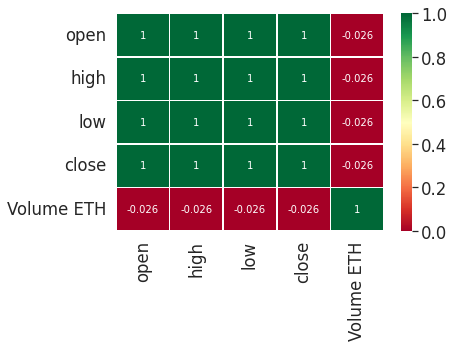

In [ ]:
# correlation matrix
sns.heatmap(eth_usd.corr(), annot=True, cmap='RdYlGn', linewidths=0.5, vmin=0)
plt.show()

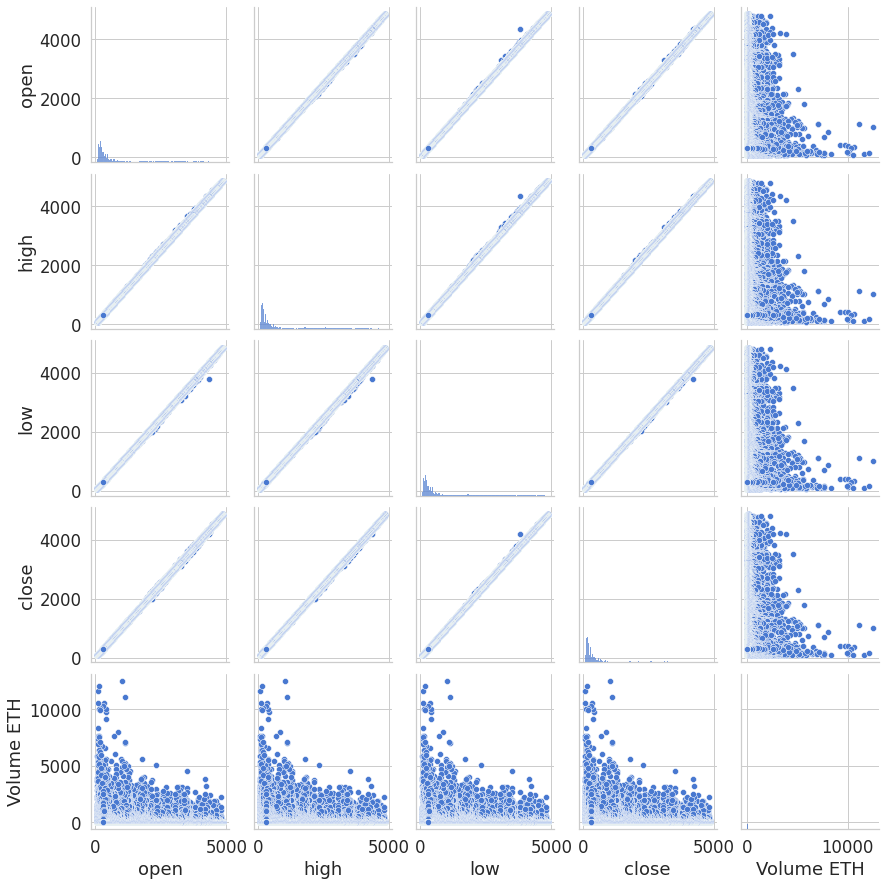

In [ ]:
sns.pairplot(eth_usd, palette='coolwarm')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

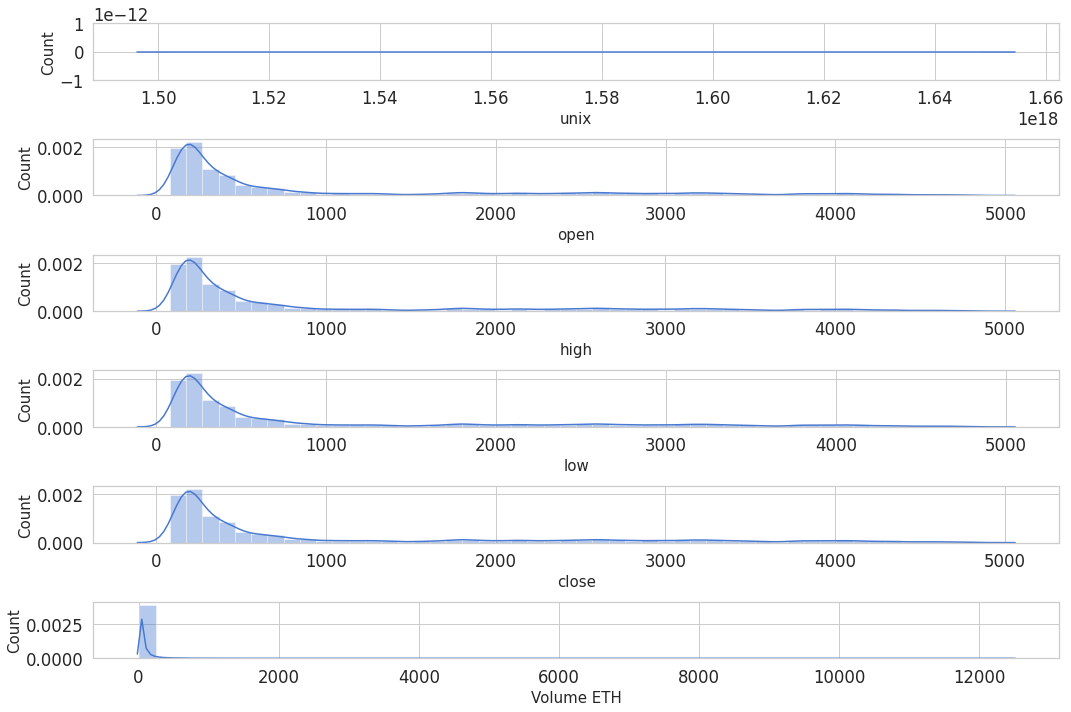

In [ ]:
# Univariate distribution of the numerical columns which contains the histograms
col_names = ['unix', 'open', 'high', 'low', 'close', 'Volume ETH']

fig, ax = plt.subplots(len(col_names), figsize=(15,10))

for i, col_val in enumerate(col_names):

    sns.distplot(eth_usd[col_val], hist=True, ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=15)
    ax[i].set_ylabel('Count', fontsize=15)

fig.tight_layout()
plt.show()

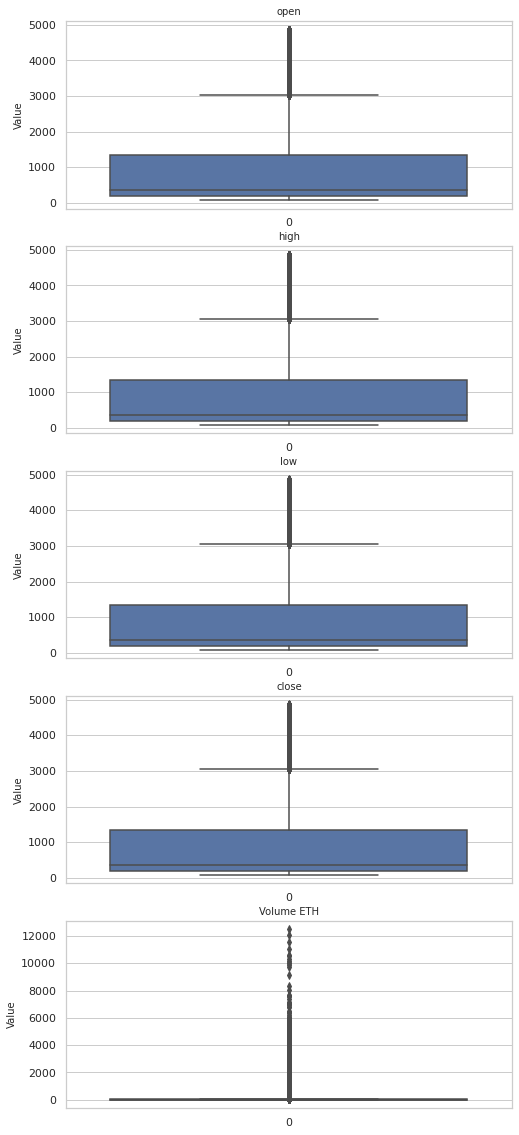

In [ ]:
# Box plot
col_names = ['unix', 'open', 'high', 'low', 'close', 'Volume ETH']

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(len(col_names[1:]), figsize=(8,20))

for i, col_val in enumerate(col_names[1:]):
    # print(col_val)
    # print(i)
    # sns.boxplot(y=data[col_val], ax=ax[i])
    sns.boxplot(data=eth_usd[col_val], ax=axes[i])
    # sns.boxplot(data=data, ax=ax[i])
    # sns.boxplot(y=data[col_val], x=data[col_val], ax=ax[i])
    
    axes[i].set_title(col_val, fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)

plt.show()

Text(0, 0.5, 'Close Price (USD)')

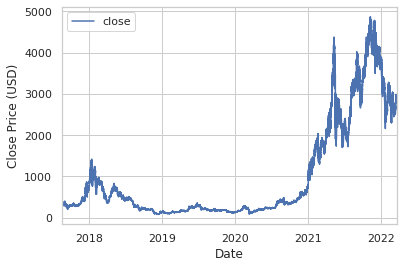

In [ ]:
ax = eth_usd.plot(x='unix', y='close');
# .plot(lw=2.5, figsize=(20, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
# plt.show()

In [ ]:
df = eth_usd.drop(['open', 'high', 'low', 'Volume ETH'], axis=1) #.rename(columns = {'unix':'date'}, inplace = True)
df.rename(columns = {'unix':'date'}, inplace = True)
print(df.head())
print(type(df))

                 date    close
0 2022-03-21 11:44:00  2909.32
1 2022-03-21 11:43:00  2909.68
2 2022-03-21 11:42:00  2909.36
3 2022-03-21 11:41:00  2910.70
4 2022-03-21 11:40:00  2909.68
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# การเปรียบเทียบรายปีบ้างครั้งเนื่องจากข้อมูลเป็นฤดูกาลเราอาจต้องเปลี่ยบเทียบในช่วงเดือนเดี่ยวกัน
# # fig = plt.figure()
# # ax = fig.add_axes([0, 0, 1, 1])

# # Prepare data
# df['year'] = [d.year for d in df.date]
# df['month'] = [d.strftime('%b') for d in df.date]
# years = df['year'].unique()

# np.random.seed(100)
# mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# print(df.loc[df.year==y, :].shape[0] - 0.9)
# print(df.loc[df.year==y, 'close'][-1:].values[0])

# # Draw Plot
# # plt.figure(1, figsize=(4, 5), frameon=False, dpi=100)
# plt.figure(figsize=(16,12), dpi= 80)
# for i, y in enumerate(years):
#     print(i)
#     print(y)
#     if i > 0:
#         plt.plot( 'month', 'close', data = df.loc[df.year == y, :], color = mycolors[i], label = y )
#         # plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
#         plt.text(df.loc[df.year==y, :].shape[0] - 0.9, 
#                  df.loc[df.year==y, 'close'][-1:].values[0], 
#                  y, 
#                  fontsize=10, 
#                  color=mycolors[i]
#                 #  ,transform=ax.transAxes
#                  )

# # Decoration
# # ax.set_axis_off()
# plt.gca().set(xlim=(-0.3, 12), ylim=(0, 70000), ylabel='$Drug Sales$', xlabel='$Month$')
# plt.yticks(fontsize=12, alpha=.7)
# plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
# plt.show()    

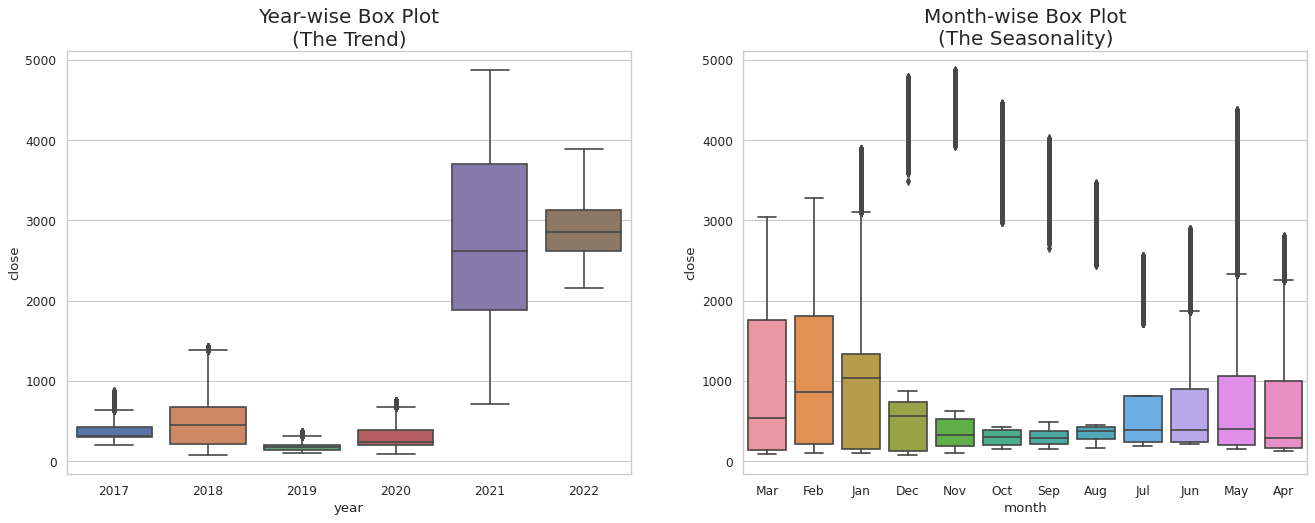

In [ ]:
# Boxplot ของการกระจายแบบ Month-wise (Seasonal) และ Year-wise (trend)
# คือ การจัดกลุ่มข้อมูลตามช่วงเวลาตามฤดูกาลและเพื่อดูว่ามีการกระจายค่าภายในปีหรือเดือนที่กำหนดและเพื่อเปรียบเทียบได้อย่างไรเมื่อเวลาผ่านไป
# 1.Year-wise Box Plot\n(The Trend) = พบว่าราคา eth เพิ่มขึ้นแรงในปี 2021
# 2.Month-wise Box Plot\n(The Seasonality = จาก Box-plot พบว่า Q3-Q2 มากสุดในเดือน March และ  mean มากสุดเดือน December

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='close', data=df, ax=axes[0])
sns.boxplot(x='month', y='close', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

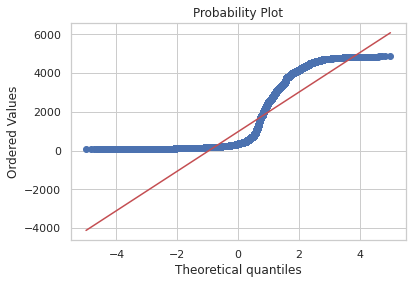

In [ ]:
# Q-Q plot
stats.probplot(df['close'], dist='norm', plot=py)
  
# sm.qqplot(np.array(df['close']), line ='45')
py.show()

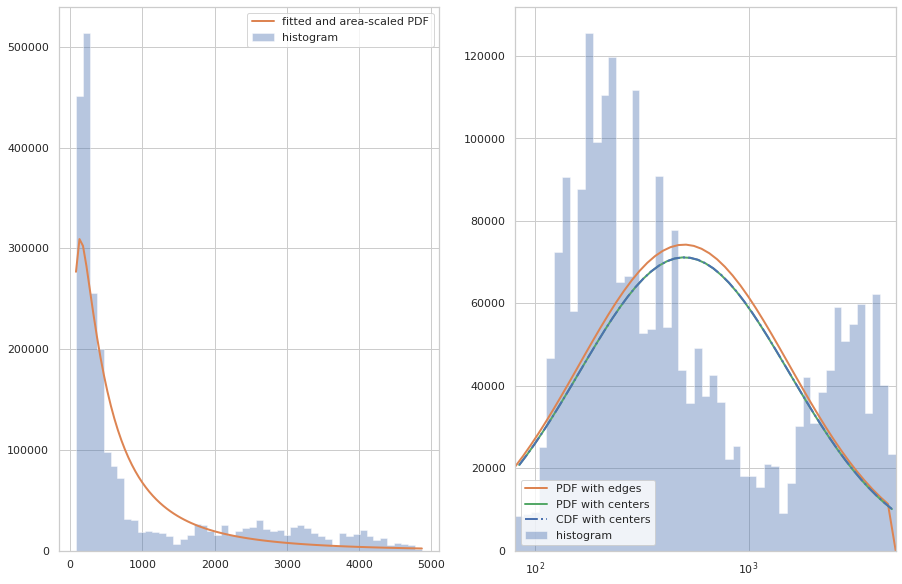

In [ ]:
# https://stackoverflow.com/questions/35001607/scaling-and-fitting-to-a-log-normal-distribution-using-a-logarithmic-axis-in-pyt

N_bins = 50

# make a fit to the samples
shape, loc, scale = stats.lognorm.fit(eth_usd['close'], floc=0)
x_fit       = np.linspace(eth_usd['close'].min(), eth_usd['close'].max(), 100)
samples_fit = stats.lognorm.pdf(x_fit, shape, loc=loc, scale=scale)

# plot a histrogram with linear x-axis
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10), gridspec_kw={'wspace':0.2})
counts, bin_edges, ignored = ax1.hist(eth_usd['close'], N_bins, histtype='stepfilled', alpha=0.4,
                                      label='histogram')

# calculate area of histogram (area under PDF should be 1)
area_hist = ((bin_edges[1:] - bin_edges[:-1]) * counts).sum()

# plot fit into histogram
ax1.plot(x_fit, samples_fit*area_hist, label='fitted and area-scaled PDF', linewidth=2)
ax1.legend()

# equally sized bins in log10-scale and centers
bins_log10 = np.logspace(np.log10(eth_usd['close'].min()), np.log10(eth_usd['close'].max()), N_bins)
bins_log10_cntr = (bins_log10[1:] + bins_log10[:-1]) / 2

# histogram plot
counts, bin_edges, ignored = ax2.hist(eth_usd['close'], bins_log10, histtype='stepfilled', alpha=0.4,
                                      label='histogram')

# calculate length of each bin and its centers(required for scaling PDF to histogram)
bins_log_len = np.r_[bin_edges[1:] - bin_edges[: -1], 0]
bins_log_cntr = bin_edges[1:] - bin_edges[:-1]

# get pdf-values for same intervals as histogram
samples_fit_log = stats.lognorm.pdf(bins_log10, shape, loc=loc, scale=scale)

# pdf-values for centered scale
samples_fit_log_cntr = stats.lognorm.pdf(bins_log10_cntr, shape, loc=loc, scale=scale)

# pdf-values using cdf 
samples_fit_log_cntr2_ = stats.lognorm.cdf(bins_log10, shape, loc=loc, scale=scale)
samples_fit_log_cntr2 = np.diff(samples_fit_log_cntr2_)

# plot fitted and scaled PDFs into histogram
ax2.plot(bins_log10, 
         samples_fit_log * bins_log_len * counts.sum(), '-', 
         label='PDF with edges',  linewidth=2)

ax2.plot(bins_log10_cntr, 
         samples_fit_log_cntr * bins_log_cntr * counts.sum(), '-', 
         label='PDF with centers', linewidth=2)

ax2.plot(bins_log10_cntr, 
         samples_fit_log_cntr2 * counts.sum(), 'b-.', 
         label='CDF with centers', linewidth=2)


ax2.set_xscale('log')
ax2.set_xlim(bin_edges.min(), bin_edges.max())
ax2.legend(loc=3)
plt.show()

,close
unix,
2017-08-20,"AxesSubplot(0.125,0.125;0.775x0.755)"
2017-08-27,"AxesSubplot(0.125,0.125;0.775x0.755)"
2017-09-03,"AxesSubplot(0.125,0.125;0.775x0.755)"
2017-09-10,"AxesSubplot(0.125,0.125;0.775x0.755)"
2017-09-17,"AxesSubplot(0.125,0.125;0.775x0.755)"
...,...
2022-02-27,"AxesSubplot(0.125,0.125;0.775x0.755)"
2022-03-06,"AxesSubplot(0.125,0.125;0.775x0.755)"
2022-03-13,"AxesSubplot(0.125,0.125;0.775x0.755)"


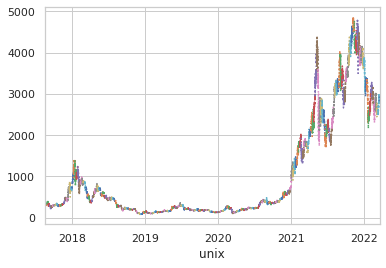

In [ ]:
# Resampling : https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8
# เทคนิคการสุ่มตัวอย่างง่ายๆ. การสุ่มตัวอย่างใหม่เกี่ยวข้องกับการเปลี่ยนความถี่ของการสังเกตอนุกรมเวลาของคุณ. เหตุผลหนึ่งที่คุณอาจ
# สนใจที่จะสุ่มตัวอย่างข้อมูลอนุกรมเวลาของคุณใหม่ก็คือวิศวกรรมคุณลักษณะ. อันที่จริง สามารถใช้เพื่อให้โครงสร้างเพิ่มเติมหรือข้อมูลเชิงลึก
# เกี่ยวกับปัญหาการเรียนรู้สำหรับรูปแบบการเรียนรู้ภายใต้การดูแล. วิธีการสุ่มตัวอย่างในแพนด้าจะคล้ายกับวิธีการจัดกลุ่มตามที่คุณจัดกลุ่มตาม
# ช่วงเวลาที่กำหนด. จากนั้นคุณระบุวิธีการที่คุณต้องการสุ่มตัวอย่างใหม่มาทำให้การสุ่มตัวอย่างมีความชัดเจนมากขึ้นโดยดูตัวอย่างบางส่วน
weekly = eth_close.resample('W')
weekly.plot(style = [':', '--', '-'])

In [ ]:
df = eth_usd.drop(['open', 'high', 'low', 'Volume ETH'], axis=1) #.rename(columns = {'unix':'date'}, inplace = True)
df.rename(columns = {'unix':'date'}, inplace = True)
df1 = df.close.values.reshape(-1, 1)

In [ ]:
eth_5min = []
eth_10min = []
eth_20min = []
eth_30min = []
eth_60min = []
eth_day = []
eth_week = []
eth_month = []


for i in range(len(df1)):
    # print(i)
    if i % 5 == 0:
      #  eth_5min.append(str(df1[i][0]))   
      #  eth_5min.append(float(df1[i][0]))
       eth_5min.append(df1[i][0])          

    if i % 10 == 0:
      #  eth_10min.append(str(df1[i][0]))
      #  eth_10min.append(float(df1[i][0]))
       eth_10min.append(df1[i][0]) 

    if i % 20 == 0:
      #  eth_20min.append(str(df1[i][0]))
      #  eth_20min.append(float(df1[i][0]))
       eth_20min.append(df1[i][0]) 
    
    if i % 30 == 0:
      #  eth_30min.append(str(df1[i][0]))
      #  eth_30min.append(float(df1[i][0]))
       eth_30min.append(df1[i][0]) 

    if i % 60 == 0:
      #  eth_60min.append(str(df1[i][0]))
      #  eth_60min.append(float(df1[i][0]))
       eth_60min.append(df1[i][0]) 
    
    if i % 1440 == 0:
       eth_day.append(df1[i][0]) 

    if i % 10080 == 0:
       eth_week.append(df1[i][0]) 

    if i % 44640 == 0:
       eth_month.append(df1[i][0]) 


In [ ]:
eth_5min = pd.Series(eth_5min)
eth_10min = pd.Series(eth_10min)
eth_20min = pd.Series(eth_20min)
eth_30min = pd.Series(eth_30min)
eth_60min = pd.Series(eth_60min)
eth_day = pd.Series(eth_day)
eth_week = pd.Series(eth_week)
eth_month = pd.Series(eth_month)

series0 = pd.Series(eth_5min)
series1 = pd.Series(eth_10min)
series2 = pd.Series(eth_20min)
series3 = pd.Series(eth_30min)
series4 = pd.Series(eth_60min)
series5 = pd.Series(eth_day)
series6 = pd.Series(eth_week)
series7 = pd.Series(eth_month)

# series0 = pd.Series(pd.Series(eth_5min))
# series1 = pd.Series(pd.Series(eth_10min))
# series2 = pd.Series(pd.Series(eth_20min))
# series3 = pd.Series(pd.Series(eth_30min))
# series4 = pd.Series(pd.Series(eth_60min))
# series5 = pd.Series(pd.Series(eth_day))
# series6 = pd.Series(pd.Series(eth_month))

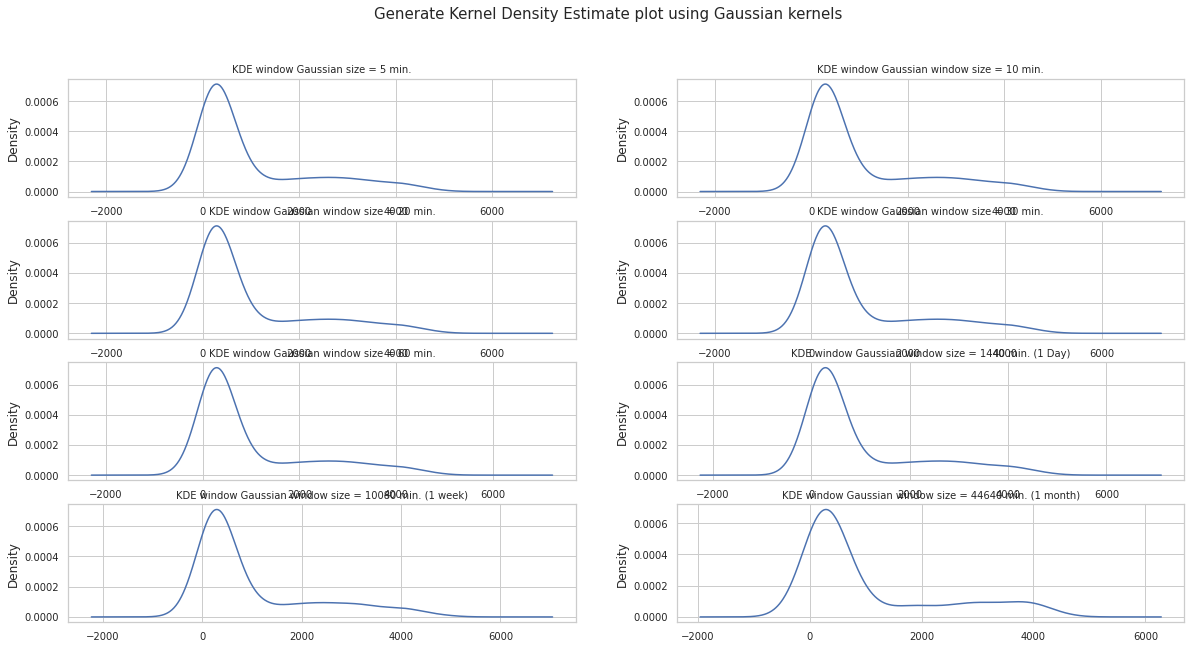

In [ ]:
# Generate Kernel Density Estimate plot using Gaussian kernels.:https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.density.html , # https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8 
fig, axes = plt.subplots(4, 2, figsize=(20,10))
fig.suptitle('Generate Kernel Density Estimate plot using Gaussian kernels', fontsize=15)

# sns.kdeplot(data=series0, ax=axes[0,0]) #, x = "close", ax=axes[0])
series0.plot.kde(bw_method=0.3, fontsize=10, ax=axes[0,0]) #, ax=axes[0])

# sns.kdeplot(data=series1, ax=axes[0,1]) #, x = "close", ax=axes[0])
series1.plot.kde(bw_method=0.3, fontsize=10, ax=axes[0,1])

series2.plot.kde(bw_method=0.3, fontsize=10, ax=axes[1,0])

series3.plot.kde(bw_method=0.3, fontsize=10, ax=axes[1,1])

series4.plot.kde(bw_method=0.3, fontsize=10, ax=axes[2,0])

series5.plot.kde(bw_method=0.3, fontsize=10, ax=axes[2,1])

series6.plot.kde(bw_method=0.3, fontsize=10, ax=axes[3,0])

series7.plot.kde(bw_method=0.3, fontsize=10, ax=axes[3,1])

# Set Title
axes[0,0].set_title('KDE window Gaussian size = 5 min.', fontsize=10)
axes[0,1].set_title('KDE window Gaussian window size = 10 min.', fontsize=10)
axes[1,0].set_title('KDE window Gaussian window size = 20 min.', fontsize=10)
axes[1,1].set_title('KDE window Gaussian window size = 30 min.', fontsize=10)
axes[2,0].set_title('KDE window Gaussian window size = 60 min.', fontsize=10)
axes[2,1].set_title('KDE window Gaussian window size = 1440 min. (1 Day)', fontsize=10)
axes[3,0].set_title('KDE window Gaussian window size = 10080 min. (1 week)', fontsize=10)
axes[3,1].set_title('KDE window Gaussian window size = 44640 min. (1 month)', fontsize=10)

plt.show()

**Rolling = 5 minute**

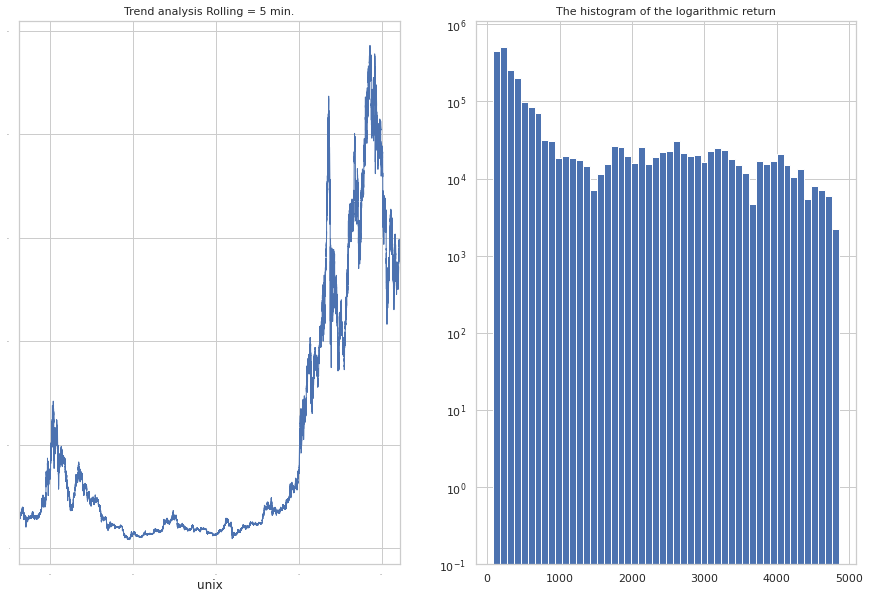

In [ ]:
# Trend analysis https://www.facebook.com/investicbkk/photos/a.170233031218051/242081094033244/
# Rolling = 5
fig, axes = plt.subplots(1, 2, figsize=(20,10))
eth_rolling_five = eth_close['close'].rolling(5).mean()
eth_rolling_five.plot(figsize=(15,10), linewidth=1, fontsize=1, ax=axes[0])

# The histogram of the logarithmic return  (source: https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale)
series = pd.Series(eth_rolling_five)
series.hist(bins=50, bottom=0.1) #, ax=axes[1])
axes[1].set_yscale('log')

# Set Title
axes[0].set_title('Trend analysis Rolling = 5 min.', fontsize=11); 
axes[1].set_title('The histogram of the logarithmic return', fontsize=11)
plt.show()


**Rolling = 10 minute**

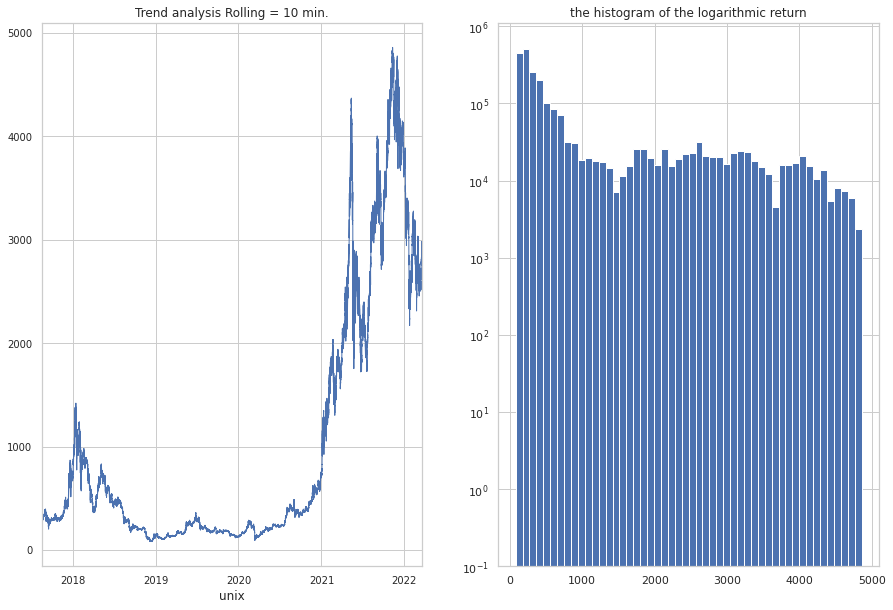

In [ ]:
# Trend analysis https://www.facebook.com/investicbkk/photos/a.170233031218051/242081094033244/
# Rolling = 10
fig, axes = plt.subplots(1, 2, figsize=(20,10))
eth_rolling_ten = eth_close['close'].rolling(10).mean()
eth_rolling_ten.plot(figsize=(15,10), linewidth=1, fontsize=10, ax=axes[0])

# The histogram of the logarithmic return  (source: https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale)
series = pd.Series(eth_rolling_ten)
series.hist(bins=50, bottom=0.1, ax=axes[1])
axes[1].set_yscale('log')

# Set Title
axes[0].set_title('Trend analysis Rolling = 10 min.', fontsize=12); 
axes[1].set_title('the histogram of the logarithmic return', fontsize=12)
plt.show()


**Rolling = 20 minute**

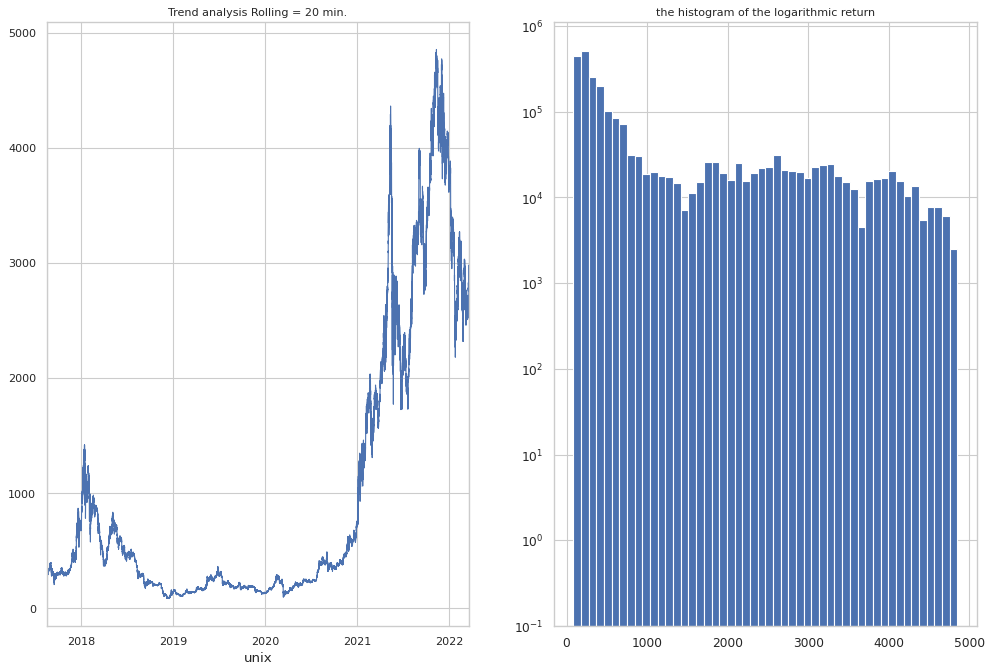

In [ ]:
# Trend analysis https://www.facebook.com/investicbkk/photos/a.170233031218051/242081094033244/
# Rolling = 20
fig, axes = plt.subplots(1, 2, figsize=(20,10), dpi= 80)
eth_rolling_twenty = eth_close['close'].rolling(20).mean()
eth_rolling_twenty.plot(figsize=(15,10), linewidth=1, fontsize=10, ax=axes[0])

# The histogram of the logarithmic return  (source: https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale)
series = pd.Series(eth_rolling_twenty)
series.hist(bins=50, bottom=0.1, ax=axes[1])
axes[1].set_yscale('log')

# Set Title
axes[0].set_title('Trend analysis Rolling = 20 min.', fontsize=10); 
axes[1].set_title('the histogram of the logarithmic return', fontsize=10)
plt.show()


**Rolling = 30 minute**

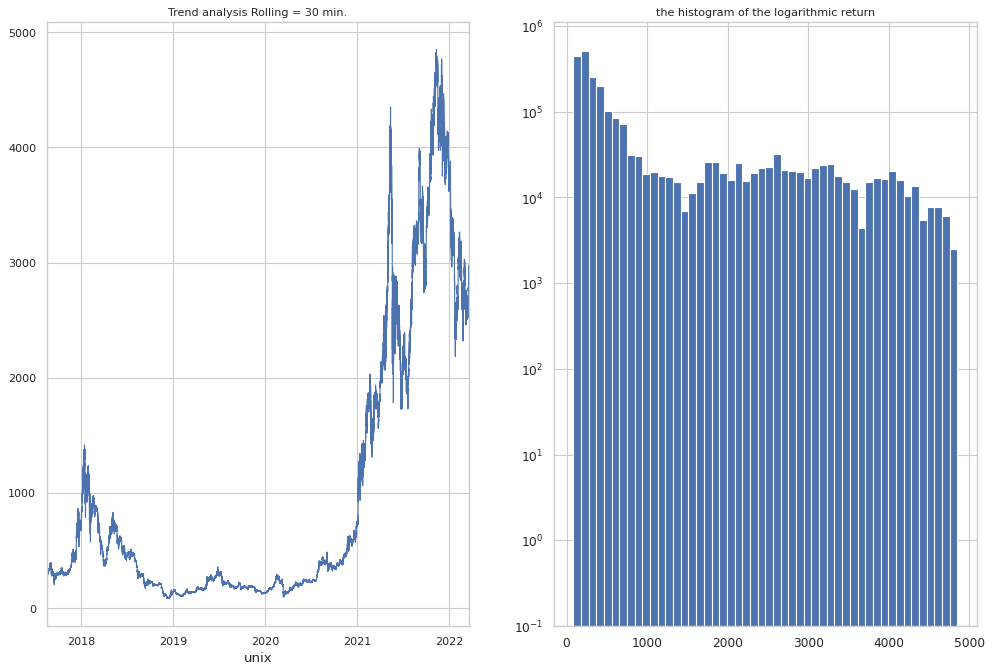

In [ ]:
# Trend analysis https://www.facebook.com/investicbkk/photos/a.170233031218051/242081094033244/
# Rolling = 30
fig, axes = plt.subplots(1, 2, figsize=(20,20), dpi= 80)
eth_rolling_thirty = eth_close['close'].rolling(30).mean()
eth_rolling_thirty.plot(figsize=(15,10), linewidth=1, fontsize=10, ax=axes[0])

# The histogram of the logarithmic return  (source: https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale)
series = pd.Series(eth_rolling_thirty)
series.hist(bins=50, bottom=0.1, ax=axes[1])
axes[1].set_yscale('log')

# Set Title
axes[0].set_title('Trend analysis Rolling = 30 min.', fontsize=10); 
axes[1].set_title('the histogram of the logarithmic return', fontsize=10)
plt.show()


**Rolling = 60 minute**

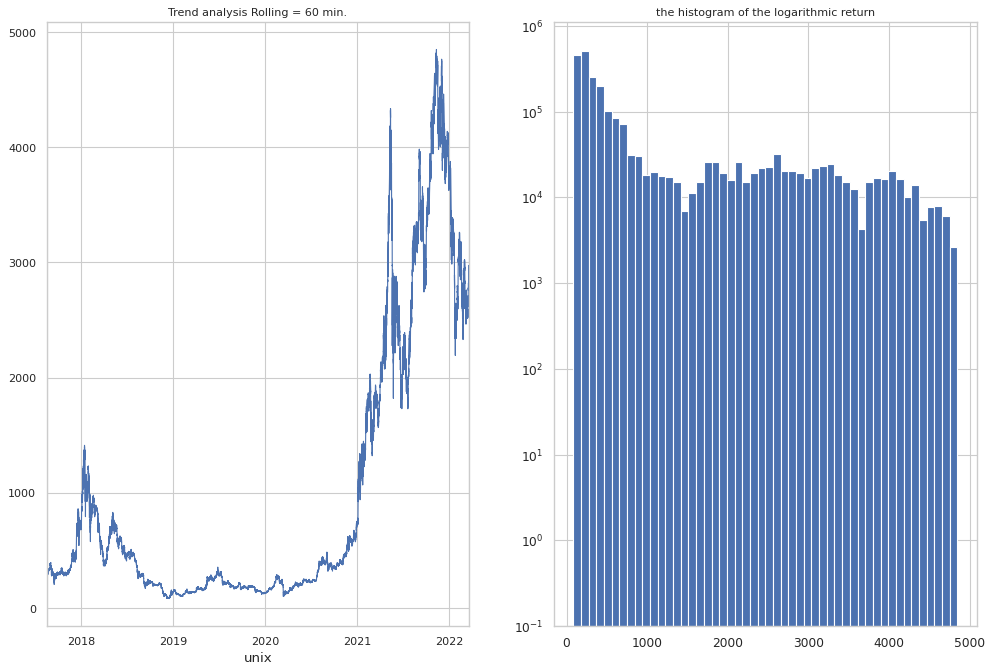

In [ ]:
# Trend analysis https://www.facebook.com/investicbkk/photos/a.170233031218051/242081094033244/
# Rolling = 30
fig, axes = plt.subplots(1, 2, figsize=(20,20), dpi= 80)
eth_rolling_sixty = eth_close['close'].rolling(60).mean()
eth_rolling_sixty.plot(figsize=(15,10), linewidth=1, fontsize=10, ax=axes[0])

# The histogram of the logarithmic return  (source: https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale)
series = pd.Series(eth_rolling_sixty)
series.hist(bins=50, bottom=0.1, ax=axes[1])
axes[1].set_yscale('log')

# Set Title
axes[0].set_title('Trend analysis Rolling = 60 min.', fontsize=10); 
axes[1].set_title('the histogram of the logarithmic return', fontsize=10)
plt.show()

In [ ]:
# pd.plotting.autocorrelation_plot(eth_close['close'])
# plt.show()

In [ ]:
# eth_recent = eth_close.loc['2021-01-01 00:00:00':'2022-02-15 00:00:00']
eth_recent = eth_close.loc['2022-03-20 00:00:00':'2022-03-21 00:00:00']
rroll_d3 = eth_recent.rolling(window=72).mean()
rroll_d7 = eth_recent.rolling(window=168).mean()
rroll_d14 = eth_recent.rolling(window=336).mean()

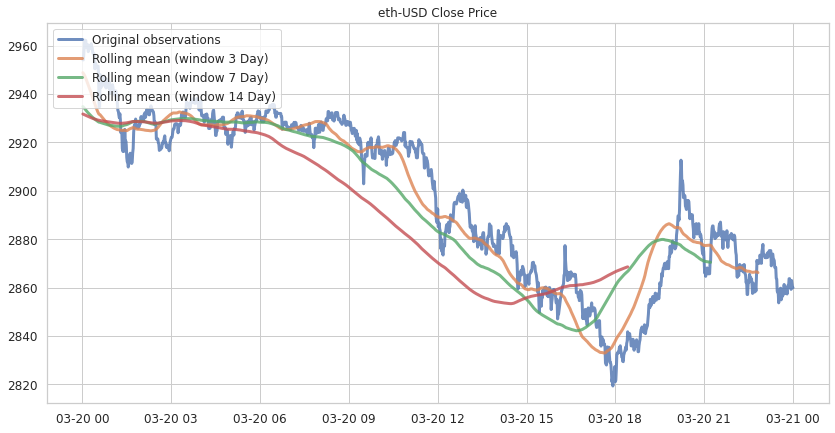

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(eth_recent.index, eth_recent, lw=3, alpha=0.8,label='Original observations')
plt.plot(eth_recent.index, rroll_d3, lw=3, alpha=0.8,label='Rolling mean (window 3 Day)')
plt.plot(eth_recent.index, rroll_d7, lw=3, alpha=0.8,label='Rolling mean (window 7 Day)')
plt.plot(eth_recent.index, rroll_d14, lw=3, alpha=0.8,label='Rolling mean (window 14 Day)')
plt.title('eth-USD Close Price')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [ ]:
short_window = 240
mid_window = 1200
signals = pd.DataFrame(index=eth_close.index)
signals['signal'] = 0.0
roll_d10 = eth_close.rolling(window=short_window).mean()
roll_d50 = eth_close.rolling(window=mid_window).mean()
signals['short_mavg'] = roll_d10
signals['mid_mavg'] = roll_d50
signals['signal'][short_window:] = np.where(signals['short_mavg']
[short_window:] > signals['mid_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

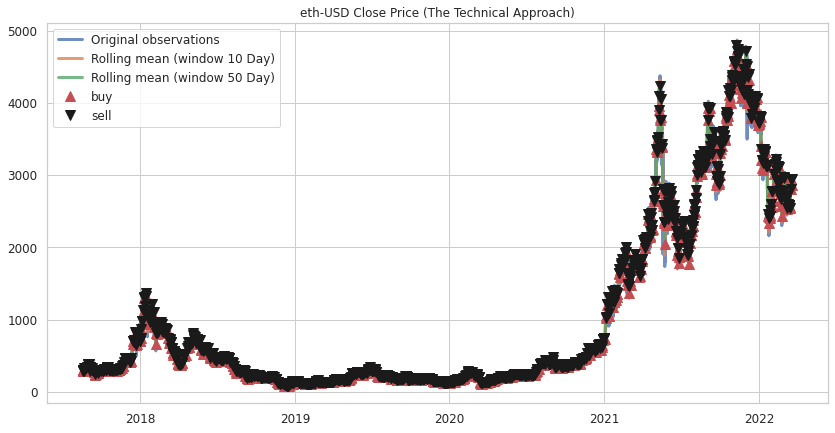

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(eth_close.index, eth_close, lw=3, alpha=0.8,label='Original observations')
plt.plot(eth_close.index, roll_d10, lw=3, alpha=0.8,label='Rolling mean (window 10 Day)')
plt.plot(eth_close.index, roll_d50, lw=3, alpha=0.8,label='Rolling mean (window 50 Day)')
plt.plot(
         signals.loc[signals.positions == 1.0].index,
         signals.short_mavg[signals.positions == 1.0],
         '^', 
         markersize=10, 
         color='r', 
         label='buy'
         )

plt.plot(signals.loc[signals.positions == -1.0].index,
signals.short_mavg[signals.positions == -1.0],
                   'v', markersize=10, color='k', label='sell')
plt.title('eth-USD Close Price (The Technical Approach)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# **2. Data Prepraration**

**Remove outlier by Isolation forest**

In [ ]:
# Isolation forest remove outlier
# Ref. : 1.https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
#        2.https://guopai.github.io/ml-blog13.html#:~:text=Isolation%20forest%20%E0%B9%83%E0%B8%8A%E0%B9%89%E0%B9%80%E0%B8%97%E0%B8%84%E0%B8%99%E0%B8%B4%E0%B8%84%E0%B9%81%E0%B8%9A%E0%B8%9A,%E0%B9%80%E0%B8%9B%E0%B9%87%E0%B8%99%E0%B8%82%E0%B9%89%E0%B8%AD%E0%B8%A1%E0%B8%B9%E0%B8%A5%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B8%9C%E0%B8%B4%E0%B8%94%E0%B8%9B%E0%B8%81%E0%B8%95%E0%B8%B4
#        3.https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

clf = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),
                      max_features=1.0)

clf.fit( eth_closes[['close']] )

eth_closes['score'] = clf.decision_function( eth_closes[['close']] )
eth_closes['anomaly'] = clf.predict( eth_closes[['close']] )
print(eth_closes[:31])
print('-'*100)

anomaly = eth_closes.loc[ eth_closes['anomaly'] == -1 ]
anomaly_index = list(anomaly.index)
print(anomaly)

# original 2743900
# contaminate 0.12 = 328913 (11.99%)
# contaminate 0.10 = 274382 (10.00%)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


                     close     score  anomaly
unix                                         
2017-08-16 16:45:00  300.0  0.168707        1
2017-08-16 16:46:00  300.0  0.168707        1
2017-08-16 16:47:00  300.0  0.168707        1
2017-08-16 16:48:00  300.0  0.168707        1
2017-08-16 16:49:00  300.0  0.168707        1
2017-08-16 16:50:00  300.0  0.168707        1
2017-08-16 16:51:00  300.0  0.168707        1
2017-08-16 16:52:00  300.0  0.168707        1
2017-08-16 16:53:00  300.0  0.168707        1
2017-08-16 16:54:00  300.0  0.168707        1
2017-08-16 16:55:00  300.0  0.168707        1
2017-08-16 16:56:00  300.0  0.168707        1
2017-08-16 16:57:00  300.0  0.168707        1
2017-08-16 16:58:00  300.0  0.168707        1
2017-08-16 16:59:00  300.0  0.168707        1
2017-08-16 17:00:00  300.0  0.168707        1
2017-08-16 17:01:00  300.0  0.168707        1
2017-08-16 17:02:00  300.0  0.168707        1
2017-08-16 17:03:00  300.0  0.168707        1
2017-08-16 17:04:00  300.0  0.1687

In [ ]:
outliers_counter = len(eth_close[eth_closes['anomaly'] == -1])
print(outliers_counter)
print("Accuracy percentage:", 100*list(eth_closes['anomaly']).count(-1)/(outliers_counter))

anomaly = eth_closes[eth_closes['anomaly'] == -1]
print(anomaly.head())
print(len(eth_closes[eth_closes['anomaly'] == -1]))

eth_closes = eth_closes[eth_closes['anomaly'] == 1]
print(len(eth_closes[eth_closes['anomaly'] == 1]))

eth_closes =  eth_closes.drop(['score', 'anomaly'], axis=1)
print(eth_closes.head())
print(len(eth_closes))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


240965
Accuracy percentage: 100.0
                       close     score  anomaly
unix                                           
2018-01-10 04:26:00  1354.99 -0.002685       -1
2018-01-10 04:28:00  1355.00 -0.002685       -1
2018-01-10 04:29:00  1356.28 -0.002685       -1
2018-01-10 04:30:00  1360.00 -0.004036       -1
2018-01-10 04:31:00  1357.00 -0.003492       -1
240965
2175055
                     close
unix                      
2017-08-16 16:45:00  300.0
2017-08-16 16:46:00  300.0
2017-08-16 16:47:00  300.0
2017-08-16 16:48:00  300.0
2017-08-16 16:49:00  300.0
2175055


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

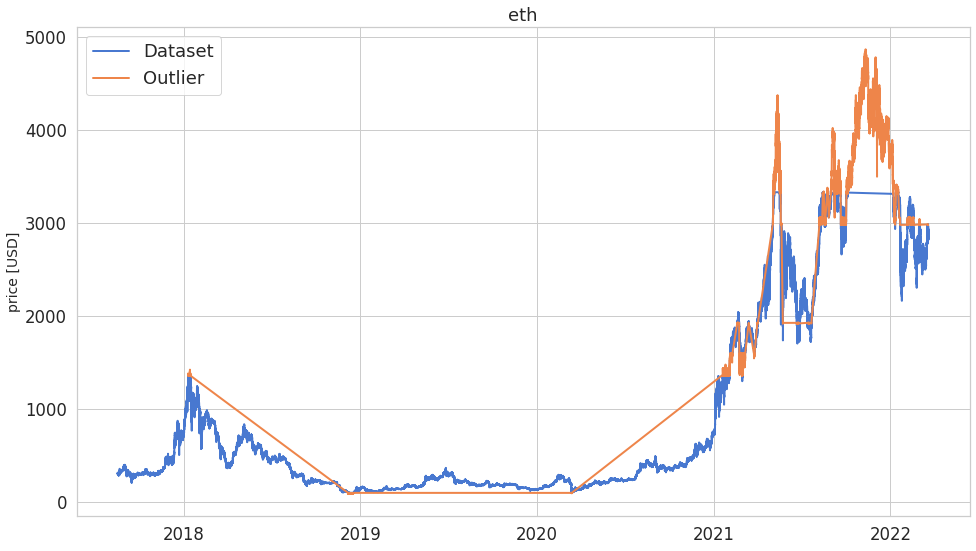

In [ ]:
# Orange line is outlier, blue is dataset
line_plot(eth_closes.close, anomaly.close, 'Dataset', 'Outlier', 'eth')

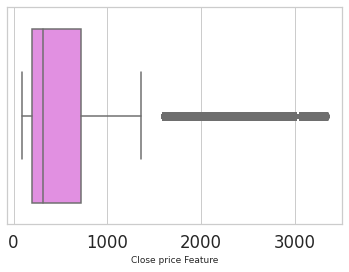

In [ ]:
fig = plt.figure(figsize=(6,4))
sns.boxplot(x=eth_closes['close'], color = 'violet')
plt.xlabel('Close price Feature', fontsize=9)
plt.savefig('boxplot.png', dpi=300)

In [ ]:
# Remove outlier, The distribution of Rt is approximately symmetric and stationary
# https://stats.stackexchange.com/questions/69874/how-to-correct-outliers-once-detected-for-time-series-data-forecasting#:~:text=For%20non%2Dseasonal%20time%20series,before%20re%2Dseasonalizing%20the%20result.
# https://towardsdatascience.com/time-series-outlier-detection-with-thymeboost-ec2046e17458

# threshold = 0.1
# window = 30
# for i in range(len(eth_usd)):

#     Rt = math.log(eth_usd['close'][i] / eth_usd['close'][i-30])

#     if abs(Rt) < threshold:   # Remove data in index
#         # dropping passed values
#         eth_usd.drop([i], inplace = True)
#     else:
#         pass

# print(len(eth_usd))
# print(eth_usd.head())

In [ ]:
# # LOG TRANSFORM
# https://arnondora.in.th/handling-skew-data-with-log-transform/#:~:text=Log%20Transform%20%E0%B9%80%E0%B8%9B%E0%B9%87%E0%B8%99%E0%B8%A7%E0%B8%B4%E0%B8%98%E0%B8%B5%E0%B8%AB%E0%B8%99%E0%B8%B6%E0%B9%88%E0%B8%87,%E0%B8%97%E0%B8%B1%E0%B9%89%E0%B8%87%E0%B8%AB%E0%B8%A5%E0%B8%B2%E0%B8%A2%20%E0%B9%83%E0%B8%99%E0%B8%84%E0%B8%A7%E0%B8%B2%E0%B8%A1%E0%B9%80%E0%B8%9B%E0%B9%87%E0%B8%99%E0%B8%88%E0%B8%A3%E0%B8%B4%E0%B8%87
# eth_closes['log'] = (eth_closes['close']).transform(np.log)
# eth_closes.sample(n=5).head().

# plt.subplot(221)
# ax1 = eth_closes['close'].plot.hist(bins=12, alpha=0.5)
# ax1.figure.savefig('hist.png', dpi=300) 
# plt.ylabel('Before use log transforn')

# plt.subplot(212)
# ax2 = eth_closes['log'].plot.hist(bins=12, alpha=0.5)
# ax2.figure.savefig('hist.png', dpi=300) 
# plt.ylabel('After use log transforn')

# plt.show()

## **2.1 Data Preparation (SPLIT train 0.9 test 0.1) + (Don't have static = 0)**

- Descripe time series
https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8

- Array  
https://python3.wannaphong.com/2014/12/array-python.html  
https://devjourneys.com/2020/10/12/dimensions-numpy-arrays-python/

In [ ]:
# https://hackernoon.com/dont-be-fooled-deceptive-cryptocurrency-price-predictions-using-deep-learning-bf27e4837151

def train_test_split(df, test_size=0.1):

    split_row = len(df) - int(test_size * len(df))  # 0.90 = 1.00 - 0.10
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

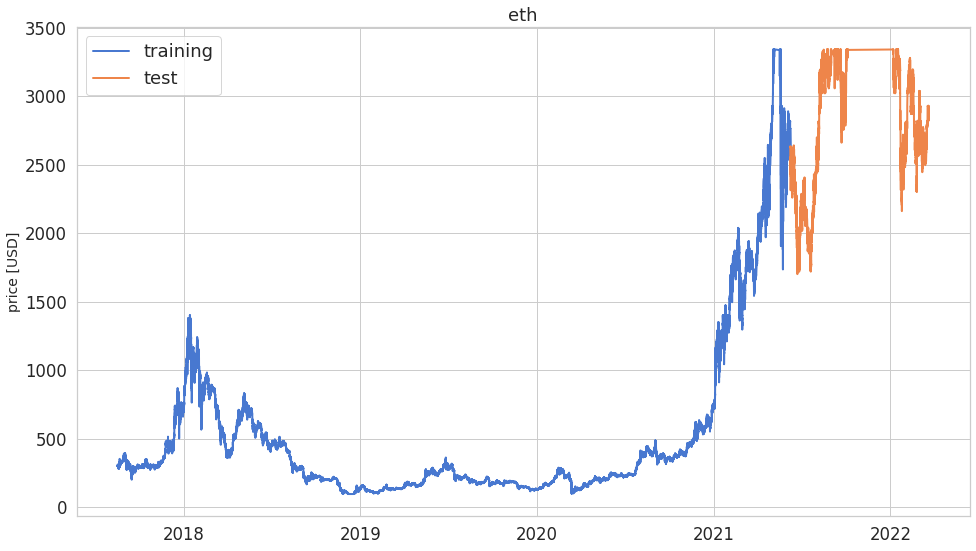

In [ ]:
train, test = train_test_split(eth_closes, test_size=0.1)
line_plot(train.close, test.close, 'training', 'test', 'eth')

**Function**

In [ ]:
# # def normalise_zero_base(df):
# #     """ Normalise dataframe column-wise to reflect changes with respect to first entry.
# #         ปรับคอลัมน์ดาต้าเฟรมให้เป็นมาตรฐานเพื่อสะท้อนการเปลี่ยนแปลงที่เกี่ยวข้องกับรายการแรก
# #     """
# #     return df / df.iloc[0] - 1

# def normalise_min_max(df):
#     """ Feature Scaling min max Normalise dataframe column-wise min/max. """
#     return (df - df.min()) / (df.max() - df.min())

In [ ]:
# def extract_window_data(df, window=30, min_max=True):      #zero_base=True):
#     """ Convert dataframe to overlapping sequences/windows of length `window`.
#         แปลงดาต้าเฟรมเป็นลำดับที่ทับซ้อนกัน/หน้าต่างของหน้าต่างความยาว
#     """
#     X = []
#     y = []
#     window_mt_y = []
#     # for idx in range(len(df) - window):
#     #     tmp = df[idx: (idx + window)].copy()
#     #     if zero_base:
#     #         tmp = normalise_zero_base(tmp)
#     #     window_data.append(tmp.values)
#     # return np.array(window_data)

#     for idx in range( (len(df) // window) + 1 ):

#         tmp = df[ idx * window : ((idx * window) + window) ].copy()
#         # print(tmp)
#         # print(type(tmp))    # <class 'pandas.core.frame.DataFrame'>

#         window_tmp = tmp['close'].to_numpy()
#         mt = tmp.mean()

#         # if min_max:
#         #     # tmp = normalise_zero_base(tmp)
#         #     norm_min_max = normalise_min_max(df)
#         #     # print(norm_min_max)
#         #     # print(type(norm_min_max))   # <class 'pandas.core.frame.DataFrame'>

#         X.append(window_tmp)
#         window_mt_y.append(mt.values)

#     for i in range( (len(df) // window) ):
#         '''
#         target label => 1 = down trend, 2 = up trend, 0 = static  
#         in paper eth/usd plus + 0.24 Up and Down trend
#         '''
#         if ( window_mt_y[i][0] > window_mt_y[i+1][0] ):  # create down trend = 1
#             y.append(1)
#         elif ( window_mt_y[i][0] < window_mt_y[i+1][0] ):  # create up trend = 2
#             y.append(2)
#         else:        # create static trend = 2
#             y.append(2)


#     # window_data = window_data[0]
#     # window_data = window_data[:91463]
#     # window_mt = window_mt[:91463]

#     return np.array(X) , np.array(y)

In [ ]:
# # window = 30 min, window = 60 min = 1 hour, window = 1440 min = 1 day

# def prepare_data(df, window=30, min_max=True, test_size=0.1):   # zero_base=True , min_max=True
#     """ Prepare data for OS-CNN. """
#     # train test split
#     train_data, test_data = train_test_split(df, test_size)
    
#     # extract window data
#     X_train, y_train = extract_window_data(train_data, window, min_max)
#     X_test, y_test = extract_window_data(test_data, window, min_max)

#     return X_train, X_test, y_train, y_test

In [ ]:
# X_train, X_test, y_train, y_test = prepare_data(eth_closes)

In [ ]:
# Normalization
# min-max normalization 
# https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
# https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

scaler = MinMaxScaler()
close_price = eth_closes.close.values.reshape(-1, 1)
eth_closes = scaler.fit_transform(close_price)
eth_closes = pd.DataFrame(eth_closes, columns = ['close'])

print(f'Head 10 : {eth_closes[:11]}')
print('-'*50)
print(f'Tail 10 : {eth_closes[2743890:]}')
print('-'*50)
print(f'Original  max price : {close_price.max()} min price : {close_price.min()}')
print('-'*50)
print(f'Min max normalization max price : {eth_closes.max()} min price : {eth_closes.min()}')
print('-'*50)
print(f'Shape dataset : {eth_closes.shape}')
print('-'*50)
print(f'Orginal close price : {close_price}')
print(type(close_price))
print('-'*50)
print(f'Min max normalization close price : {eth_closes}')
print(type(eth_closes))

Head 10 :        close
0   0.062813
1   0.062813
2   0.062813
3   0.062813
4   0.062813
5   0.062813
6   0.062813
7   0.062813
8   0.062813
9   0.062813
10  0.062813
--------------------------------------------------
Tail 10 : Empty DataFrame
Columns: [close]
Index: []
--------------------------------------------------
Original  max price : 3341.36 min price : 96.16
--------------------------------------------------
Min max normalization max price : close    1.0
dtype: float64 min price : close    0.0
dtype: float64
--------------------------------------------------
Shape dataset : (2174570, 1)
--------------------------------------------------
Orginal close price : [[ 300.  ]
 [ 300.  ]
 [ 300.  ]
 ...
 [2911.83]
 [2911.83]
 [2910.7 ]]
<class 'numpy.ndarray'>
--------------------------------------------------
Min max normalization close price :             close
0        0.062813
1        0.062813
2        0.062813
3        0.062813
4        0.062813
...           ...
2174565  0.86847

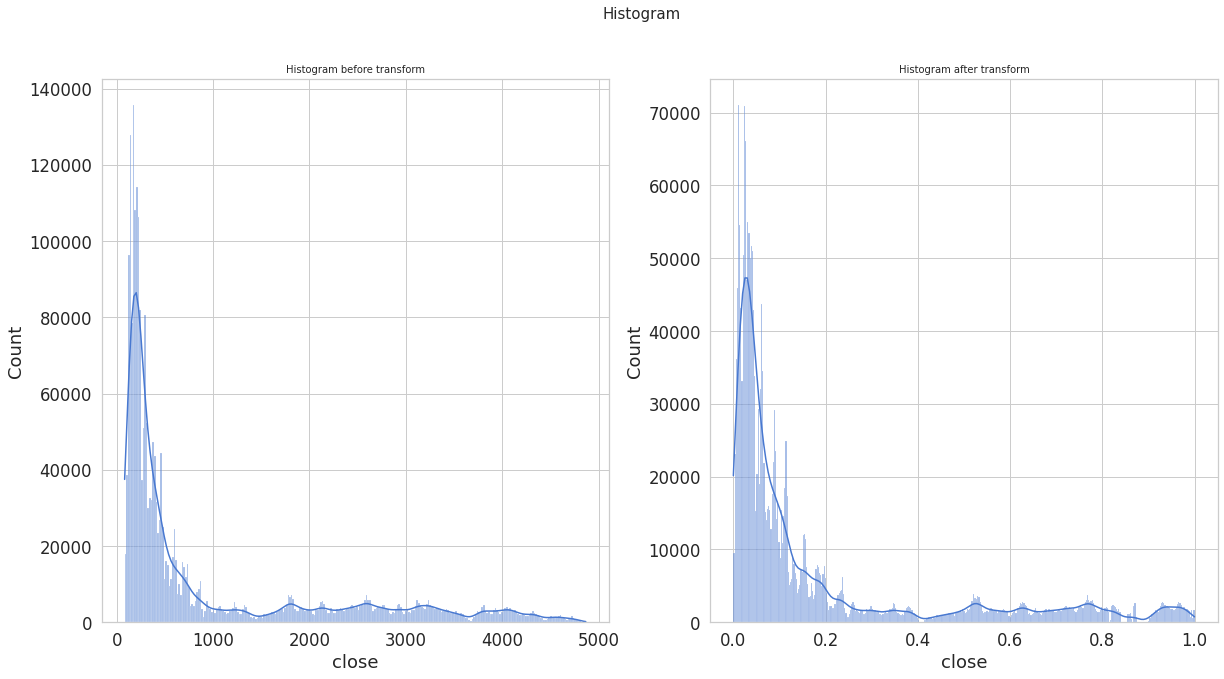

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Histogram', fontsize=15)

# Draw
sns.histplot(data=eth_close, x="close", kde=True, ax=axes[0])

sns.histplot(data=eth_closes, x="close", kde=True, ax=axes[1])

# Set Title
axes[0].set_title('Histogram before transform', fontsize=10)
axes[1].set_title('Histogram after transform', fontsize=10)

plt.show()

In [ ]:
# Split test set 15%

test_data = eth_closes.iloc[ int(len(eth_closes)*0.85) : ]
train_val_data = eth_closes.iloc[ : int(len(eth_closes)*0.85) ]

# # train val split
# val_size = 0.15
train_size =  0.823529411764706
val_size =  0.176470588235294

split_row = len(train_val_data) - int(val_size * len(train_val_data))  # 0.90 = 1.00 - 0.10
train_data = train_val_data.iloc[:split_row]
val_data = train_val_data.iloc[split_row:]

# print(f'Train_data : {train_data.head()}')
# print(f'Test data : {test_data.head()}')
# print(f'Test data : {test_data.tail()}')

In [ ]:
# Defind Dataset window size = 30 train test set
window = 30
X_train = []
X_test = []
X_val = []

window_mt_y_train = []
window_mt_y_test = []
window_mt_y_val = []

# find X train
for idx in range( (len(train_data) // window) + 1 ):
    print(f'index train window : {idx}')
    tmp_train = train_data[idx * window : ((idx * window) + window)].copy()  # create array dimension window 30 min.  # <class 'pandas.core.frame.DataFrame'>
    # print(tmp_train)
    # print(type(tmp_train))    

    window_tmp_train = tmp_train['close'].to_numpy()  # <class 'numpy.ndarray'>
    # print(window_tmp_train)
    # print(type(window_tmp_train))  
    # print(window_tmp_train.shape)

    mt_train = tmp_train.mean()   # mean price in window 30 min. for find y classification

    X_train.append(window_tmp_train)
    # X_train.append(tmp_train.values)
    window_mt_y_train.append(mt_train.values)

# find X val
for idx in range( (len(val_data) // window) + 1 ):    # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
    print(f'index validation window : {idx}')
    tmp_val = val_data[idx * window : ((idx * window) + window)].copy() 
    # print(tmp_val)
    # print(type(tmp_val))    
    
    window_tmp_val = tmp_val['close'].to_numpy()   # <class 'numpy.ndarray'>
    # print(window_tmp_val)
    # print(type(window_tmp_val))  
    # print(window_tmp_val.shape)

    mt_val = tmp_val.mean()   # mean price in window 30 min. for find y classification

    X_val.append(window_tmp_val)
    # X_val.append(tmp_val.values)
    window_mt_y_val.append(mt_val.values)

# ============================================================================================================================
# find X test
for idx in range( (len(test_data) // window) + 1 ):    # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
    print(f'index test window : {idx}')
    tmp_test = test_data[idx * window : ((idx * window) + window)].copy() 
    # print(tmp)
    # print(type(tmp))    
    
    window_tmp_test = tmp_test['close'].to_numpy()   # <class 'numpy.ndarray'>
    # print(window_tmp_test)
    # print(type(window_tmp_test))  
    # print(window_tmp_test.shape)

    mt_test = tmp_test.mean()   # mean price in window 30 min. for find y classification

    X_test.append(window_tmp_test)
    # X_test.append(tmp_test.values)
    window_mt_y_test.append(mt_test.values)

Streaming output truncated to the last 5000 lines.
index test window : 5873
index test window : 5874
index test window : 5875
index test window : 5876
index test window : 5877
index test window : 5878
index test window : 5879
index test window : 5880
index test window : 5881
index test window : 5882
index test window : 5883
index test window : 5884
index test window : 5885
index test window : 5886
index test window : 5887
index test window : 5888
index test window : 5889
index test window : 5890
index test window : 5891
index test window : 5892
index test window : 5893
index test window : 5894
index test window : 5895
index test window : 5896
index test window : 5897
index test window : 5898
index test window : 5899
index test window : 5900
index test window : 5901
index test window : 5902
index test window : 5903
index test window : 5904
index test window : 5905
index test window : 5906
index test window : 5907
index test window : 5908
index test window : 5909
index test window : 5910

In [ ]:
# find target trend label for trian validatoin => One hot encode
y_train = []
y_val = []
y_test = []

down_trend = 0
static_trend = 0
up_trend = 1

# find y train
for i in range( len(window_mt_y_train) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y train {i}')
    if ( window_mt_y_train[i][0] > window_mt_y_train[i+1][0] ):  # create down trend = 2
        y_train.append(down_trend)
        # X_train[i][0].append(down_trend)
    elif ( window_mt_y_train[i][0] < window_mt_y_train[i+1][0] ):  # create up trend = 1
        y_train.append(up_trend)
        # X_train[i][0].append(up_trend)
    else:         # create static trend = 2
        y_train.append(static_trend)
        # X_train[i].append(static_trend)

# find y validation
for i in range( len(window_mt_y_val) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y validation {i}')
    if ( window_mt_y_val[i][0] > window_mt_y_val[i+1][0] ):    # create down trend = 2
        y_val.append(down_trend)
        # X_val[i].append(down_trend)
    elif ( window_mt_y_val[i][0] < window_mt_y_val[i+1][0] ):   # create up trend = 1
        y_val.append(up_trend)
        # X_val[i].append(up_trend)
    else:         # create static trend = 2
        y_val.append(static_trend)
        # X_val[i].append(static_trend)

# find y test
for i in range( len(window_mt_y_test) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y test {i}')
    if ( window_mt_y_test[i][0] > window_mt_y_test[i+1][0] ):    # create down trend = 2
        y_test.append(down_trend)
        # X_test[i].append(down_trend)
    elif ( window_mt_y_test[i][0] < window_mt_y_test[i+1][0] ):   # create up trend = 1
        y_test.append(up_trend)
        # X_test[i].append(up_trend)
    else:         # create static trend = 2
        y_test.append(static_trend)
        # X_test[i].append(static_trend)


Streaming output truncated to the last 5000 lines.
index y test 5872
index y test 5873
index y test 5874
index y test 5875
index y test 5876
index y test 5877
index y test 5878
index y test 5879
index y test 5880
index y test 5881
index y test 5882
index y test 5883
index y test 5884
index y test 5885
index y test 5886
index y test 5887
index y test 5888
index y test 5889
index y test 5890
index y test 5891
index y test 5892
index y test 5893
index y test 5894
index y test 5895
index y test 5896
index y test 5897
index y test 5898
index y test 5899
index y test 5900
index y test 5901
index y test 5902
index y test 5903
index y test 5904
index y test 5905
index y test 5906
index y test 5907
index y test 5908
index y test 5909
index y test 5910
index y test 5911
index y test 5912
index y test 5913
index y test 5914
index y test 5915
index y test 5916
index y test 5917
index y test 5918
index y test 5919
index y test 5920
index y test 5921
index y test 5922
index y test 5923
index y test 

In [ ]:
print(f'len(X_train) {len(X_train)}')
print(f'len(X_test) {len(X_test)}')
print(f'len(X_val) {len(X_val)}')
print(f'len(y_train) {len(y_train)}')
print(f'len(y_test) {len(y_test)}')
print(f'len(y_val) {len(y_val)}')
print('='*100)
print(f'X_train[:5] : {X_train[:5]}')
print(f'X_test[:5] : {X_test[:5]}')
print(f'X_val[:5] : {X_val[:5]}')
print('='*100)
print(f'X_train[57637:] : {X_train[57637:]}')
print(f'X_test[12347:] : {X_test[12347:]}')
print(f'X_val[12347:] : {X_val[12347:]}')
print('='*100)
print(f'y_train[:5] : {y_train[:5]}')
print(f'y_test[:5] : {y_test[:5]}')
print(f'y_val[:5] : {y_val[:5]}')
print('='*100)
print(f'y_train[57637:] : {y_train[57637:]}')
print(f'y_test[12347:] : {y_test[12347:]}')
print(f'y_val[12347:] : {y_val[12347:]}')

# 57643
# 12352
# 12352

len(X_train) 50740
len(X_test) 10873
len(X_val) 10873
len(y_train) 50739
len(y_test) 10872
len(y_val) 10872
X_train[:5] : [array([0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277]), array([0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
       0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277]), array([0.06281277, 0.06281277, 0.06281277, 0.06281277, 0.06281277,
  

In [ ]:
X_train = np.array(X_train[:len(X_train) - 2])
X_test = np.array(X_test[:len(X_test) - 1])
X_val = np.array(X_val[:len(X_val) - 1])
y_train = np.array(y_train[:len(y_train) - 1])
y_test = np.array(y_test)
y_val = np.array(y_val)

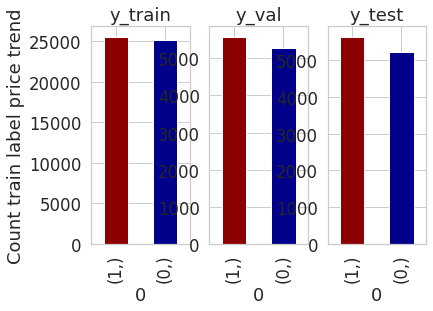

1    25596
0    25142
dtype: int64
1    5590
0    5282
dtype: int64
1    5641
0    5231
dtype: int64


In [ ]:
# plt.subplot(2,1,1)
plt.subplot(131)
value_counts1 = pd.DataFrame(y_train).value_counts()
value_counts1.plot.bar(color=['darkred','darkblue'], title = 'y_train')
plt.ylabel('Count train label price trend')
# plt.xticks([],[])

# plt.subplot(2,1,2)
plt.subplot(132)
value_counts2 = pd.DataFrame(y_val).value_counts()
value_counts2.plot.bar(color=['darkred','darkblue'], title = 'y_val')
# plt.ylabel('Count train label price trend')
# plt.xticks([],[])

plt.subplot(133)
value_counts3 = pd.DataFrame(y_test).value_counts()
value_counts3.plot.bar(color=['darkred','darkblue'], title = 'y_test')
# plt.ylabel('Count train label price trend')
# plt.xticks([],[])

plt.show()

print(value_counts1)
print(value_counts2)
print(value_counts3)

In [ ]:
# # # Randomoversampling
# from imblearn.over_sampling import RandomOverSampler
# # ros = RandomOverSampler()
# # X_resampled, y_resampled = ros.fit_sample(X, y)


# ros = RandomOverSampler(random_state=0)
# # X_train, y_train = ros.fit_sample(X_train[0].reshape(-1,1), y_train[0].reshape(-1,1))
# X_train, y_train = ros.fit_resample(X_train, y_train)

# display(pd.Series(y_train).value_counts())

In [ ]:
# print(sample(list1,3))

In [ ]:
# Before remove outlier => y_train = 17 , y_test = 3
# After remove outlier => y_train = 10 , y_test = 3

y_train_static = len(y_train[y_train == 0])
print(y_train_static)

y_test_static = len(y_test[y_test == 0])
print(y_test_static)
print('-'*100)
y_train_static = len(y_train[y_train == 1])
print(y_train_static)

y_test_static = len(y_test[y_test == 1])
print(y_test_static)
print('-'*100)
y_train_static = len(y_train[y_train == 2])
print(y_train_static)

y_test_static = len(y_test[y_test == 2])
print(y_test_static)

25142
5231
----------------------------------------------------------------------------------------------------
25596
5641
----------------------------------------------------------------------------------------------------
0
0


In [ ]:
# value_counts = y_train['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');
# value_counts = y_test['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');

In [ ]:
# X_train shape : (2469503, 7, 1)
# X_test shape : (274383, 7, 1)
# y_train shape : (2469503,)
# y_test shape : (274383,)

# X_train : 82318
# y_train : 82317
# X_test : 9147
# y_test : 9146

print(f'X_train : {X_train[:5]}')
print(f'y_train : {y_train[:5]}')
print(f'X_test : {X_test[:5]}')
print(f'y_test : {y_test[:5]}')
print('-'*100)
print(f'X_train : {X_train[:5][0]}')
# print(f'y_train : {y_train[:5][0]}')
print(f'X_test : {X_test[:5][0]}')
# print(f'y_test : {y_test[:5][0]}')
print('-'*100)
# print(f'X_train : {X_train[0]}')
# print(f'y_train : {y_train[82316:82318]}')
# print(f'X_test : {X_test[9145:9147]}')
# print(f'y_test : {y_test[9145:9147]}')
# # print('-'*100)

print(f'X_train : {type( X_train )}')
print(f'y_train : {type( y_train )}')
print(f'X_val : {type( X_val )}')
print(f'y_val : {type( y_val)}')
print(f'X_test : {type( X_test )}')
print(f'y_test : {type( y_test )}')
print('-'*100)
print(f'X_train[0] : {type( X_train[0] )}')
print(f'y_train[0] : {type( y_train[0] )}')
print(f'X_val[0] : {type( X_val[0] )}')
print(f'y_val[0] : {type( y_val[0] )}')
print(f'X_test[0] : {type( X_test[0] )}')
print(f'y_test[0] : {type( y_test[0] )}')
print('-'*100)
print(f'X_train[0][0] : {type( X_train[0][0] )}')
# print(f'y_train[0][0] : {type( y_train[0][0] )}')
print(f'X_val[0][0] : {type( X_val[0][0] )}')
# print(f'y_val[0][0] : {type( y_val[0][0] )}')
print(f'X_test[0][0] : {type( X_test[0][0] )}')
# print(f'y_test[0][0] : {type( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {type( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {type( y_train[0][0][0] )}')
# print(f'X_val[0][0][0] : {type( X_val[0][0][0] )}')
# print(f'y_val[0][0][0] : {type( y_val[0][0][0] )}')
# print(f'X_test[0][0][0] : {type( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {type( y_test[0][0][0] )}')
print('-'*100)
# print(f'X_train[0][0][0][0] : {type( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {type( y_train[0][0][0][0] )}')
# print(f'X_val[0][0][0][0] : {type( X_val[0][0][0][0] )}')
# print(f'y_val[0][0][0][0] : {type( y_val[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {type( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {type( y_test[0][0][0][0] )}')


print('-'*100)
print(f'X_train : {len( X_train )}')
print(f'y_train : {len( y_train )}')
print(f'X_val : {len( X_val )}')
print(f'y_val : {len( y_val )}')
print(f'X_test : {len( X_test )}')
print(f'y_test : {len( y_test )}')
print('-'*100)
print(f'X_train[0] : {len( X_train[0] )}')
# print(f'y_train[0] : {len( y_train[0] )}')
print(f'X_val[0] : {len( X_val[0] )}')
# print(f'y_val[0] : {len( y_val[0] )}')
print(f'X_test[0] : {len( X_test[0] )}')
# print(f'y_test[0] : {len( y_test[0] )}')
# print('-'*100)
# print(f'X_train[0][0] : {len( X_train[0][0] )}')
# # print(f'y_train[0][0] : {len( y_train[0][0] )}')
# print(f'X_test[0][0] : {len( X_test[0][0] )}')
# print(f'y_test[0][0] : {len( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {len( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {len( y_train[0][0][0] )}')
# print(f'X_test[0][0][0] : {len( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {len( y_test[0][0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0][0] : {len( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {len( y_train[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {len( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {len( y_test[0][0][0][0] )}')

print('-'*100)
print('X train data shape', X_train.shape)
print('y train label shape',y_train.shape) 
print('X val data shape', X_val.shape)
print('y val label shape',y_val.shape) 
print('X test data shape',X_test.shape)
print('y test label shape',y_test.shape)
print('-'*100)
print('X_train[0] data shape', X_train[0].shape)
print('y_train[0] label shape',y_train[0].shape)    
print('X_val[0] data shape', X_val[0].shape)
print('y_val[0] label shape',y_val[0].shape)    
print('X_test[0] data shape',X_test[0].shape)
print('y_test[0] label shape',y_test[0].shape)
print('-'*100)
print('X_train[0][0] data shape', X_train[0][0].shape)
# print('y train label shape',y_train[0][0].shape)   
print('X_val[0][0] data shape', X_val[0][0].shape)
# print('y val label shape',y_val[0][0].shape)   
print('X_test[0][0] data shape',X_test[0][0].shape)
# print('y test label shape',y_test[0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0].shape)
# print('y train label shape',y_train[0][0][0].shape)    
# print('X test data shape',X_test[0][0][0].shape)
# print('y test label shape',y_test[0][0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0][0].shape)
# print('y train label shape',y_train[0][0][0][0].shape)    
# print('X test data shape',X_test[0][0][0][0].shape)
# print('y test label shape',y_test[0][0][0][0].shape)

print('-'*100)
print('unique train label',np.unique(y_train))
print('unique val label',np.unique(y_val))
print('unique test label',np.unique(y_test))

X_train : [[0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277]
 [0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277]
 [0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0.06281277 0.06281277 0.06281277
  0.06281277 0.06281277 0.06281277 0

## **2.2.1 Walk foward No.1** 
1. split train 70% and test 15%. 
2. split train 85% and validation 15% in model

**Trend Prediction Classification for High Frequency Bitcoin Time Series with Deep Learning)**

- Remove oulier by |Rt| > α (Set threshold = 0.1) x => don't use in this case use isolation forest
- min-max normalization
- Create train test dataset by so-called walk forward optimization method (วิธีการเพิ่มประสิทธิภาพการเดินไปข้างหน้า : Dixon et al. 2017) which can deal with class imbalance (non-stationarity) 

1. Paper  
https://docs.google.com/document/d/1Bifkt5Lkohui3EudKIkER4y0w2_vWILv6bi013gPils/edit

2. Time_Series_data_preparation  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00c_Time_Series_data_preparation.ipynb#scrollTo=I79BWYUgwUzS  

3. TS_archs_comparison  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/05_TS_archs_comparison.ipynb  
  
4. 07_Time_Series_Classification_with_Transformers  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb

**Function**

In [ ]:
# # def normalise_zero_base(df):
# #     """ Normalise dataframe column-wise to reflect changes with respect to first entry.
# #         ปรับคอลัมน์ดาต้าเฟรมให้เป็นมาตรฐานเพื่อสะท้อนการเปลี่ยนแปลงที่เกี่ยวข้องกับรายการแรก
# #     """
# #     return df / df.iloc[0] - 1

# def normalise_min_max(df):
#     """ Feature Scaling min max Normalise dataframe column-wise min/max. """
#     return (df - df.min()) / (df.max() - df.min())

In [ ]:
# def extract_window_data(df, window=30, min_max=True):      #zero_base=True):
#     """ Convert dataframe to overlapping sequences/windows of length `window`.
#         แปลงดาต้าเฟรมเป็นลำดับที่ทับซ้อนกัน/หน้าต่างของหน้าต่างความยาว
#     """
#     X = []
#     y = []
#     window_mt_y = []
#     # for idx in range(len(df) - window):
#     #     tmp = df[idx: (idx + window)].copy()
#     #     if zero_base:
#     #         tmp = normalise_zero_base(tmp)
#     #     window_data.append(tmp.values)
#     # return np.array(window_data)

#     for idx in range( (len(df) // window) + 1 ):

#         tmp = df[ idx * window : ((idx * window) + window) ].copy()
#         # print(tmp)
#         # print(type(tmp))    # <class 'pandas.core.frame.DataFrame'>

#         window_tmp = tmp['close'].to_numpy()
#         mt = tmp.mean()

#         # if min_max:
#         #     # tmp = normalise_zero_base(tmp)
#         #     norm_min_max = normalise_min_max(df)
#         #     # print(norm_min_max)
#         #     # print(type(norm_min_max))   # <class 'pandas.core.frame.DataFrame'>

#         X.append(window_tmp)
#         window_mt_y.append(mt.values)

#     for i in range( (len(df) // window) ):
#         '''
#         target label => 1 = down trend, 2 = up trend, 0 = static  
#         in paper eth/usd plus + 0.24 Up and Down trend
#         '''
#         if ( window_mt_y[i][0] > window_mt_y[i+1][0] ):  # create down trend = 1
#             y.append(1)
#         elif ( window_mt_y[i][0] < window_mt_y[i+1][0] ):  # create up trend = 2
#             y.append(2)
#         else:        # create static trend = 2
#             y.append(2)


#     # window_data = window_data[0]
#     # window_data = window_data[:91463]
#     # window_mt = window_mt[:91463]

#     return np.array(X) , np.array(y)

In [ ]:
# # window = 30 min, window = 60 min = 1 hour, window = 1440 min = 1 day

# def prepare_data(df, window=30, min_max=True, test_size=0.1):   # zero_base=True , min_max=True
#     """ Prepare data for OS-CNN. """
#     # train test split
#     train_data, test_data = train_test_split(df, test_size)
    
#     # extract window data
#     X_train, y_train = extract_window_data(train_data, window, min_max)
#     X_test, y_test = extract_window_data(test_data, window, min_max)

#     return X_train, X_test, y_train, y_test

In [ ]:
# Normalization
# min-max normalization 
# https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
# https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

scaler = MinMaxScaler()
close_price = eth_closes.close.values.reshape(-1, 1)
eth_closes = scaler.fit_transform(close_price)
eth_closes = pd.DataFrame(eth_closes, columns = ['close'])

print(f'Head 10 : {eth_closes[:11]}')
print('-'*50)
print(f'Tail 10 : {eth_closes[2743890:]}')
print('-'*50)
print(f'Original  max price : {close_price.max()} min price : {close_price.min()}')
print('-'*50)
print(f'Min max normalization max price : {eth_closes.max()} min price : {eth_closes.min()}')
print('-'*50)
print(f'Shape dataset : {eth_closes.shape}')
print('-'*50)
print(f'Orginal close price : {close_price}')
print(type(close_price))
print('-'*50)
print(f'Min max normalization close price : {eth_closes}')
print(type(eth_closes))

Head 10 :        close
0   0.062211
1   0.062211
2   0.062211
3   0.062211
4   0.062211
5   0.062211
6   0.062211
7   0.062211
8   0.062211
9   0.062211
10  0.062211
--------------------------------------------------
Tail 10 : Empty DataFrame
Columns: [close]
Index: []
--------------------------------------------------
Original  max price : 3348.64 min price : 97.76
--------------------------------------------------
Min max normalization max price : close    1.0
dtype: float64 min price : close    0.0
dtype: float64
--------------------------------------------------
Shape dataset : (2174953, 1)
--------------------------------------------------
Orginal close price : [[ 300.  ]
 [ 300.  ]
 [ 300.  ]
 ...
 [2909.36]
 [2909.68]
 [2909.32]]
<class 'numpy.ndarray'>
--------------------------------------------------
Min max normalization close price :             close
0        0.062211
1        0.062211
2        0.062211
3        0.062211
4        0.062211
...           ...
2174948  0.86497

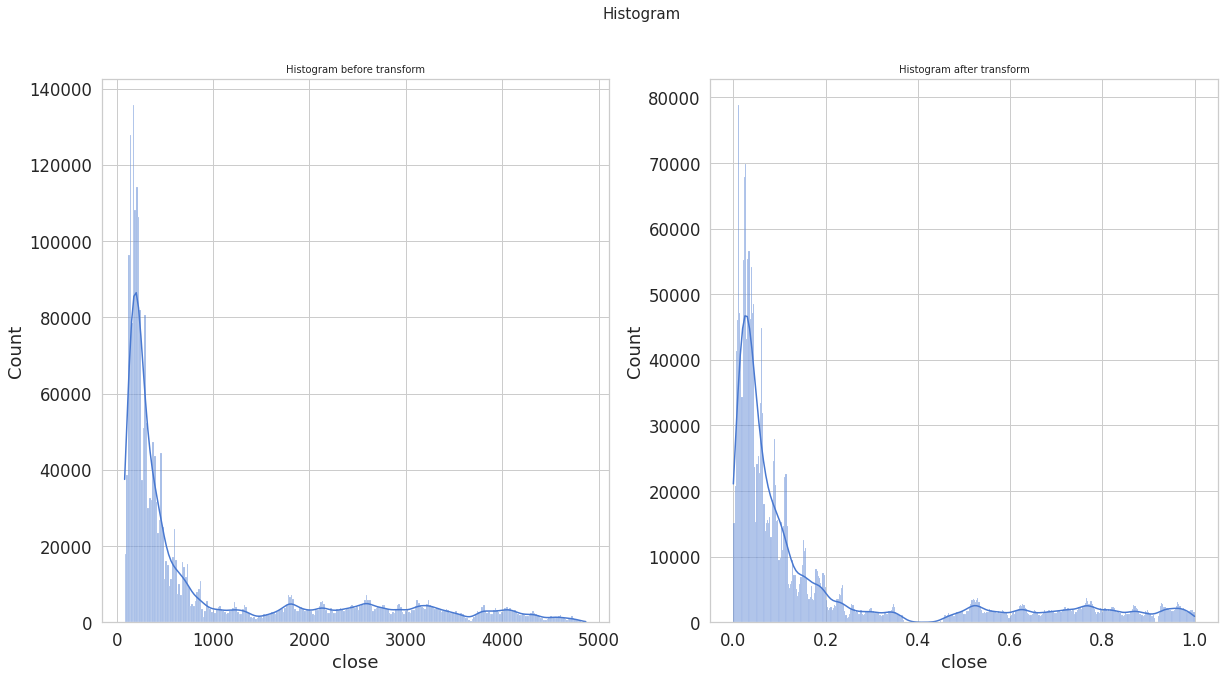

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Histogram', fontsize=15)

# Draw
sns.histplot(data=eth_close, x="close", kde=True, ax=axes[0])
sns.histplot(data=eth_closes, x="close", kde=True, ax=axes[1])

# Set Title
axes[0].set_title('Histogram before transform', fontsize=10)
axes[1].set_title('Histogram after transform', fontsize=10)

plt.show()

**The walk forward optimization approach for backtesting
a simple trading strategy.** 
file:///C:/Semester%204/BADS9000%20IS/Reference%20IS/so-called%20walk%20forward%20optimization%20method.pdf  
https://www.siamquant.com/walk-forward/  

   
ตามแนวทางการปรับให้เหมาะสมแบบก้าวไปข้างหน้าใน Tomasini และ Jaekle (2011) หน้าต่างการปรับให้เหมาะสมเริ่มต้น 25,000 ช่วงเวลาการสังเกต 5 นาทีหรือประมาณ 260 วัน (มากกว่าหนึ่งปีเล็กน้อย) จะถูกเลือกสำหรับการฝึกโมเดลโดยใช้ข้อมูลสัญลักษณ์ทั้งหมดและ อนุกรมเวลาที่ได้รับการออกแบบทางวิศวกรรม

learning rate  range ถูกกวาดเพื่อค้นหาแบบจำลองที่ให้อัตราการทำนายที่ไม่อยู่ในตัวอย่างที่ดีที่สุด (out-of-sample) - อัตราการจำแนกประเภทสูงสุดในชุดตัวอย่างที่ไม่อยู่ในกลุ่มตัวอย่าง ('hold-out') ซึ่งประกอบด้วยการสังเกตต่อเนื่องกัน 12,500 ครั้งและล่าสุด

จากนั้นใช้แบบจำลองที่ปรับให้เหมาะสม P&L ที่คาดหวังของกลยุทธ์การซื้อขายจะได้รับการประเมินในช่วงนอกช่วงตัวอย่างซึ่งประกอบด้วย 12,500 ช่วงเวลาการสังเกต 5 นาทีติดต่อกัน 12,500 หรือประมาณ 130 วัน

การ train model ขั้นตอนนี้ทำซ้ำโดยเลื่อนการ train
หน้าต่างไปข้างหน้า 1000 ช่วงเวลาสังเกต
และทำซ้ำการวิเคราะห์ข้อผิดพลาดที่ไม่อยู่ในตัวอย่าง
และการวัดประสิทธิภาพกลยุทธ์สำหรับสิบ
หน้าต่าง

In [ ]:
# Split test set 15%

test_data = eth_closes.iloc[ int(len(eth_closes)*0.85) : ]
train_val_data = eth_closes.iloc[ : int(len(eth_closes)*0.85) ]

In [ ]:
# Ref. : 1.https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a
#        2.https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn
#        3.http://thaiquants.com/vlog/walk-forward-analysis/

length = 10080
eth_lengthnum = 348

train_size =  0.823529411764706
val_size =  0.176470588235294
# train_size =  0.82
# val_size =  0.18

window = 30
split_indexs = []

X_train = []
X_val = []
X_test = []

window_mt_y_train = []
window_mt_y_val = []
window_mt_y_test = []

# find X test
for idx in range( (len(test_data) // window) + 1 ):    # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
    print(f'index test window : {idx}')
    tmp_test = test_data[idx * window : ((idx * window) + window)].copy() 
    # print(tmp_test)
    # print(type(tmp_test))    
    
    window_tmp_test = tmp_test['close'].to_numpy()   # <class 'numpy.ndarray'>
    # print(window_tmp_test)
    # print(type(window_tmp_test))  
    # print(window_tmp_test.shape)

    mt_test = tmp_test.mean()   # mean price in window 30 min. for find y classification

    X_test.append(window_tmp_test)
    # X_test.append(tmp_test.values)
    window_mt_y_test.append(mt_test.values)


# find X train & validation
for i in range(eth_lengthnum + 1):
    print(f'index length: {i}')

    if i == 0:  
        initial_index = 0
    else:
        initial_index = split_indexs[i-1]

    last_index = initial_index + length
    split_index = last_index - int(length * val_size)
    split_indexs.append(split_index)

    data_length = train_val_data.iloc[ initial_index : last_index ]

    # print('last_index', last_index)
    # print('initial_dex', initial_index)
    # print('split_index', split_index)
    # print('count data length', len(data_length))
    # print('Data length', data_length)
    
    train_data = data_length.iloc[ : int(length*train_size) ]
    val_data = data_length.iloc[ int(length*train_size) : ]
 
    # print('train_data', len(train_data))
    # print('val_data', len(val_data))
    # print('Type train_data', type(train_data))
    # print('Type val_data', type(val_data))
    
    
    # Create X_train
    # for idx in  range( int((len(data_length) // window)*0.7) + 1 ):   # eth train 70% = 0-235
    for idx in  range( int((len(data_length) // window) * train_size) ):   # eth train 70% = 0-235
        print(f'index train window : {idx}')

        tmp_train = train_data[idx * window : ((idx * window) + window)].copy()  # create array dimension window 30 min.  # <class 'pandas.core.frame.DataFrame'>
        # print(tmp_train)
        # print(type(tmp_train))    

        # window_tmp_train = tmp_train['close'].to_numpy()  # <class 'numpy.ndarray'>
        # window_tmp_train = np.asarray(tmp_train['close'].values.tolist())
        window_tmp_train = tmp_train['close'].values.tolist()
        # window_tmp_train = window_tmp_train.flatten()
        # print(window_tmp_train)
        print(type(window_tmp_train))  
        # print(window_tmp_train.shape)

        mt_train = tmp_train.mean().values   # mean price in window 30 min. for find y classification

        X_train.append(window_tmp_train)
        # X_train.append(tmp_train.values)
        window_mt_y_train.append(mt_train)


    # Create X_val
    # for idx in range( int((len(data_length) // window)*0.3)):   # eth train 30% = 0-100   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
    for idx in range( int((len(data_length) // window) * val_size) ):   # eth train 30% = 0-50   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
        print(f'index val window : {idx}')

        tmp_val = val_data[idx * window : ((idx * window) + window)].copy() 
        # print(tmp_val)
        # print(type(tmp_val))    
        
        # window_tmp_val = tmp_val['close'].to_numpy()   # <class 'numpy.ndarray'>
        # window_tmp_val = np.array(tmp_val['close'].values.tolist())
        window_tmp_val = tmp_val['close'].values.tolist()
        # print(window_tmp_val)
        print(type(window_tmp_val))  
        # print(window_tmp_val.shape)

        mt_val =  tmp_val.mean().values   # mean price in window 30 min. for find y classification

        X_val.append(window_tmp_val)
        # X_val.append(tmp_val.values)
        window_mt_y_val.append(mt_val)



Streaming output truncated to the last 5000 lines.
<class 'list'>
index train window : 99
<class 'list'>
index train window : 100
<class 'list'>
index train window : 101
<class 'list'>
index train window : 102
<class 'list'>
index train window : 103
<class 'list'>
index train window : 104
<class 'list'>
index train window : 105
<class 'list'>
index train window : 106
<class 'list'>
index train window : 107
<class 'list'>
index train window : 108
<class 'list'>
index train window : 109
<class 'list'>
index train window : 110
<class 'list'>
index train window : 111
<class 'list'>
index train window : 112
<class 'list'>
index train window : 113
<class 'list'>
index train window : 114
<class 'list'>
index train window : 115
<class 'list'>
index train window : 116
<class 'list'>
index train window : 117
<class 'list'>
index train window : 118
<class 'list'>
index train window : 119
<class 'list'>
index train window : 120
<class 'list'>
index train window : 121
<class 'list'>
index train win

In [ ]:
# class Sampler():
#     # ds = Dataset, bs = Batch Size, n = Length of Dataset
#     def __init__(self, ds, bs, shuffle=False):
#         self.n, self.bs, self.shuffle = len(ds), bs, shuffle
#     def __iter__(self):
#         self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
#         for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

# train_samp = Sampler(train_ds, bs, shuffle=True)
# valid_samp = Sampler(valid_ds, bs, shuffle=False)

# train_dl = data.DataLoader(train_ds, bs, sampler=data.RandomSampler(train_ds), collate_fn=collate, num_workers=8)
# valid_dl = data.DataLoader(valid_ds, bs, sampler=data.SequentialSampler(valid_ds), collate_fn=collate, num_workers=8)

In [ ]:
# find target trend label for trian validatoin => One hot encode
y_train = []
y_val = []
y_test = []

down_trend = 0
static_trend = 0
up_trend = 1

# find y train
for i in range( len(window_mt_y_train) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y train {i}')
    if ( window_mt_y_train[i][0] > window_mt_y_train[i+1][0] ):  # create down trend = 0
        y_train.append(down_trend)
        # X_train[i][0].append(down_trend)
    elif ( window_mt_y_train[i][0] < window_mt_y_train[i+1][0] ):  # create up trend = 1
        y_train.append(up_trend)
        # X_train[i][0].append(up_trend)
    else:         # create static trend = 0
        y_train.append(static_trend)
        # X_train[i].append(static_trend)

# find y validation
for i in range( len(window_mt_y_val) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y validation {i}')
    if ( window_mt_y_val[i][0] > window_mt_y_val[i+1][0] ):    # create down trend = 0
        y_val.append(down_trend)
        # X_val[i].append(down_trend)
    elif ( window_mt_y_val[i][0] < window_mt_y_val[i+1][0] ):   # create up trend = 1
        y_val.append(up_trend)
        # X_val[i].append(up_trend)
    else:         # create static trend = 0
        y_val.append(static_trend)
        # X_val[i].append(static_trend)

# find y test
for i in range( len(window_mt_y_test) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y test {i}')
    if ( window_mt_y_test[i][0] > window_mt_y_test[i+1][0] ):    # create down trend = 0
        y_test.append(down_trend)
        # X_test[i].append(down_trend)
    elif ( window_mt_y_test[i][0] < window_mt_y_test[i+1][0] ):   # create up trend = 1
        y_test.append(up_trend)
        # X_test[i].append(up_trend)
    else:         # create static trend = 0
        y_test.append(static_trend)
        # X_test[i].append(static_trend)


Streaming output truncated to the last 5000 lines.
index y test 5874
index y test 5875
index y test 5876
index y test 5877
index y test 5878
index y test 5879
index y test 5880
index y test 5881
index y test 5882
index y test 5883
index y test 5884
index y test 5885
index y test 5886
index y test 5887
index y test 5888
index y test 5889
index y test 5890
index y test 5891
index y test 5892
index y test 5893
index y test 5894
index y test 5895
index y test 5896
index y test 5897
index y test 5898
index y test 5899
index y test 5900
index y test 5901
index y test 5902
index y test 5903
index y test 5904
index y test 5905
index y test 5906
index y test 5907
index y test 5908
index y test 5909
index y test 5910
index y test 5911
index y test 5912
index y test 5913
index y test 5914
index y test 5915
index y test 5916
index y test 5917
index y test 5918
index y test 5919
index y test 5920
index y test 5921
index y test 5922
index y test 5923
index y test 5924
index y test 5925
index y test 

In [ ]:
print(f'len(X_train) : {len(X_train)}')
print(f'len(X_test) : {len(X_test)}')
print(f'len(X_val) : {len(X_val)}')

print(f'X_train[82108] : {X_train[61425:]}')
print(f'X_test[12353] : {X_test[10874:]}')
print(f'X_val[12353] : {X_val[13098:]}')   # 30

print(len(X_val[13098:]))

len(X_train) : 61426
len(X_test) : 10875
len(X_val) : 13131
X_train[82108] : [[0.4976960084654002, 0.4973422580962693, 0.4973791711782656, 0.49716692095678716, 0.49739147553893104, 0.49739147553893104, 0.49840043311349547, 0.49863421596613844, 0.4986188355153067, 0.49872649867112906, 0.49921559700757956, 0.4993048036224038, 0.4988679988187814, 0.5003106851068019, 0.5001107392459888, 0.49955704301604487, 0.499427847229058, 0.4994093906880599, 0.4997631410571908, 0.49979697804902057, 0.4995785756472094, 0.4992125209174132, 0.4989879663352693, 0.4989879663352693, 0.49867728122846744, 0.49847118318732164, 0.49840043311349547, 0.49840043311349547, 0.49876341175312533, 0.49876956393345806]]
X_test[12353] : [array([0.86738052, 0.86814647, 0.86814647, 0.86916158, 0.86806034,
       0.8672421 , 0.86771582, 0.86756817, 0.8666638 , 0.86576558,
       0.86606088, 0.86646693, 0.86646693, 0.86493503, 0.86499655,
       0.86563331, 0.86563331, 0.86507038, 0.86497195, 0.86528571,
       0.86487351, 0.

In [ ]:
X_train = np.array(X_train[:len(X_train) - 2])
X_test = np.array(X_test[:len(X_test) - 2])
X_val = np.array(X_val[:len(X_val) - 34])    # 30

y_train = np.array(y_train[:len(y_train) - 1])
y_test = np.array(y_test[:len(y_test) - 1])
y_val = np.array(y_val[:len(y_val) - 33])

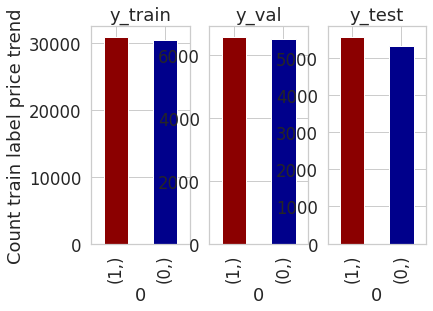

1    30999
0    30425
dtype: int64
1    6586
0    6511
dtype: int64
1    5566
0    5307
dtype: int64


In [ ]:
# plt.subplot(2,1,1)
plt.subplot(131)
value_counts1 = pd.DataFrame(y_train).value_counts()
value_counts1.plot.bar(color=['darkred','darkblue'], title = 'y_train')
plt.ylabel('Count train label price trend')
# plt.xticks([],[])

# plt.subplot(2,1,2)
plt.subplot(132)
value_counts2 = pd.DataFrame(y_val).value_counts()
value_counts2.plot.bar(color=['darkred','darkblue'], title = 'y_val')
# plt.ylabel('Count train label price trend')
# plt.xticks([],[])

plt.subplot(133)
value_counts3 = pd.DataFrame(y_test).value_counts()
value_counts3.plot.bar(color=['darkred','darkblue'], title = 'y_test')
# plt.ylabel('Count train label price trend')
# plt.xticks([],[])

plt.show()

print(value_counts1)
print(value_counts2)
print(value_counts3)

**Random sampling Method**  
Köknar-Tezel and Latecki63 proposed a supervised learning-based oversampling approach that creates and puts synthetic instances into distance space directly. This strategy is very useful for data where general distance measures cannot be used and so SMOTE cannot be applied, for example, time series. Then, they used SVM for classification. This approach performed good on such cases.

Ref. : https://journals.sagepub.com/doi/10.1177/1550147720916404



In [ ]:
# # # Randomoversampling
# from imblearn.over_sampling import RandomOverSampler
# # ros = RandomOverSampler()
# # X_resampled, y_resampled = ros.fit_sample(X, y)


# ros = RandomOverSampler(random_state=0)
# # X_train, y_train = ros.fit_sample(X_train[0].reshape(-1,1), y_train[0].reshape(-1,1))
# X_train, y_train = ros.fit_resample(X_train, y_train)

# display(pd.Series(y_train).value_counts())

In [ ]:
# value_counts = y_train['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');
# value_counts = y_test['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');

In [ ]:
# X_train shape : (2469503, 7, 1)
# X_test shape : (274383, 7, 1)
# y_train shape : (2469503,)
# y_test shape : (274383,)

# X_train : 82318
# y_train : 82317
# X_test : 9147
# y_test : 9146

print(f'X_train : {X_train[:5]}')
print(f'y_train : {y_train[:5]}')
print(f'X_test : {X_test[:5]}')
print(f'y_test : {y_test[:5]}')
print('-'*100)
print(f'X_train : {X_train[:5][0]}')
# print(f'y_train : {y_train[:5][0]}')
print(f'X_test : {X_test[:5][0]}')
# print(f'y_test : {y_test[:5][0]}')
print('-'*100)
# print(f'X_train : {X_train[0]}')
# print(f'y_train : {y_train[82316:82318]}')
# print(f'X_test : {X_test[9145:9147]}')
# print(f'y_test : {y_test[9145:9147]}')
# # print('-'*100)

print(f'X_train : {type( X_train )}')
print(f'y_train : {type( y_train )}')
print(f'X_val : {type( X_val )}')
print(f'y_val : {type( y_val)}')
print(f'X_test : {type( X_test )}')
print(f'y_test : {type( y_test )}')
print('-'*100)
print(f'X_train[0] : {type( X_train[0] )}')
print(f'y_train[0] : {type( y_train[0] )}')
print(f'X_val[0] : {type( X_val[0] )}')
print(f'y_val[0] : {type( y_val[0] )}')
print(f'X_test[0] : {type( X_test[0] )}')
print(f'y_test[0] : {type( y_test[0] )}')
print('-'*100)
print(f'X_train[0][0] : {type( X_train[0][0] )}')
# print(f'y_train[0][0] : {type( y_train[0][0] )}')
print(f'X_val[0][0] : {type( X_val[0][0] )}')
# print(f'y_val[0][0] : {type( y_val[0][0] )}')
print(f'X_test[0][0] : {type( X_test[0][0] )}')
# print(f'y_test[0][0] : {type( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {type( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {type( y_train[0][0][0] )}')
# print(f'X_val[0][0][0] : {type( X_val[0][0][0] )}')
# print(f'y_val[0][0][0] : {type( y_val[0][0][0] )}')
# print(f'X_test[0][0][0] : {type( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {type( y_test[0][0][0] )}')
print('-'*100)
# print(f'X_train[0][0][0][0] : {type( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {type( y_train[0][0][0][0] )}')
# print(f'X_val[0][0][0][0] : {type( X_val[0][0][0][0] )}')
# print(f'y_val[0][0][0][0] : {type( y_val[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {type( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {type( y_test[0][0][0][0] )}')


print('-'*100)
print(f'X_train : {len( X_train )}')
print(f'y_train : {len( y_train )}')
print(f'X_val : {len( X_val )}')
print(f'y_val : {len( y_val )}')
print(f'X_test : {len( X_test )}')
print(f'y_test : {len( y_test )}')
print('-'*100)
print(f'X_train[0] : {len( X_train[0] )}')
# print(f'y_train[0] : {len( y_train[0] )}')
print(f'X_val[0] : {len( X_val[0] )}')
# print(f'y_val[0] : {len( y_val[0] )}')
print(f'X_test[0] : {len( X_test[0] )}')
# print(f'y_test[0] : {len( y_test[0] )}')
# print('-'*100)
# print(f'X_train[0][0] : {len( X_train[0][0] )}')
# # print(f'y_train[0][0] : {len( y_train[0][0] )}')
# print(f'X_test[0][0] : {len( X_test[0][0] )}')
# print(f'y_test[0][0] : {len( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {len( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {len( y_train[0][0][0] )}')
# print(f'X_test[0][0][0] : {len( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {len( y_test[0][0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0][0] : {len( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {len( y_train[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {len( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {len( y_test[0][0][0][0] )}')

print('-'*100)
print('X train data shape', X_train.shape)
print('y train label shape',y_train.shape) 
print('X val data shape', X_val.shape)
print('y val label shape',y_val.shape) 
print('X test data shape',X_test.shape)
print('y test label shape',y_test.shape)
print('-'*100)
print('X_train[0] data shape', X_train[0].shape)
print('y_train[0] label shape',y_train[0].shape)    
print('X_val[0] data shape', X_val[0].shape)
print('y_val[0] label shape',y_val[0].shape)    
print('X_test[0] data shape',X_test[0].shape)
print('y_test[0] label shape',y_test[0].shape)
print('-'*100)
print('X_train[0][0] data shape', X_train[0][0].shape)
# print('y train label shape',y_train[0][0].shape)   
print('X_val[0][0] data shape', X_val[0][0].shape)
# print('y val label shape',y_val[0][0].shape)   
print('X_test[0][0] data shape',X_test[0][0].shape)
# print('y test label shape',y_test[0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0].shape)
# print('y train label shape',y_train[0][0][0].shape)    
# print('X test data shape',X_test[0][0][0].shape)
# print('y test label shape',y_test[0][0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0][0].shape)
# print('y train label shape',y_train[0][0][0][0].shape)    
# print('X test data shape',X_test[0][0][0][0].shape)
# print('y test label shape',y_test[0][0][0][0].shape)

print('-'*100)
print('unique train label',np.unique(y_train))
print('unique val label',np.unique(y_val))
print('unique test label',np.unique(y_test))

X_train : [[0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085]
 [0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085]
 [0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0.06221085 0.06221085 0.06221085
  0.06221085 0.06221085 0.06221085 0

## **2.2.2 Walk foward No.2**   

1. split train 70%, test 15% and validation 15% in model

**Trend Prediction Classification for High Frequency Bitcoin Time Series with Deep Learning)**

- Remove oulier by |Rt| > α (Set threshold = 0.1) x => don't use in this case use isolation forest
- min-max normalization
- Create train test dataset by so-called walk forward optimization method (วิธีการเพิ่มประสิทธิภาพการเดินไปข้างหน้า : Dixon et al. 2017) which can deal with class imbalance (non-stationarity) 

1. Paper  
https://docs.google.com/document/d/1Bifkt5Lkohui3EudKIkER4y0w2_vWILv6bi013gPils/edit

2. Time_Series_data_preparation  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00c_Time_Series_data_preparation.ipynb#scrollTo=I79BWYUgwUzS  

3. TS_archs_comparison  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/05_TS_archs_comparison.ipynb  
  
4. 07_Time_Series_Classification_with_Transformers  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb

**Function**

In [ ]:
# # def normalise_zero_base(df):
# #     """ Normalise dataframe column-wise to reflect changes with respect to first entry.
# #         ปรับคอลัมน์ดาต้าเฟรมให้เป็นมาตรฐานเพื่อสะท้อนการเปลี่ยนแปลงที่เกี่ยวข้องกับรายการแรก
# #     """
# #     return df / df.iloc[0] - 1

# def normalise_min_max(df):
#     """ Feature Scaling min max Normalise dataframe column-wise min/max. """
#     return (df - df.min()) / (df.max() - df.min())

In [ ]:
# def extract_window_data(df, window=30, min_max=True):      #zero_base=True):
#     """ Convert dataframe to overlapping sequences/windows of length `window`.
#         แปลงดาต้าเฟรมเป็นลำดับที่ทับซ้อนกัน/หน้าต่างของหน้าต่างความยาว
#     """
#     X = []
#     y = []
#     window_mt_y = []
#     # for idx in range(len(df) - window):
#     #     tmp = df[idx: (idx + window)].copy()
#     #     if zero_base:
#     #         tmp = normalise_zero_base(tmp)
#     #     window_data.append(tmp.values)
#     # return np.array(window_data)

#     for idx in range( (len(df) // window) + 1 ):

#         tmp = df[ idx * window : ((idx * window) + window) ].copy()
#         # print(tmp)
#         # print(type(tmp))    # <class 'pandas.core.frame.DataFrame'>

#         window_tmp = tmp['close'].to_numpy()
#         mt = tmp.mean()

#         # if min_max:
#         #     # tmp = normalise_zero_base(tmp)
#         #     norm_min_max = normalise_min_max(df)
#         #     # print(norm_min_max)
#         #     # print(type(norm_min_max))   # <class 'pandas.core.frame.DataFrame'>

#         X.append(window_tmp)
#         window_mt_y.append(mt.values)

#     for i in range( (len(df) // window) ):
#         '''
#         target label => 1 = down trend, 2 = up trend, 0 = static  
#         in paper eth/usd plus + 0.24 Up and Down trend
#         '''
#         if ( window_mt_y[i][0] > window_mt_y[i+1][0] ):  # create down trend = 1
#             y.append(1)
#         elif ( window_mt_y[i][0] < window_mt_y[i+1][0] ):  # create up trend = 2
#             y.append(2)
#         else:        # create static trend = 2
#             y.append(2)


#     # window_data = window_data[0]
#     # window_data = window_data[:91463]
#     # window_mt = window_mt[:91463]

#     return np.array(X) , np.array(y)

In [ ]:
# # window = 30 min, window = 60 min = 1 hour, window = 1440 min = 1 day

# def prepare_data(df, window=30, min_max=True, test_size=0.1):   # zero_base=True , min_max=True
#     """ Prepare data for OS-CNN. """
#     # train test split
#     train_data, test_data = train_test_split(df, test_size)
    
#     # extract window data
#     X_train, y_train = extract_window_data(train_data, window, min_max)
#     X_test, y_test = extract_window_data(test_data, window, min_max)

#     return X_train, X_test, y_train, y_test

In [ ]:
# Normalization
# min-max normalization 
# https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
# https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

scaler = MinMaxScaler()
close_price = eth_closes.close.values.reshape(-1, 1)
eth_closes = scaler.fit_transform(close_price)
eth_closes = pd.DataFrame(eth_closes, columns = ['close'])

print(f'Head 10 : {eth_closes[:11]}')
print('-'*50)
print(f'Tail 10 : {eth_closes[2743890:]}')
print('-'*50)
print(f'Original  max price : {close_price.max()} min price : {close_price.min()}')
print('-'*50)
print(f'Min max normalization max price : {eth_closes.max()} min price : {eth_closes.min()}')
print('-'*50)
print(f'Shape dataset : {eth_closes.shape}')
print('-'*50)
print(f'Orginal close price : {close_price}')
print(type(close_price))
print('-'*50)
print(f'Min max normalization close price : {eth_closes}')
print(type(eth_closes))

Head 10 :        close
0   0.063488
1   0.063488
2   0.063488
3   0.063488
4   0.063488
5   0.063488
6   0.063488
7   0.063488
8   0.063488
9   0.063488
10  0.063488
--------------------------------------------------
Tail 10 : Empty DataFrame
Columns: [close]
Index: []
--------------------------------------------------
Original  max price : 3340.47 min price : 93.88
--------------------------------------------------
Min max normalization max price : close    1.0
dtype: float64 min price : close    0.0
dtype: float64
--------------------------------------------------
Shape dataset : (2175055, 1)
--------------------------------------------------
Orginal close price : [[ 300.  ]
 [ 300.  ]
 [ 300.  ]
 ...
 [2909.36]
 [2909.68]
 [2909.32]]
<class 'numpy.ndarray'>
--------------------------------------------------
Min max normalization close price :             close
0        0.063488
1        0.063488
2        0.063488
3        0.063488
4        0.063488
...           ...
2175050  0.86731

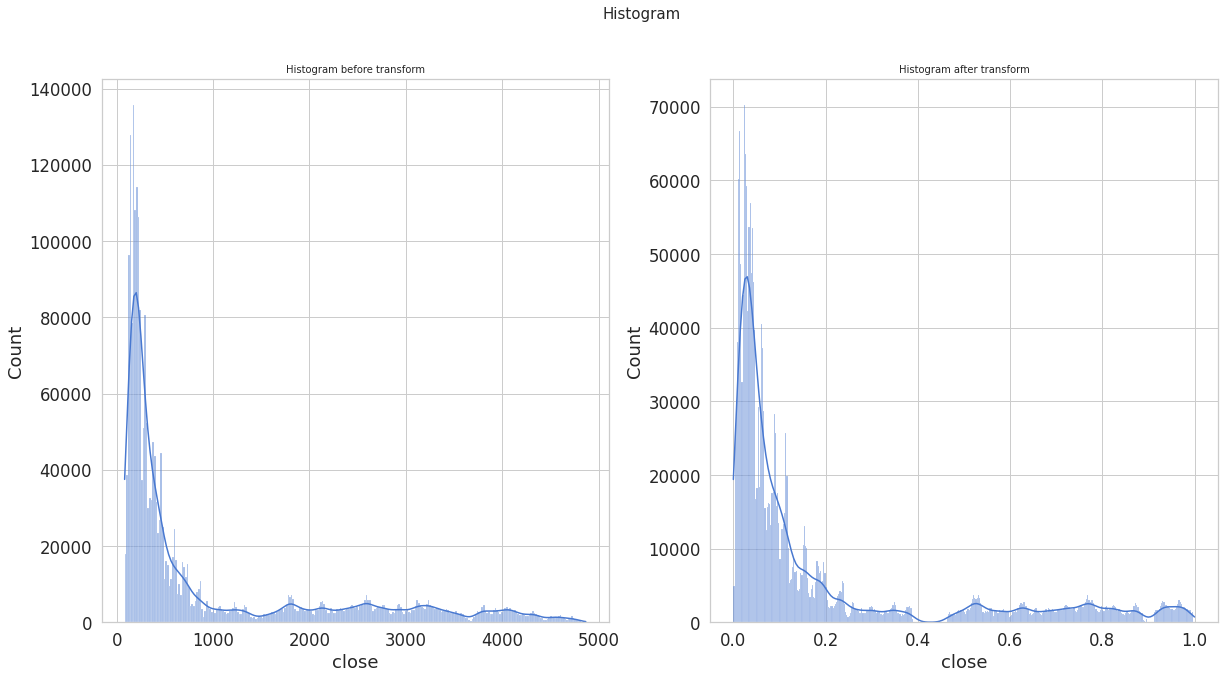

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Histogram', fontsize=15)

# Draw
sns.histplot(data=eth_close, x="close", kde=True, ax=axes[0])

sns.histplot(data=eth_closes, x="close", kde=True, ax=axes[1])

# Set Title
axes[0].set_title('Histogram before transform', fontsize=10)
axes[1].set_title('Histogram after transform', fontsize=10)

plt.show()

**The walk forward optimization approach for backtesting
a simple trading strategy.** 
file:///C:/Semester%204/BADS9000%20IS/Reference%20IS/so-called%20walk%20forward%20optimization%20method.pdf  
https://www.siamquant.com/walk-forward/  

   
ตามแนวทางการปรับให้เหมาะสมแบบก้าวไปข้างหน้าใน Tomasini และ Jaekle (2011) หน้าต่างการปรับให้เหมาะสมเริ่มต้น 25,000 ช่วงเวลาการสังเกต 5 นาทีหรือประมาณ 260 วัน (มากกว่าหนึ่งปีเล็กน้อย) จะถูกเลือกสำหรับการฝึกโมเดลโดยใช้ข้อมูลสัญลักษณ์ทั้งหมดและ อนุกรมเวลาที่ได้รับการออกแบบทางวิศวกรรม

learning rate  range ถูกกวาดเพื่อค้นหาแบบจำลองที่ให้อัตราการทำนายที่ไม่อยู่ในตัวอย่างที่ดีที่สุด (out-of-sample) - อัตราการจำแนกประเภทสูงสุดในชุดตัวอย่างที่ไม่อยู่ในกลุ่มตัวอย่าง ('hold-out') ซึ่งประกอบด้วยการสังเกตต่อเนื่องกัน 12,500 ครั้งและล่าสุด

จากนั้นใช้แบบจำลองที่ปรับให้เหมาะสม P&L ที่คาดหวังของกลยุทธ์การซื้อขายจะได้รับการประเมินในช่วงนอกช่วงตัวอย่างซึ่งประกอบด้วย 12,500 ช่วงเวลาการสังเกต 5 นาทีติดต่อกัน 12,500 หรือประมาณ 130 วัน

การ train model ขั้นตอนนี้ทำซ้ำโดยเลื่อนการ train
หน้าต่างไปข้างหน้า 1000 ช่วงเวลาสังเกต
และทำซ้ำการวิเคราะห์ข้อผิดพลาดที่ไม่อยู่ในตัวอย่าง
และการวัดประสิทธิภาพกลยุทธ์สำหรับสิบ
หน้าต่าง

In [ ]:
# Ref. : 1.https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a
#        2.https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn
#        3.http://thaiquants.com/vlog/walk-forward-analysis/

length = 10080
eth_lengthnum = 348

# test_size = 0.3
train_size = 0.7
test_size = 0.15
val_size = 0.15

window = 30
split_indexs = []

X_train = []
X_test = []
X_val = []

window_mt_y_train = []
window_mt_y_test = []
window_mt_y_val = []

for i in range(eth_lengthnum + 1):
    print(f'index length: {i}')

    if i == 0:  
        initial_index = 0
    else:
        initial_index = split_indexs[i-1]

    last_index = initial_index + length
    split_index = last_index - int(length*test_size)
    split_indexs.append(split_index)

    data_length = eth_closes.iloc[ initial_index : last_index ]

    # print('last_index', last_index)
    # print('initial_dex', initial_index)
    # print('split_index', split_index)
    # print('count data length', len(data_length))
    # print('Data length', data_length)
    
    train_data = data_length.iloc[ : int(length*train_size) ]
    test_val_data = data_length.iloc[ int(length*train_size) : ]

    val_data = test_val_data.iloc[ : int(length*test_size)]
    test_data = test_val_data.iloc[ int(length*test_size) : ]

    # print('train_data', len(train_data))
    # print('test_data', len(test_data))
    # print('Type train_data', type(train_data))
    # print('Type test_data', type(test_data))

    # Create X_train
    # for idx in  range( int((len(data_length) // window)*0.7) + 1 ):   # eth train 70% = 0-235
    for idx in  range( int((len(data_length) // window)*train_size)):   # eth train 70% = 0-235
        print(f'index train window : {idx}')

        tmp_train = train_data[idx * window : ((idx * window) + window)].copy()  # create array dimension window 30 min.  # <class 'pandas.core.frame.DataFrame'>
        # print(tmp_train)
        # print(type(tmp_train))

        # window_tmp_train = tmp_train['close'].to_numpy()  # <class 'numpy.ndarray'>
        # window_tmp_train = np.asarray(tmp_train['close'].values.tolist())
        window_tmp_train = tmp_train['close'].values.tolist()
        # window_tmp_train = window_tmp_train.flatten()
        # print(window_tmp_train)
        # print(type(window_tmp_train))  
        # print(window_tmp_train.shape)

        mt_train = tmp_train.mean().values   # mean price in window 30 min. for find y classification

        X_train.append(window_tmp_train)
        # X_train.append(tmp_train.values)
        window_mt_y_train.append(mt_train)

    # Create X_test
    # for idx in range( int((len(data_length) // window)*0.3)):   # eth train 30% = 0-100   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
    for idx in range( int((len(data_length) // window)*test_size)):   # eth train 30% = 0-50   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
        print(f'index test window : {idx}')

        tmp_test =  test_data[idx * window : ((idx * window) + window)].copy() 
        # print(tmp_test)
        # print(type(tmp_test))    
        
        # window_tmp_test = tmp_test['close'].to_numpy()   # <class 'numpy.ndarray'>
        # window_tmp_test = np.asarray(tmp_test['close'].values.tolist())
        window_tmp_test = tmp_test['close'].values.tolist()
        # print(window_tmp_test)
        # print(type(window_tmp_test))  
        # print(window_tmp_test.shape)

        mt_test =  tmp_test.mean().values   # mean price in window 30 min. for find y classification

        X_test.append(window_tmp_test)
        # X_test_test.append(tmp_test.values)
        window_mt_y_test.append(mt_test)

    # Create X_validation
    # for idx in range( int((len(data_length) // window)*0.3)):   # eth train 30% = 0-100   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
    for idx in range( int((len(data_length) // window)*val_size)):   # eth train 30% = 0-50   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
        print(f'index validation window : {idx}')

        tmp_val = val_data[idx * window : ((idx * window) + window)].copy() 
        # print(tmp_val)
        # print(type(tmp_val))    
        
        window_tmp_val = tmp_val['close'].values.tolist()
        # print(window_tmp_val)
        # print(type(window_tmp_val))  
        # print(window_tmp_val.shape)

        mt_val =  tmp_val.mean().values   # mean price in window 30 min. for find y classification

        X_val.append(window_tmp_val)
        # X_test_test.append(tmp_val.values)
        window_mt_y_val.append(mt_val)


Streaming output truncated to the last 5000 lines.
index train window : 42
index train window : 43
index train window : 44
index train window : 45
index train window : 46
index train window : 47
index train window : 48
index train window : 49
index train window : 50
index train window : 51
index train window : 52
index train window : 53
index train window : 54
index train window : 55
index train window : 56
index train window : 57
index train window : 58
index train window : 59
index train window : 60
index train window : 61
index train window : 62
index train window : 63
index train window : 64
index train window : 65
index train window : 66
index train window : 67
index train window : 68
index train window : 69
index train window : 70
index train window : 71
index train window : 72
index train window : 73
index train window : 74
index train window : 75
index train window : 76
index train window : 77
index train window : 78
index train window : 79
index train window : 80
index train w

In [ ]:
# class Sampler():
#     # ds = Dataset, bs = Batch Size, n = Length of Dataset
#     def __init__(self, ds, bs, shuffle=False):
#         self.n, self.bs, self.shuffle = len(ds), bs, shuffle
#     def __iter__(self):
#         self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
#         for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

# train_samp = Sampler(train_ds, bs, shuffle=True)
# valid_samp = Sampler(valid_ds, bs, shuffle=False)

# train_dl = data.DataLoader(train_ds, bs, sampler=data.RandomSampler(train_ds), collate_fn=collate, num_workers=8)
# valid_dl = data.DataLoader(valid_ds, bs, sampler=data.SequentialSampler(valid_ds), collate_fn=collate, num_workers=8)

In [ ]:
# find target trend label for trian test => One hot encode
y_train = []
y_test = []
y_val = []

down_trend = 0
static_trend = 0
up_trend = 1

# find y train
for i in range( len(window_mt_y_train) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y train {i}')
    if ( window_mt_y_train[i][0] > window_mt_y_train[i+1][0] ):  # create down trend = 0
        y_train.append(down_trend)
        # X_train[i][0].append(down_trend)
    elif ( window_mt_y_train[i][0] < window_mt_y_train[i+1][0] ):  # create up trend = 1
        y_train.append(up_trend)
        # X_train[i][0].append(up_trend)
    else:         # create static trend = 0
        y_train.append(static_trend)
        # X_train[i].append(static_trend)

# find y validation
for i in range( len(window_mt_y_val) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y validation {i}')
    if ( window_mt_y_val[i][0] > window_mt_y_val[i+1][0] ):    # create down trend = 0
        y_val.append(down_trend)
        # X_test[i].append(down_trend)
    elif ( window_mt_y_val[i][0] < window_mt_y_val[i+1][0] ):   # create up trend = 1
        y_val.append(up_trend)
        # X_test[i].append(up_trend)
    else:         # create static trend = 0
        y_val.append(static_trend)
        # X_test[i].append(static_trend)

# find y test
for i in range( len(window_mt_y_test) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(f'index y test {i}')
    if ( window_mt_y_test[i][0] > window_mt_y_test[i+1][0] ):    # create down trend = 0
        y_test.append(down_trend)
        # X_test[i].append(down_trend)
    elif ( window_mt_y_test[i][0] < window_mt_y_test[i+1][0] ):   # create up trend = 1
        y_test.append(up_trend)
        # X_test[i].append(up_trend)
    else:         # create static trend = 0
        y_test.append(static_trend)
        # X_test[i].append(static_trend)

Streaming output truncated to the last 5000 lines.
index y test 7685
index y test 7686
index y test 7687
index y test 7688
index y test 7689
index y test 7690
index y test 7691
index y test 7692
index y test 7693
index y test 7694
index y test 7695
index y test 7696
index y test 7697
index y test 7698
index y test 7699
index y test 7700
index y test 7701
index y test 7702
index y test 7703
index y test 7704
index y test 7705
index y test 7706
index y test 7707
index y test 7708
index y test 7709
index y test 7710
index y test 7711
index y test 7712
index y test 7713
index y test 7714
index y test 7715
index y test 7716
index y test 7717
index y test 7718
index y test 7719
index y test 7720
index y test 7721
index y test 7722
index y test 7723
index y test 7724
index y test 7725
index y test 7726
index y test 7727
index y test 7728
index y test 7729
index y test 7730
index y test 7731
index y test 7732
index y test 7733
index y test 7734
index y test 7735
index y test 7736
index y test 

In [ ]:
print(f'len(X_train) : {len(X_train)}')
print(f'len(X_test) : {len(X_test)}')
print(f'len(X_val) : {len(X_val)}')

print(f'X_train : {X_train[59625:]}')
print(f'X_test : {X_test[12650:]}')  #11
print(f'X_val : {X_val[12660:]}')   #11

print(len(X_test[12650:]))
print(len(X_val[12660:]))

len(X_train) : 59626
len(X_test) : 12686
len(X_val) : 12686
X_train : [[0.8733563523573966, 0.8703193196553923, 0.8668171835679899, 0.8629608296705159, 0.8682556158923672, 0.8682556158923672, 0.8672576457144268, 0.8672576457144268, 0.8689270896540678, 0.8684003831712659, 0.8689394102735486, 0.8697063688362252, 0.8696139641901196, 0.871021594965795, 0.8709969537268335, 0.870855266602805, 0.8705503312706564, 0.8706766176203341, 0.8687977231495202, 0.8688408453177028, 0.869272066999529, 0.869934300296619, 0.869934300296619, 0.869734090230057, 0.8696478458936917, 0.8699989835488929, 0.8700544263365564, 0.8687207192777655, 0.8687207192777655, 0.8677042681706038]]
X_test : [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
X_val : [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
36
26


In [ ]:
X_train = np.array(X_train[:len(X_train) - 2])
X_test = np.array(X_test[:len(X_test) - 37])
X_val = np.array(X_val[:len(X_val) - 27])

y_train = np.array(y_train[:len(y_train) - 1])
y_test = np.array(y_test[:len(y_test) - 36])
y_val = np.array(y_val[:len(y_val) - 26])

In [ ]:
# print(f'X_train[:5] : {X_train[:5]}')
# print(f'X_val[:5] : {X_val[:5]}')
# print(f'X_test[:5] : {X_test[:5]}')
# print('='*100)
# print(f'X_train[67720:] : {X_train[67720:]}')
# print(f'X_val[14405:] : {X_val[14390:]}')   #15
# print(f'X_test[14405:] : {X_test[14390:]}')  #15

print(len(X_train))
# print(len(X_train[0]))
print(len(X_test))
# print(len(X_test[0]))
print(len(X_val))
# print(len(X_val[0]))

print('-'*100)
print(len(y_train))
print(len(y_test))
print(len(y_val))
print(f'y_train[:5] : {y_train[:5]}')
print(f'y_val[:5] : {y_val[:5]}')
print(f'y_test[:5] : {y_test[:5]}')
print('='*100)
print(f'y_train[67720:] : {y_train[67741:]}')
print(f'y_val[14405:] : {y_val[14388:]}')
print(f'y_test[14405:] : {y_test[14388:]}')
# 14398
# 14398

59624
12649
12659
----------------------------------------------------------------------------------------------------
59624
12649
12659
y_train[:5] : [0 0 0 0 0]
y_val[:5] : [1 1 1 1 1]
y_test[:5] : [1 1 1 0 1]
y_train[67720:] : []
y_val[14405:] : []
y_test[14405:] : []


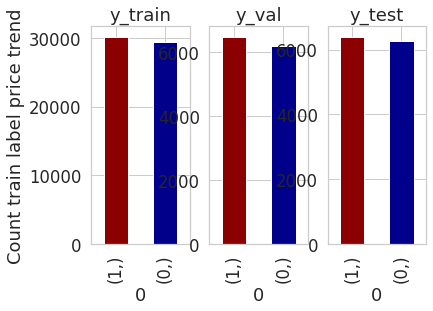

1    30194
0    29430
dtype: int64
1    6469
0    6190
dtype: int64
1    6400
0    6249
dtype: int64


In [ ]:
# plt.subplot(2,1,1)
plt.subplot(131)
value_counts1 = pd.DataFrame(y_train).value_counts()
value_counts1.plot.bar(color=['darkred','darkblue'], title = 'y_train')
plt.ylabel('Count train label price trend')
# plt.xticks([],[])

# plt.subplot(2,1,2)
plt.subplot(132)
value_counts2 = pd.DataFrame(y_val).value_counts()
value_counts2.plot.bar(color=['darkred','darkblue'], title = 'y_val')
# plt.ylabel('Count train label price trend')
# plt.xticks([],[])

plt.subplot(133)
value_counts3 = pd.DataFrame(y_test).value_counts()
value_counts3.plot.bar(color=['darkred','darkblue'], title = 'y_test')
# plt.ylabel('Count train label price trend')
# plt.xticks([],[])

plt.show()

print(value_counts1)
print(value_counts2)
print(value_counts3)

**Random sampling Method**  
Köknar-Tezel and Latecki63 proposed a supervised learning-based oversampling approach that creates and puts synthetic instances into distance space directly. This strategy is very useful for data where general distance measures cannot be used and so SMOTE cannot be applied, for example, time series. Then, they used SVM for classification. This approach performed good on such cases.

Ref. : https://journals.sagepub.com/doi/10.1177/1550147720916404



In [ ]:
# # # Randomoversampling
# from imblearn.over_sampling import RandomOverSampler
# # ros = RandomOverSampler()
# # X_resampled, y_resampled = ros.fit_sample(X, y)


# ros = RandomOverSampler(random_state=0)
# # X_train, y_train = ros.fit_sample(X_train[0].reshape(-1,1), y_train[0].reshape(-1,1))
# X_train, y_train = ros.fit_resample(X_train, y_train)

# display(pd.Series(y_train).value_counts())

In [ ]:
# value_counts = y_train['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');
# value_counts = y_test['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');

In [ ]:
# X_train shape : (2469503, 7, 1)
# X_test shape : (274383, 7, 1)
# y_train shape : (2469503,)
# y_test shape : (274383,)

# X_train : 82318
# y_train : 82317
# X_test : 9147
# y_test : 9146

print(f'X_train : {X_train[:5]}')
print(f'y_train : {y_train[:5]}')
print(f'X_test : {X_test[:5]}')
print(f'y_test : {y_test[:5]}')
print('-'*100)
print(f'X_train : {X_train[:5][0]}')
# print(f'y_train : {y_train[:5][0]}')
print(f'X_test : {X_test[:5][0]}')
# print(f'y_test : {y_test[:5][0]}')
print('-'*100)
# print(f'X_train : {X_train[0]}')
# print(f'y_train : {y_train[82316:82318]}')
# print(f'X_test : {X_test[9145:9147]}')
# print(f'y_test : {y_test[9145:9147]}')
# # print('-'*100)

print(f'X_train : {type( X_train )}')
print(f'y_train : {type( y_train )}')
print(f'X_val : {type( X_val )}')
print(f'y_val : {type( y_val)}')
print(f'X_test : {type( X_test )}')
print(f'y_test : {type( y_test )}')
print('-'*100)
print(f'X_train[0] : {type( X_train[0] )}')
print(f'y_train[0] : {type( y_train[0] )}')
print(f'X_val[0] : {type( X_val[0] )}')
print(f'y_val[0] : {type( y_val[0] )}')
print(f'X_test[0] : {type( X_test[0] )}')
print(f'y_test[0] : {type( y_test[0] )}')
print('-'*100)
print(f'X_train[0][0] : {type( X_train[0][0] )}')
# print(f'y_train[0][0] : {type( y_train[0][0] )}')
print(f'X_val[0][0] : {type( X_val[0][0] )}')
# print(f'y_val[0][0] : {type( y_val[0][0] )}')
print(f'X_test[0][0] : {type( X_test[0][0] )}')
# print(f'y_test[0][0] : {type( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {type( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {type( y_train[0][0][0] )}')
# print(f'X_val[0][0][0] : {type( X_val[0][0][0] )}')
# print(f'y_val[0][0][0] : {type( y_val[0][0][0] )}')
# print(f'X_test[0][0][0] : {type( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {type( y_test[0][0][0] )}')
print('-'*100)
# print(f'X_train[0][0][0][0] : {type( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {type( y_train[0][0][0][0] )}')
# print(f'X_val[0][0][0][0] : {type( X_val[0][0][0][0] )}')
# print(f'y_val[0][0][0][0] : {type( y_val[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {type( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {type( y_test[0][0][0][0] )}')


print('-'*100)
print(f'X_train : {len( X_train )}')
print(f'y_train : {len( y_train )}')
print(f'X_val : {len( X_val )}')
print(f'y_val : {len( y_val )}')
print(f'X_test : {len( X_test )}')
print(f'y_test : {len( y_test )}')
print('-'*100)
print(f'X_train[0] : {len( X_train[0] )}')
# print(f'y_train[0] : {len( y_train[0] )}')
print(f'X_val[0] : {len( X_val[0] )}')
# print(f'y_val[0] : {len( y_val[0] )}')
print(f'X_test[0] : {len( X_test[0] )}')
# print(f'y_test[0] : {len( y_test[0] )}')
# print('-'*100)
# print(f'X_train[0][0] : {len( X_train[0][0] )}')
# # print(f'y_train[0][0] : {len( y_train[0][0] )}')
# print(f'X_test[0][0] : {len( X_test[0][0] )}')
# print(f'y_test[0][0] : {len( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {len( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {len( y_train[0][0][0] )}')
# print(f'X_test[0][0][0] : {len( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {len( y_test[0][0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0][0] : {len( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {len( y_train[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {len( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {len( y_test[0][0][0][0] )}')

print('-'*100)
print('X train data shape', X_train.shape)
print('y train label shape',y_train.shape) 
print('X val data shape', X_val.shape)
print('y val label shape',y_val.shape) 
print('X test data shape',X_test.shape)
print('y test label shape',y_test.shape)
print('-'*100)
print('X_train[0] data shape', X_train[0].shape)
print('y_train[0] label shape',y_train[0].shape)    
print('X_val[0] data shape', X_val[0].shape)
print('y_val[0] label shape',y_val[0].shape)    
print('X_test[0] data shape',X_test[0].shape)
print('y_test[0] label shape',y_test[0].shape)
print('-'*100)
print('X_train[0][0] data shape', X_train[0][0].shape)
# print('y train label shape',y_train[0][0].shape)   
print('X_val[0][0] data shape', X_val[0][0].shape)
# print('y val label shape',y_val[0][0].shape)   
print('X_test[0][0] data shape',X_test[0][0].shape)
# print('y test label shape',y_test[0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0].shape)
# print('y train label shape',y_train[0][0][0].shape)    
# print('X test data shape',X_test[0][0][0].shape)
# print('y test label shape',y_test[0][0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0][0].shape)
# print('y train label shape',y_train[0][0][0][0].shape)    
# print('X test data shape',X_test[0][0][0][0].shape)
# print('y test label shape',y_test[0][0][0][0].shape)

print('-'*100)
print('unique train label',np.unique(y_train))
print('unique val label',np.unique(y_val))
print('unique test label',np.unique(y_test))

X_train : [[0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815]
 [0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815]
 [0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0.06348815 0.06348815 0.06348815
  0.06348815 0.06348815 0.06348815 0

## **2.2.3 Walk forward No.3 stratified**

**Trend Prediction Classification for High Frequency Bitcoin Time Series with Deep Learning)**

- Remove oulier by |Rt| > α (Set threshold = 0.1) x => don't use in this case use isolation forest
- min-max normalization
- Create train test dataset by so-called walk forward optimization method (วิธีการเพิ่มประสิทธิภาพการเดินไปข้างหน้า : Dixon et al. 2017) which can deal with class imbalance (non-stationarity) 

1. Paper  
https://docs.google.com/document/d/1Bifkt5Lkohui3EudKIkER4y0w2_vWILv6bi013gPils/edit

2. Time_Series_data_preparation  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00c_Time_Series_data_preparation.ipynb#scrollTo=I79BWYUgwUzS  

3. TS_archs_comparison  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/05_TS_archs_comparison.ipynb  
  
4. 07_Time_Series_Classification_with_Transformers  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb

**Function**

In [ ]:
# # def normalise_zero_base(df):
# #     """ Normalise dataframe column-wise to reflect changes with respect to first entry.
# #         ปรับคอลัมน์ดาต้าเฟรมให้เป็นมาตรฐานเพื่อสะท้อนการเปลี่ยนแปลงที่เกี่ยวข้องกับรายการแรก
# #     """
# #     return df / df.iloc[0] - 1

# def normalise_min_max(df):
#     """ Feature Scaling min max Normalise dataframe column-wise min/max. """
#     return (df - df.min()) / (df.max() - df.min())

In [ ]:
# def extract_window_data(df, window=30, min_max=True):      #zero_base=True):
#     """ Convert dataframe to overlapping sequences/windows of length `window`.
#         แปลงดาต้าเฟรมเป็นลำดับที่ทับซ้อนกัน/หน้าต่างของหน้าต่างความยาว
#     """
#     X = []
#     y = []
#     window_mt_y = []
#     # for idx in range(len(df) - window):
#     #     tmp = df[idx: (idx + window)].copy()
#     #     if zero_base:
#     #         tmp = normalise_zero_base(tmp)
#     #     window_data.append(tmp.values)
#     # return np.array(window_data)

#     for idx in range( (len(df) // window) + 1 ):

#         tmp = df[ idx * window : ((idx * window) + window) ].copy()
#         # print(tmp)
#         # print(type(tmp))    # <class 'pandas.core.frame.DataFrame'>

#         window_tmp = tmp['close'].to_numpy()
#         mt = tmp.mean()

#         # if min_max:
#         #     # tmp = normalise_zero_base(tmp)
#         #     norm_min_max = normalise_min_max(df)
#         #     # print(norm_min_max)
#         #     # print(type(norm_min_max))   # <class 'pandas.core.frame.DataFrame'>

#         X.append(window_tmp)
#         window_mt_y.append(mt.values)

#     for i in range( (len(df) // window) ):
#         '''
#         target label => 1 = down trend, 2 = up trend, 0 = static  
#         in paper eth/usd plus + 0.24 Up and Down trend
#         '''
#         if ( window_mt_y[i][0] > window_mt_y[i+1][0] ):  # create down trend = 1
#             y.append(1)
#         elif ( window_mt_y[i][0] < window_mt_y[i+1][0] ):  # create up trend = 2
#             y.append(2)
#         else:        # create static trend = 2
#             y.append(2)


#     # window_data = window_data[0]
#     # window_data = window_data[:91463]
#     # window_mt = window_mt[:91463]

#     return np.array(X) , np.array(y)

In [ ]:
# # window = 30 min, window = 60 min = 1 hour, window = 1440 min = 1 day

# def prepare_data(df, window=30, min_max=True, test_size=0.1):   # zero_base=True , min_max=True
#     """ Prepare data for OS-CNN. """
#     # train test split
#     train_data, test_data = train_test_split(df, test_size)
    
#     # extract window data
#     X_train, y_train = extract_window_data(train_data, window, min_max)
#     X_test, y_test = extract_window_data(test_data, window, min_max)

#     return X_train, X_test, y_train, y_test

In [ ]:
# Normalization
# min-max normalization 
# https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
# https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

scaler = MinMaxScaler()
close_price = eth_closes.close.values.reshape(-1, 1)
eth_closes = scaler.fit_transform(close_price)
eth_closes = pd.DataFrame(eth_closes, columns = ['close'])

print(f'Head 10 : {eth_closes[:11]}')
print('-'*50)
print(f'Tail 10 : {eth_closes[2743890:]}')
print('-'*50)
print(f'Original  max price : {close_price.max()} min price : {close_price.min()}')
print('-'*50)
print(f'Min max normalization max price : {eth_closes.max()} min price : {eth_closes.min()}')
print('-'*50)
print(f'Shape dataset : {eth_closes.shape}')
print('-'*50)
print(f'Orginal close price : {close_price}')
print(type(close_price))
print('-'*50)
print(f'Min max normalization close price : {eth_closes}')
print(type(eth_closes))

Head 10 :        close
0   0.002412
1   0.002412
2   0.002413
3   0.002413
4   0.002413
5   0.002414
6   0.002416
7   0.002416
8   0.002416
9   0.002416
10  0.002416
--------------------------------------------------
Tail 10 : Empty DataFrame
Columns: [close]
Index: []
--------------------------------------------------
Original  max price : 56545.01 min price : 831.95
--------------------------------------------------
Min max normalization max price : close    1.0
dtype: float64 min price : close    0.0
dtype: float64
--------------------------------------------------
Shape dataset : (2470117, 1)
--------------------------------------------------
Orginal close price : [[  966.34]
 [  966.34]
 [  966.37]
 ...
 [41282.03]
 [41293.53]
 [41282.43]]
<class 'numpy.ndarray'>
--------------------------------------------------
Min max normalization close price :             close
0        0.002412
1        0.002412
2        0.002413
3        0.002413
4        0.002413
...           ...
2470112 

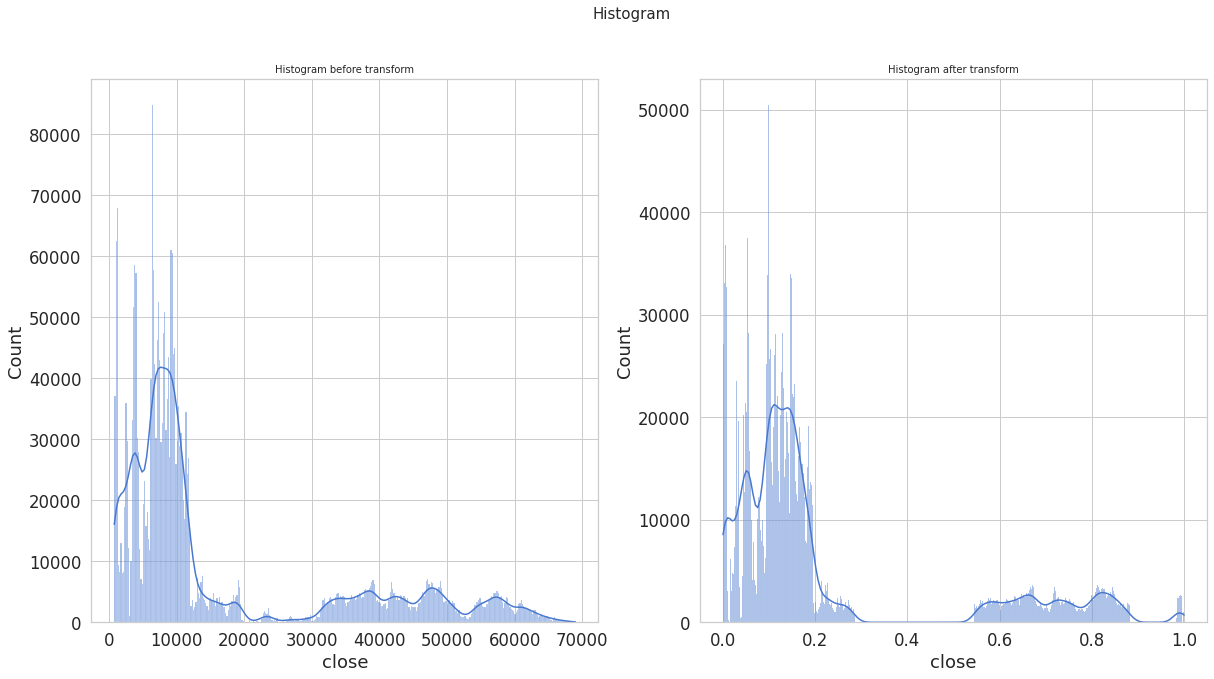

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Histogram', fontsize=15)

# Draw
sns.histplot(data=eth_close, x="close", kde=True, ax=axes[0])

sns.histplot(data=eth_closes, x="close", kde=True, ax=axes[1])

# Set Title
axes[0].set_title('Histogram before transform', fontsize=10)
axes[1].set_title('Histogram after transform', fontsize=10)

plt.show()

**The walk forward optimization approach for backtesting
a simple trading strategy.** 
file:///C:/Semester%204/BADS9000%20IS/Reference%20IS/so-called%20walk%20forward%20optimization%20method.pdf  
https://www.siamquant.com/walk-forward/  

   
ตามแนวทางการปรับให้เหมาะสมแบบก้าวไปข้างหน้าใน Tomasini และ Jaekle (2011) หน้าต่างการปรับให้เหมาะสมเริ่มต้น 25,000 ช่วงเวลาการสังเกต 5 นาทีหรือประมาณ 260 วัน (มากกว่าหนึ่งปีเล็กน้อย) จะถูกเลือกสำหรับการฝึกโมเดลโดยใช้ข้อมูลสัญลักษณ์ทั้งหมดและ อนุกรมเวลาที่ได้รับการออกแบบทางวิศวกรรม

learning rate  range ถูกกวาดเพื่อค้นหาแบบจำลองที่ให้อัตราการทำนายที่ไม่อยู่ในตัวอย่างที่ดีที่สุด (out-of-sample) - อัตราการจำแนกประเภทสูงสุดในชุดตัวอย่างที่ไม่อยู่ในกลุ่มตัวอย่าง ('hold-out') ซึ่งประกอบด้วยการสังเกตต่อเนื่องกัน 12,500 ครั้งและล่าสุด

จากนั้นใช้แบบจำลองที่ปรับให้เหมาะสม P&L ที่คาดหวังของกลยุทธ์การซื้อขายจะได้รับการประเมินในช่วงนอกช่วงตัวอย่างซึ่งประกอบด้วย 12,500 ช่วงเวลาการสังเกต 5 นาทีติดต่อกัน 12,500 หรือประมาณ 130 วัน

การ train model ขั้นตอนนี้ทำซ้ำโดยเลื่อนการ train
หน้าต่างไปข้างหน้า 1000 ช่วงเวลาสังเกต
และทำซ้ำการวิเคราะห์ข้อผิดพลาดที่ไม่อยู่ในตัวอย่าง
และการวัดประสิทธิภาพกลยุทธ์สำหรับสิบ
หน้าต่าง

In [ ]:
# Split test set 15%

test_data = eth_closes.iloc[ int(len(eth_closes)*0.85) : ]
train_val_data = eth_closes.iloc[ : int(len(eth_closes)*0.85) ]

In [ ]:
# # Ref. : 1.https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a
# #        2.https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn
# #        3.http://thaiquants.com/vlog/walk-forward-analysis/

# length = 10080
# eth_lengthnum = 348

# train_size =  0.823529411764706
# val_size =  0.176470588235294
# # train_size =  0.82
# # val_size =  0.18

# window = 30
# split_indexs = []

# X_train = []
# X_val = []
# X_test = []

# window_mt_y_train = []
# window_mt_y_val = []
# window_mt_y_test = []

# # # find X test
# # for idx in range( (len(test_data) // window) + 1 ):    # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
# #     print(f'index test window : {idx}')
# #     tmp_test = test_data[idx * window : ((idx * window) + window)].copy() 
# #     # print(tmp_test)
# #     # print(type(tmp_test))    
    
# #     window_tmp_test = tmp_test['close'].to_numpy()   # <class 'numpy.ndarray'>
# #     # print(window_tmp_test)
# #     # print(type(window_tmp_test))  
# #     # print(window_tmp_test.shape)

# #     mt_test = tmp_test.mean()   # mean price in window 30 min. for find y classification

# #     X_test.append(window_tmp_test)
# #     # X_test.append(tmp_test.values)
# #     window_mt_y_test.append(mt_test.values)

#     data_length = train_val_data.iloc[ initial_index : last_index ]   
#     train_data = data_length.iloc[ : int(length*train_size) ]
#     val_data = data_length.iloc[ int(length*train_size) : ]

# # find X train & validation
# for i in range(eth_lengthnum + 1):
#     print(f'index length: {i}')

#     if i == 0:  
#         initial_index = 0
#     else:
#         initial_index = split_indexs[i-1]

#     last_index = initial_index + length
#     # last_index = initial_index + (length * (i+1))
#     split_index = last_index - int(length * val_size)
#     split_indexs.append(split_index)

#     train_data = train_val_data.iloc[ : split_index ]
#     test_data = train_val_data.iloc[ split_index : last_index ]

#     # print('last_index', last_index)
#     # print('initial_dex', initial_index)
#     # print('split_index', split_index)
#     # print('count data length', len(data_length))
#     # print('Data length', data_length)
    
#     # train_data = data_length.iloc[ : int(length*train_size) ]
#     # val_data = data_length.iloc[ int(length*train_size) : ]
 
#     # print('train_data', len(train_data))
#     # print('val_data', len(val_data))
#     # print('Type train_data', type(train_data))
#     # print('Type val_data', type(val_data))
    
    
#     # Create X_train
#     # for idx in  range( int((len(data_length) // window)*0.7) + 1 ):   # eth train 70% = 0-235
#     for idx in  range( int((len(data_length) // window) * train_size) ):   # eth train 70% = 0-235
#         print(f'index train window : {idx}')

#         tmp_train = train_data[idx * window : ((idx * window) + window)].copy()  # create array dimension window 30 min.  # <class 'pandas.core.frame.DataFrame'>
#         # print(tmp_train)
#         # print(type(tmp_train))    

#         # window_tmp_train = tmp_train['close'].to_numpy()  # <class 'numpy.ndarray'>
#         # window_tmp_train = np.asarray(tmp_train['close'].values.tolist())
#         window_tmp_train = tmp_train['close'].values.tolist()
#         # window_tmp_train = window_tmp_train.flatten()
#         # print(window_tmp_train)
#         print(type(window_tmp_train))  
#         # print(window_tmp_train.shape)

#         mt_train = tmp_train.mean().values   # mean price in window 30 min. for find y classification

#         X_train.append(window_tmp_train)
#         # X_train.append(tmp_train.values)
#         window_mt_y_train.append(mt_train)


#     # Create X_val
#     # for idx in range( int((len(data_length) // window)*0.3)):   # eth train 30% = 0-100   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
#     for idx in range( int((len(data_length) // window) * val_size) ):   # eth train 30% = 0-50   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
#         print(f'index val window : {idx}')

#         tmp_val = val_data[idx * window : ((idx * window) + window)].copy() 
#         # print(tmp_val)
#         # print(type(tmp_val))    
        
#         # window_tmp_val = tmp_val['close'].to_numpy()   # <class 'numpy.ndarray'>
#         # window_tmp_val = np.array(tmp_val['close'].values.tolist())
#         window_tmp_val = tmp_val['close'].values.tolist()
#         # print(window_tmp_val)
#         print(type(window_tmp_val))  
#         # print(window_tmp_val.shape)

#         mt_val =  tmp_val.mean().values   # mean price in window 30 min. for find y classification

#         X_val.append(window_tmp_val)
#         # X_val.append(tmp_val.values)
#         window_mt_y_val.append(mt_val)


Streaming output truncated to the last 5000 lines.
713971  0.126150

[713972 rows x 1 columns]
index length: 86
last_index 724052
initial_dex 713972
split_index 722274
count data length 722274
Data length            close
0       0.002412
1       0.002412
2       0.002413
3       0.002413
4       0.002413
...          ...
722269  0.112972
722270  0.112963
722271  0.112868
722272  0.112796
722273  0.112709

[722274 rows x 1 columns]
index length: 87
last_index 732354
initial_dex 722274
split_index 730576
count data length 730576
Data length            close
0       0.002412
1       0.002412
2       0.002413
3       0.002413
4       0.002413
...          ...
730571  0.123124
730572  0.123095
730573  0.123153
730574  0.123270
730575  0.123306

[730576 rows x 1 columns]
index length: 88
last_index 740656
initial_dex 730576
split_index 738878
count data length 738878
Data length            close
0       0.002412
1       0.002412
2       0.002413
3       0.002413
4       0.002413
...        

In [ ]:
print(len(X_train))
print(len(X_train[0]))

print(len(X_test))
print(len(X_test[0]))

print(len(X_val))
print(len(X_val[0]))

67729
30
14410
30
14410
30


In [ ]:
# Ref. : 1.https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a
#        2.https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn
#        3.http://thaiquants.com/vlog/walk-forward-analysis/

length = 10080
eth_lengthnum = 348

test_size = 0.3
train_size = 0.7
# test_size = 0.15
# validation_size = 0.15

window = 30
split_indexs = []

X_train = []
X_test = []
# X_validation = []

window_mt_y_train = []
window_mt_y_test = []
# window_mt_y_validation = []

for i in range(eth_lengthnum + 1):
    print(f'index length: {i}')

    if i == 0:  
        initial_index = 0
    else:
        initial_index = split_indexs[i-1]

    last_index = initial_index + length
    split_index = last_index - int(length*test_size)
    split_indexs.append(split_index)

    data_length = eth_closes.iloc[ initial_index : last_index ]

    # print('last_index', last_index)
    # print('initial_dex', initial_index)
    # print('split_index', split_index)
    # print('count data length', len(data_length))
    # print('Data length', data_length)
    
    train_data = data_length.iloc[ : int(length*0.7) ]
    test_data = data_length.iloc[ int(length*0.7) : ]
 
    # print('train_data', len(train_data))
    # print('test_data', len(test_data))
    # print('Type train_data', type(train_data))
    # print('Type test_data', type(test_data))
    
    
    # Create X_train
    # for idx in  range( int((len(data_length) // window)*0.7) + 1 ):   # eth train 70% = 0-235
    for idx in  range( int((len(data_length) // window)*train_size)):   # eth train 70% = 0-235
        print(f'index train window : {idx}')

        tmp_train = train_data[idx * window : ((idx * window) + window)].copy()  # create array dimension window 30 min.  # <class 'pandas.core.frame.DataFrame'>
        # print(tmp_train)
        # print(type(tmp_train))    

        # window_tmp_train = tmp_train['close'].to_numpy()  # <class 'numpy.ndarray'>
        # window_tmp_train = np.asarray(tmp_train['close'].values.tolist())
        window_tmp_train = tmp_train['close'].values.tolist()
        # window_tmp_train = window_tmp_train.flatten()
        # print(window_tmp_train)
        # print(type(window_tmp_train))  
        # print(window_tmp_train.shape)

        mt_train = tmp_train.mean().values   # mean price in window 30 min. for find y classification

        X_train.append(window_tmp_train)
        # X_train.append(tmp_train.values)
        window_mt_y_train.append(mt_train)

    # Create X_test
    # for idx in range( int((len(data_length) // window)*0.3)):   # eth train 30% = 0-100   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
    for idx in range( int((len(data_length) // window)*test_size)):   # eth train 30% = 0-50   # create array dimension window 30 min. # <class 'pandas.core.frame.DataFrame'>
        print(f'index test window : {idx}')

        tmp_test = test_data[idx * window : ((idx * window) + window)].copy() 
        # print(tmp_test)
        # print(type(tmp_test))    
        
        # window_tmp_test = tmp_test['close'].to_numpy()   # <class 'numpy.ndarray'>
        # window_tmp_test = np.asarray(tmp_test['close'].values.tolist())
        window_tmp_test = tmp_test['close'].values.tolist()
        # print(window_tmp_test)
        # print(type(window_tmp_test))  
        # print(window_tmp_test.shape)

        mt_test =  tmp_test.mean().values   # mean price in window 30 min. for find y classification

        X_test.append(window_tmp_test)
        # X_test_test.append(tmp_test.values)
        window_mt_y_test.append(mt_test)

# X_train : 82015  82013 -2  # y_train : 82014  82013  -1
# X_test : 34900   34898  -2 # y_test : 34899   34898   -1

X_train = np.array(X_train[:len(X_train) - 2])
X_test = np.array(X_test[:len(X_test) - 2])

Streaming output truncated to the last 5000 lines.
index train window : 39
index train window : 40
index train window : 41
index train window : 42
index train window : 43
index train window : 44
index train window : 45
index train window : 46
index train window : 47
index train window : 48
index train window : 49
index train window : 50
index train window : 51
index train window : 52
index train window : 53
index train window : 54
index train window : 55
index train window : 56
index train window : 57
index train window : 58
index train window : 59
index train window : 60
index train window : 61
index train window : 62
index train window : 63
index train window : 64
index train window : 65
index train window : 66
index train window : 67
index train window : 68
index train window : 69
index train window : 70
index train window : 71
index train window : 72
index train window : 73
index train window : 74
index train window : 75
index train window : 76
index train window : 77
index train w

In [ ]:
# print(X_train[:10])
# # print(window_mt_y_train[0])
# # print(window_mt_y_train[0][0])
# # # print(window_mt_y_train[0][0][0])
# # print('-'*100)
# # print(window_mt_y_test[0])
# # print(window_mt_y_test[0][0])
# # # print(window_mt_y_test[0][0][0])

# # print(X_train[0].append(1))
# # print(X_train[0][0].append(1))

# # X_train[0] += [1]


In [ ]:
# class Sampler():
#     # ds = Dataset, bs = Batch Size, n = Length of Dataset
#     def __init__(self, ds, bs, shuffle=False):
#         self.n, self.bs, self.shuffle = len(ds), bs, shuffle
#     def __iter__(self):
#         self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
#         for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

# train_samp = Sampler(train_ds, bs, shuffle=True)
# valid_samp = Sampler(valid_ds, bs, shuffle=False)

# train_dl = data.DataLoader(train_ds, bs, sampler=data.RandomSampler(train_ds), collate_fn=collate, num_workers=8)
# valid_dl = data.DataLoader(valid_ds, bs, sampler=data.SequentialSampler(valid_ds), collate_fn=collate, num_workers=8)

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
# from sklearn.model_selection import KFold
# import random

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
# from torch.nn import functional as F
# import torchvision
# from torchvision import datasets,transforms
# import torchvision.transforms as transforms

# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(42)
# criterion = nn.CrossEntropyLoss()

# dataset = ConcatDataset([train, test_dataset])

# num_epochs=10
# batch_size=128
# k=10
# splits=KFold(n_splits=k,shuffle=True,random_state=42)
# foldperf={}

In [ ]:
# find target trend label for trian test => One hot encode
y_train = []
y_test = []

down_trend = 0
static_trend = 0
up_trend = 1

# find y train
for i in range( len(window_mt_y_train) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(i)
    if ( window_mt_y_train[i][0] > window_mt_y_train[i+1][0] ):  # create down trend = 2
        y_train.append(down_trend)
        X_train[i][0].append(down_trend)
    elif ( window_mt_y_train[i][0] < window_mt_y_train[i+1][0] ):  # create up trend = 1
        y_train.append(up_trend)
        X_train[i][0].append(up_trend)
    else:         # create static trend = 2
        y_train.append(static_trend)
        X_train[i].append(static_trend)


# find y test
for i in range( len(window_mt_y_test) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(i)
    if ( window_mt_y_test[i][0] > window_mt_y_test[i+1][0] ):    # create down trend = 2
        y_test.append(down_trend)
        X_test[i].append(down_trend)
    elif ( window_mt_y_test[i][0] < window_mt_y_test[i+1][0] ):   # create up trend = 1
        y_test.append(up_trend)
        X_test[i].append(up_trend)
    else:         # create static trend = 2
        y_test.append(static_trend)
        X_test[i].append(static_trend)

# find y validation
for i in range( len(window_mt_y_test) - 1 ):
    '''
    target label =>  0 = down trend,
                     0 = static   
                     1 = up trend, 
    in paper eth/usd plus + 0.24 Up and Down trend
    '''
    print(i)
    if ( window_mt_y_test[i][0] > window_mt_y_test[i+1][0] ):    # create down trend = 2
        y_test.append(down_trend)
        X_test[i].append(down_trend)
    elif ( window_mt_y_test[i][0] < window_mt_y_test[i+1][0] ):   # create up trend = 1
        y_test.append(up_trend)
        X_test[i].append(up_trend)
    else:         # create static trend = 2
        y_test.append(static_trend)
        X_test[i].append(static_trend)

0


AttributeError: ignored

In [ ]:
y_train = np.array(y_train[:len(y_train) - 1])
y_test = np.array(y_test[:len(y_test) - 1])

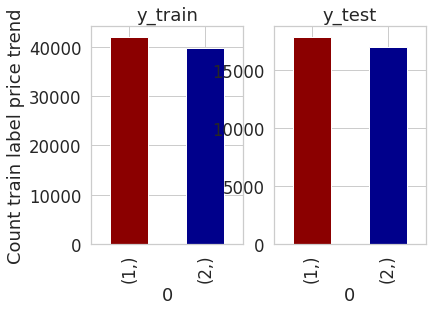

1    42180
2    39834
dtype: int64
1    17909
2    16990
dtype: int64


In [ ]:
# plt.subplot(2,1,1)
plt.subplot(121)
value_counts1 = pd.DataFrame(y_train).value_counts()
value_counts1.plot.bar(color=['darkred','darkblue'], title = 'y_train')
plt.ylabel('Count train label price trend')
# plt.xticks([],[])

# plt.subplot(2,1,2)
plt.subplot(122)
value_counts2 = pd.DataFrame(y_test).value_counts()
value_counts2.plot.bar(color=['darkred','darkblue'], title = 'y_test')
# plt.ylabel('Count train label price trend')
# plt.xticks([],[])

plt.show()

print(value_counts1)
print(value_counts2)

In [ ]:
# train : 82013
# test : 34898
print(f'dataset[82012] : {dataset[82012]}')
print(f'dataset[82013] : {dataset[82013]}')
print(f'dataset[82014] : {dataset[82014]}')
print(f'dataset[82015] : {dataset[82015]}')

print('-'*100)
print(f'dataset[0] : {dataset[0]}')
print(f'dataset[1] : {dataset[1]}')
print(f'dataset[2] : {dataset[2]}')
print('-'*100)
print(f'dataset[0][0] : {dataset[0][0]}')
# print('-'*100)
# print(f'dataset[0][0][0] : {dataset[0][0][0]}')
# print('-'*100)
# print(f'dataset[0][0][0][0] : {dataset[0][0][0][0]}')
# print('-'*100)
# print(f'dataset[0][0][0][0][0] : {dataset[0][0][0][0][0]}')
# print('-'*100)
# print(f'dataset[0][0][0][0][0][0] : {dataset[0][0][0][0][0][0]}')
print('='*100)
print(type(dataset))
print(type(dataset[0]))
print(type(dataset[0][0]))
# print(type(dataset[0][0][0]))
# print(type(dataset[0][0][0][0]))
# print(type(dataset[0][0][0][0][0]))
# print(type(dataset[0][0][0][0][0][0]))
print('='*100)
# print(dataset.shape)
print(dataset[0].shape)
print(dataset[0][0].shape)
# print(dataset[0][0][0].shape)
# print(dataset[0][0][0][0].shape)
# print(dataset[0][0][0][0][0].shape)
# print(dataset[0][0][0][0][0][0].shape)
print('='*100)
print(len(dataset))
print(len(dataset[0]))
# print(len(dataset[0][0]))
# print(len(dataset[0][0][0]))
# print(len(dataset[0][0][0][0]))
# print(len(dataset[0][0][0][0][0]))
# print(len(dataset[0][0][0][0][0][0]))

dataset[82012] : [0.68501183 0.68512077 0.68554808 0.68464059 0.68531639 0.68505869
 0.68545505 0.6857138  0.68597185 0.68552721 0.68478279 0.68392446
 0.68442269 0.68395559 0.68373645 0.68311495 0.68349769 0.68327431
 0.68337689 0.68356419 0.6835435  0.68381038 0.68464023 0.68456595
 0.6837957  0.68330013 0.68337158 0.68328828 0.68221701 0.68211903]
dataset[82013] : 1
dataset[82014] : 2
dataset[82015] : 2
----------------------------------------------------------------------------------------------------
dataset[0] : [0.00246178 0.00246178 0.00246231 0.00246231 0.00246231 0.00246337
 0.00246602 0.00246602 0.00246602 0.00246602 0.00246585 0.00246355
 0.00244834 0.00244834 0.00244781 0.00246585 0.00244798 0.00244798
 0.00244781 0.00244781 0.00244781 0.00244781 0.00246532 0.00246532
 0.00243578 0.00243578 0.00243578 0.00243578 0.00243578 0.00244232]
dataset[1] : [0.00244232 0.00244232 0.00244232 0.00244232 0.00244232 0.00246231
 0.00246231 0.00246284 0.00246266 0.00246266 0.00246284 0.00

**Random sampling Method**  
Köknar-Tezel and Latecki63 proposed a supervised learning-based oversampling approach that creates and puts synthetic instances into distance space directly. This strategy is very useful for data where general distance measures cannot be used and so SMOTE cannot be applied, for example, time series. Then, they used SVM for classification. This approach performed good on such cases.

Ref. : https://journals.sagepub.com/doi/10.1177/1550147720916404



In [ ]:
# # # Randomoversampling
# from imblearn.over_sampling import RandomOverSampler
# # ros = RandomOverSampler()
# # X_resampled, y_resampled = ros.fit_sample(X, y)


# ros = RandomOverSampler(random_state=0)
# # X_train, y_train = ros.fit_sample(X_train[0].reshape(-1,1), y_train[0].reshape(-1,1))
# X_train, y_train = ros.fit_resample(X_train, y_train)

# display(pd.Series(y_train).value_counts())

In [ ]:
value_counts = y_train['Class'].value_counts()
value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');
value_counts = y_test['Class'].value_counts()
value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');

In [ ]:
# X_train shape : (2469503, 7, 1)
# X_test shape : (274383, 7, 1)
# y_train shape : (2469503,)
# y_test shape : (274383,)

# X_train : 82318
# y_train : 82317
# X_test : 9147
# y_test : 9146

print(f'X_train : {X_train[:5]}')
print(f'y_train : {y_train[:5]}')
print(f'X_test : {X_test[:5]}')
print(f'y_test : {y_test[:5]}')
print('-'*100)
print(f'X_train : {X_train[:5][0]}')
# print(f'y_train : {y_train[:5][0]}')
print(f'X_test : {X_test[:5][0]}')
# print(f'y_test : {y_test[:5][0]}')
print('-'*100)
# print(f'X_train : {X_train[0]}')
# print(f'y_train : {y_train[82316:82318]}')
# print(f'X_test : {X_test[9145:9147]}')
# print(f'y_test : {y_test[9145:9147]}')
# # print('-'*100)

print(f'X_train : {type( X_train )}')
print(f'y_train : {type( y_train )}')
print(f'X_test : {type( X_test )}')
print(f'y_test : {type( y_test )}')
print('-'*100)
print(f'X_train[0] : {type( X_train[0] )}')
print(f'y_train[0] : {type( y_train[0] )}')
print(f'X_test[0] : {type( X_test[0] )}')
print(f'y_test[0] : {type( y_test[0] )}')
print('-'*100)
print(f'X_train[0][0] : {type( X_train[0][0] )}')
# print(f'y_train[0][0] : {type( y_train[0][0] )}')
print(f'X_test[0][0] : {type( X_test[0][0] )}')
# print(f'y_test[0][0] : {type( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {type( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {type( y_train[0][0][0] )}')
# print(f'X_test[0][0][0] : {type( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {type( y_test[0][0][0] )}')
print('-'*100)
# print(f'X_train[0][0][0][0] : {type( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {type( y_train[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {type( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {type( y_test[0][0][0][0] )}')


print('-'*100)
print(f'X_train : {len( X_train )}')
print(f'y_train : {len( y_train )}')
print(f'X_test : {len( X_test )}')
print(f'y_test : {len( y_test )}')
print('-'*100)
print(f'X_train[0] : {len( X_train[0] )}')
# print(f'y_train[0] : {len( y_train[0] )}')
print(f'X_test[0] : {len( X_test[0] )}')
# print(f'y_test[0] : {len( y_test[0] )}')
# print('-'*100)
# print(f'X_train[0][0] : {len( X_train[0][0] )}')
# # print(f'y_train[0][0] : {len( y_train[0][0] )}')
# print(f'X_test[0][0] : {len( X_test[0][0] )}')
# print(f'y_test[0][0] : {len( y_test[0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0] : {len( X_train[0][0][0] )}')
# print(f'y_train[0][0][0] : {len( y_train[0][0][0] )}')
# print(f'X_test[0][0][0] : {len( X_test[0][0][0] )}')
# print(f'y_test[0][0][0] : {len( y_test[0][0][0] )}')
# print('-'*100)
# print(f'X_train[0][0][0][0] : {len( X_train[0][0][0][0] )}')
# print(f'y_train[0][0][0][0] : {len( y_train[0][0][0][0] )}')
# print(f'X_test[0][0][0][0] : {len( X_test[0][0][0][0] )}')
# print(f'y_test[0][0][0][0] : {len( y_test[0][0][0][0] )}')

print('-'*100)
print('X train data shape', X_train.shape)
print('y train label shape',y_train.shape)    
print('X test data shape',X_test.shape)
print('y test label shape',y_test.shape)
print('-'*100)
print('X_train[0] data shape', X_train[0].shape)
print('y_train[0] label shape',y_train[0].shape)    
print('X_test[0] data shape',X_test[0].shape)
print('y_test[0] label shape',y_test[0].shape)
print('-'*100)
print('X_train[0][0] data shape', X_train[0][0].shape)
# print('y train label shape',y_train[0][0].shape)    
print('X_test[0][0] data shape',X_test[0][0].shape)
# print('y test label shape',y_test[0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0].shape)
# print('y train label shape',y_train[0][0][0].shape)    
# print('X test data shape',X_test[0][0][0].shape)
# print('y test label shape',y_test[0][0][0].shape)
# print('-'*100)
# print('X train data shape', X_train[0][0][0][0].shape)
# print('y train label shape',y_train[0][0][0][0].shape)    
# print('X test data shape',X_test[0][0][0][0].shape)
# print('y test label shape',y_test[0][0][0][0].shape)

print('-'*100)
print('unique train label',np.unique(y_train))
print('unique test label',np.unique(y_test))

X_train : [[0.00246178 0.00246178 0.00246231 0.00246231 0.00246231 0.00246337
  0.00246602 0.00246602 0.00246602 0.00246602 0.00246585 0.00246355
  0.00244834 0.00244834 0.00244781 0.00246585 0.00244798 0.00244798
  0.00244781 0.00244781 0.00244781 0.00244781 0.00246532 0.00246532
  0.00243578 0.00243578 0.00243578 0.00243578 0.00243578 0.00244232]
 [0.00244232 0.00244232 0.00244232 0.00244232 0.00244232 0.00246231
  0.00246231 0.00246284 0.00246266 0.00246266 0.00246284 0.00246284
  0.00246266 0.00246266 0.00246249 0.0024547  0.00245576 0.00246284
  0.00247292 0.00247292 0.00247292 0.00247292 0.00247292 0.00247292
  0.00247292 0.00247292 0.00247327 0.00247327 0.00246638 0.00246638]
 [0.00246638 0.00246638 0.00246638 0.0024662  0.00246638 0.00246638
  0.00246638 0.00246638 0.00246638 0.00243949 0.00242021 0.00241915
  0.00241402 0.00241402 0.00239457 0.00239457 0.00243843 0.00243843
  0.0024287  0.00242694 0.00240041 0.00240041 0.002428   0.002428
  0.00241951 0.00241951 0.00241951 0.0

IndexError: ignored

## **Continued prepraration**

In [ ]:
# Not drop class for check Result (Zero/One) by category
# eth_data = eth_usdt.drop(['unix2', 'date', 'symbol', 'open', 'high', 'low','Diff_Class', 
#                           #  'Class', 
#                           'Volume eth', 'Volume USDT', 'tradecount', 'year', 'month', 'day', 
#                           'time', 'time_2'], 
#                            axis=1)

eth_data = eth_usdt.drop(['open', 'high', 'low', 
                          # 'diff_class', 'percentdiff_class', 'Class',
                           'Volume eth'
                           ], axis=1)

eth_data.head()

,unix,close
0,2022-02-15 00:00:00,42572.95
1,2022-02-14 23:00:00,42535.94
2,2022-02-14 22:00:00,42678.07
3,2022-02-14 21:00:00,42234.50
4,2022-02-14 20:00:00,42180.50


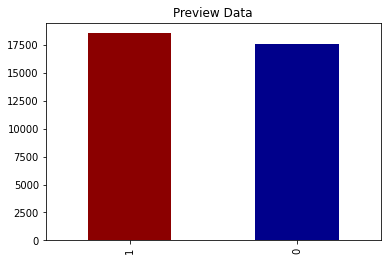

In [ ]:
# value_counts = eth_data['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');

value_counts = y['Class'].value_counts()
value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');

In [ ]:
# Check missing data
print(data.isnull().sum())
print(y.isnull().sum())

unix                 0
open                 0
high                 0
low                  0
close                0
diff_class           0
percentdiff_class    0
Volume BTC           0
dtype: int64
Class    0
dtype: int64


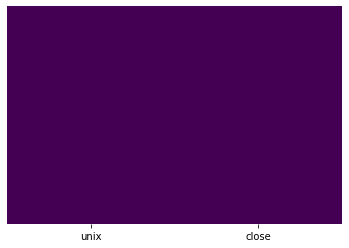

In [ ]:
sns.heatmap(eth_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
eth_data.head()

,unix,close
0,2022-02-15 00:00:00,42572.95
1,2022-02-14 23:00:00,42535.94
2,2022-02-14 22:00:00,42678.07
3,2022-02-14 21:00:00,42234.50
4,2022-02-14 20:00:00,42180.50


In [ ]:
# # Delete null
# eth_data['close'] = eth_data['close'].replace('NULL', np.mean(pd.to_numeric(eth_data['close'], errors='coerce')))
# # eth_data['Class'] = eth_data['Class'].replace('#VALUE!', np.mean(pd.to_numeric(df['Class'], errors='coerce')))
# eth_data = eth_data.drop(eth_data[ (eth_data.Class == '#VALUE!') ].index)

In [ ]:
# value_counts = eth_data['Class'].value_counts()
# value_counts.plot.bar(color=['darkred','darkblue'], title = 'Preview Data');

In [ ]:
# X = eth_data.drop(['Class', 'unix'], axis=1)
# y = eth_data['Class']

print(X.shape)
print(y.shape)

NameError: ignored

# **3.Define Model**

# **UNIVARIATE**

## **ORIGINAL DATASET FiftyWords => OS-CNN UNIVARIATE**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN


# model saved in result log folder
Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")
dataset_name = 'FiftyWords'

#batch_size for test
batch_size = 16
print('test dataset:', dataset_name)

test dataset: FiftyWords


In [ ]:
# load data
X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)    
# print(X_train[:5])
# print(X_test[:5])
# print(y_train[:5])
# print(y_test[:5])
# print(X_train[0])
# print(X_train[0][0])
# print(X_train[0][0][0])
# print(X_train[0][0][0][0])
# print(X_train[0][0][0][0][0])
# print(y_train[0])
# print(y_train[0][0])
# print(y_train[0][0][0])
# print(y_train[0][0][0][0])
# print(y_train[0][0][0][0][0])
# print('-'*100)

print(f'len(X_train) : {len(X_train)}')
print(f'len(X_test) : {len(X_test)}')
print(f'len(y_train) : {len(y_train)}')
print(f'len(y_test) : {len(y_test)}')
print('-'*100)
print('-'*100)
print(f'X_train.shape : {X_train.shape}')
print(f'X_train[0].shape : {X_train[0].shape}')
print(f'X_train[0][0].shape : {X_train[0][0].shape}')
# print(f'X_train[0][0][0].shape : {X_train[0][0][0].shape}')
# print(f'X_train[0][0][0][0].shape : {X_train[0][0][0][0].shape}')
# print(f'X_train[0][0][0][0][0].shape : {X_train[0][0][0][0][0].shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'y_train[0].shape : {y_train[0].shape}')
# print(f'y_train[0][0].shape : {y_train[0][0].shape}')
# print(f'y_train[0][0][0].shape : {y_train[0][0][0].shape}')
# print(y_train[0][0][0][0].shape)
# print(y_train[0][0][0][0][0].shape)
print('-'*100)

print(type(X_train))
print(type(X_train[0]))
print(type(X_train[0][0]))
# print(type(X_train[0][0][0]))
# print(type(X_train[0][0][0][0]))
# print(type(X_train[0][0][0][0][0]))
print('-'*100)
print(type(y_train))
print(type(y_train[0]))
# print(type(y_train[0][0]))
# print(type(y_train[0][0][0]))
# print(type(y_train[0][0][0][0]))
# print(type(y_train[0][0][0][0][0]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

len(X_train) : 450
len(X_test) : 455
len(y_train) : 450
len(y_test) : 455
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
X_train.shape : (450, 270)
X_train[0].shape : (270,)
X_train[0][0].shape : ()
y_train.shape : (450,)
y_train[0].shape : ()
----------------------------------------------------------------------------------------------------
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float32'>
----------------------------------------------------------------------------------------------------
<class 'numpy.ndarray'>
<class 'numpy.int64'>
code is running on:  cuda:0


In [ ]:
# put data to GPU
X_train = torch.from_numpy(X_train)
X_train.requires_grad = False
X_train = X_train.to(device)
X_train = X_train.unsqueeze_(1)
y_train = torch.from_numpy(y_train).to(device)

X_test = torch.from_numpy(X_test)
X_test.requires_grad = False
X_test = X_test.to(device)
X_test = X_test.unsqueeze_(1)
y_test = torch.from_numpy(y_test).to(device)
input_shape = X_train.shape[-1]
n_class = max(y_train) + 1
print('the size of inpute dataset is:',input_shape)
print('number of class is:',n_class)
    
#build dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

# code is running on:  cuda:0
# the size of inpute dataset is: 30
# number of class is: tensor(3, device='cuda:0')

the size of inpute dataset is: 270
number of class is: tensor(50, device='cuda:0')


In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

the shape of inpute data is: torch.Size([450, 1, 270])
the max size of kernel is: 67
the Network structure for FiftyWords is:
[[(1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 5), (1, 1, 7), (1, 1, 11), (1, 1, 13), (1, 1, 17), (1, 1, 19), (1, 1, 23), (1, 1, 29), (1, 1, 31), (1, 1, 37), (1, 1, 41), (1, 1, 43), (1, 1, 47), (1, 1, 53), (1, 1, 59), (1, 1, 61), (1, 1, 67)], [(20, 20, 1), (20, 20, 2), (20, 20, 3), (20, 20, 5), (20, 20, 7), (20, 20, 11), (20, 20, 13), (20, 20, 17), (20, 20, 19), (20, 20, 23), (20, 20, 29), (20, 20, 31), (20, 20, 37), (20, 20, 41), (20, 20, 43), (20, 20, 47), (20, 20, 53), (20, 20, 59), (20, 20, 61), (20, 20, 67)], [(400, 20, 1), (400, 20, 2)]]


In [ ]:
# find model path
best_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_test = eval_model(torch_FCN, test_loader)
 
sentence = str(acc_test)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)

FiftyWords test acc =  0.810989010989011


1.1

In [ ]:
Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")


dataset_name_list = [
"FiftyWords"
]

for dataset_name in dataset_name_list:
    print('running at:', dataset_name)   

    # load data,
    X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    print('test data shape',X_test.shape)
    print('test label shape',y_test.shape)
    print('unique train label',np.unique(y_train))
    print('unique test label',np.unique(y_test))

    # creat model and log save place,

    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder,
        dataset_name = dataset_name,           # dataset_name for creat log under Result_log_folder,
        device = "cuda:0",                # Gpu 
        max_epoch = 500,                        # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough,
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],
        )

    model.fit(X_train, y_train, X_test, y_test)

    y_predict = model.predict(X_test)

    print('correct:',y_test)
    print('predict:',y_predict)
    acc = accuracy_score(y_predict, y_test)
    print(acc)

running at: FiftyWords
train data shape (450, 270)
train label shape (450,)
test data shape (455, 270)
test label shape (455,)
unique train label [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
unique test label [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
code is running on  cuda:0


KeyboardInterrupt: ignored

In [ ]:
Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")


dataset_name_list = [
"FiftyWords"
]

for dataset_name in dataset_name_list:
    print('running at:', dataset_name)   

    # load data,
    X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)

# y_test    
    print(f'X_train : {X_train}')
    print(f'y_train : {y_train}')
    print(f'X_test : {X_test}')
    print(f'y_test : {y_test}')
    print('-'*100)

    print(f'X_train : {type( X_train )}')
    print(f'y_train : {type( y_train )}')
    print(f'X_test : {type( X_test )}')
    print(f'y_test : {type( y_test )}')
    print('-'*100)
    print(f'X_train[0] : {type( X_train[0] )}')
    print(f'y_train[0] : {type( y_train[0] )}')
    print(f'X_test[0] : {type( X_test[0] )}')
    print(f'y_test[0] : {type( y_test[0] )}')
    print('-'*100)
    print(f'X_train[0][0] : {type( X_train[0][0] )}')
    # print(f'y_train[0][0] : {type( y_train[0][0] )}')
    print(f'X_test[0][0] : {type( X_test[0][0] )}')
    # print(f'y_test[0][0] : {type( y_test[0][0] )}')
    print('-'*100)
    print(f'X_train[0][0][0] : {type( X_train[0][0][0] )}')
    print(f'y_train[0][0][0] : {type( y_train[0][0][0] )}')
    print(f'X_test[0][0][0] : {type( X_test[0][0][0] )}')
    print(f'y_test[0][0][0] : {type( y_test[0][0][0] )}')
    print('-'*100)
    print(f'X_train[0][0][0][0] : {type( X_train[0][0][0][0] )}')
    print(f'y_train[0][0][0][0] : {type( y_train[0][0][0][0] )}')
    print(f'X_test[0][0][0][0] : {type( X_test[0][0][0][0] )}')
    print(f'y_test[0][0][0][0] : {type( y_test[0][0][0][0] )}')
    print('-'*100)
    print(f'X_train : {len( X_train )}')
    print(f'y_train : {len( y_train )}')
    print(f'X_test : {len( X_test )}')
    print(f'y_test : {len( y_test )}')
    print('-'*100)
    print(f'X_train[0] : {len( X_train[0] )}')
    # print(f'y_train[0] : {len( y_train[0] )}')
    print(f'X_test[0] : {len( X_test[0] )}')
    # print(f'y_test[0] : {len( y_test[0] )}')
    print('-'*100)
    # print(f'X_train[0][0] : {len( X_train[0][0] )}')
    # print(f'y_train[0][0] : {len( y_train[0][0] )}')
    # print(f'X_test[0][0] : {len( X_test[0][0] )}')
    # print(f'y_test[0][0] : {len( y_test[0][0] )}')
    # print('-'*100)
    # print(f'X_train[0][0][0] : {len( X_train[0][0][0] )}')
    # print(f'y_train[0][0][0] : {len( y_train[0][0][0] )}')
    # print(f'X_test[0][0][0] : {len( X_test[0][0][0] )}')
    # print(f'y_test[0][0][0] : {len( y_test[0][0][0] )}')
    # # print('-'*100)
    # print(f'X_train[0][0][0][0] : {len( X_train[0][0][0][0] )}')
    # print(f'y_train[0][0][0][0] : {len( y_train[0][0][0][0] )}')
    # print(f'X_test[0][0][0][0] : {len( X_test[0][0][0][0] )}')
    # print(f'y_test[0][0][0][0] : {len( y_test[0][0][0][0] )}')
    # print('-'*100)
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)    
    print('test data shape',X_test.shape)
    print('test label shape',y_test.shape)
    print('-'*100)
    print('unique train label',np.unique(y_train))
    print('unique test label',np.unique(y_test))


    # creat model and log save place,

    # model = OS_CNN_easy_use(
    #     Result_log_folder = Result_log_folder, # the Result_log_folder,
    #     dataset_name = dataset_name,           # dataset_name for creat log under Result_log_folder,
    #     device = "cuda:0",                # Gpu 
    #     max_epoch = 500,                        # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough,
    #     paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],
    #     )

    # model.fit(X_train, y_train, X_test, y_test)

    # y_predict = model.predict(X_test)

    # print('correct:',y_test)
    # print('predict:',y_predict)
    # acc = accuracy_score(y_predict, y_test)
    # print(acc)

running at: FiftyWords


array([ 3, 11, 12, 22,  3, 12, 26,  0, 21,  0,  6,  8, 42, 12,  7,  2,  1,
        5, 23,  8,  5,  0, 14,  2,  7, 10, 15,  9,  1,  1,  4,  1,  2,  3,
        0,  0,  5,  2,  0,  1, 32,  0,  5,  8,  3, 41, 29, 13, 28, 47, 39,
       40,  7, 13, 44, 11, 15,  0,  7,  6, 33,  0,  0,  2, 28, 25, 30,  1,
        5,  0,  0,  4, 41,  0,  4, 21, 23,  0, 27, 16,  2, 30,  3,  0,  4,
        3,  4,  0, 29,  2,  0, 18,  0,  1,  9,  9,  1, 16, 33,  0,  2,  4,
        4,  4,  1, 24,  7, 40, 38,  1, 23, 17,  8,  5,  0,  9, 18,  1,  3,
        4, 20,  2,  2,  4,  1,  0,  1,  1,  5,  1, 23, 14,  2, 48,  8, 21,
       14, 10, 23, 16,  5,  3,  0,  0, 20,  1, 36, 11,  3, 40, 17, 34,  1,
        0,  2,  5,  1,  9,  1, 30,  4,  4, 15, 44,  2,  1,  8, 45,  6,  0,
        4, 15,  0, 40, 13,  6,  5, 10, 21,  2, 25,  6,  5, 37,  1,  3, 10,
        9,  8,  6, 48, 16, 48, 27,  3,  1, 24, 22,  5,  2,  6,  0, 19,  0,
       49,  3,  1,  2,  3, 13, 28, 41,  0, 10, 37, 39, 15, 45, 15,  2, 12,
       19, 11, 31, 10, 16

## **Cryptocurrency OS-CNN MODEL UNIVARIATE**

### **Split train 0.7 val 0.15 test 0.15**

In [ ]:
import os
from os.path import dirname
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader
# from utils.dataloader.TSC_data_loader import TSC_data_loader                         # .tsv
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader_from_mat   # .mat
from Classifiers.OS_CNN.OS_CNN_easy_use import OS_CNN_easy_use
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

#### **1_1_OS-CNN_easy_use_Run_and_Save_Model.ipynb**

In [ ]:
# Result_log_folder = './Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Results_of_OS_CNN_for_multivariate\OS_CNN_result_iter_0
# dataset_path = dirname("./Example_Datasets/UEAArchive_2018/")                              # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Datasets\UEAArchive_2018

# Split_tain_test
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/20_min/'   
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/60_min/'   
# Walk_forward No.1
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/60_min/'
# Walk_forward No.2
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/60_min/'
# Walk_forward No.3
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/60_min/'

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_1min/")                              

dataset_name = [
"ETH_Cryptocurrency",
]

start = time.time()

# for dataset_name in dataset_name_list:
for dataset_name in dataset_name:
    print('running at:', dataset_name)   
    
    # load multivariate data
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader(dataset_path, dataset_name)    # Multivariate
    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
    # X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)                 # Univariate
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader_from_mat( dataset_path, dataset_name )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    
    print('train data type', type(X_train))
    print('train label type',type(y_train))
    print('train data type', type(X_train[0]))
    print('train label type',type(y_train[0]))
    print('train data type', type(X_train[0][0]))
    # print('train label type',type(y_train[0][0]))

    print('val data shape',X_val.shape)
    print('val label shape',y_val.shape)
    
    print('unique train label',np.unique(y_train))
    print('unique val label',np.unique(y_val))
        
    # creat model and log save place
    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder
        dataset_name = dataset_name,      # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu 
        # device = "cuda:0",                     # Tpu 
        max_epoch = 500,                       # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128]
        # paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128]    # Multivariate
        # paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],                    # Univariate
                            )
    
    # X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()

    model.fit(X_train, y_train, X_val, y_val)

    y_predict = model.predict(X_test)
    print('correct:',y_test)
    print('predict:',y_predict)
    
    acc = accuracy_score(y_test, y_predict)
    f1 =  f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict) 
    recall = recall_score(y_test, y_predict)
    class_report = classification_report(y_test, y_predict)
    confusion_metrix = confusion_matrix(y_test, y_predict)
    os_cnn_roc_auc = roc_auc_score(y_test, y_predict)
    
    print(dataset_name,'test acc = ', acc)
    print(dataset_name,'test f1-score = ', f1)
    print(dataset_name,'test precision-score = ', precision)
    print(dataset_name,'test recall-score = ', recall)
    print(dataset_name,'test classification report = ',class_report)
    print(dataset_name,'test confusion metric = ',confusion_metrix)
    print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

done = time.time()
print(f'Time : {done - start}')

running at: ETH_Cryptocurrency
train data shape (50739, 30)
train label shape (50739,)
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.ndarray'>
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.int64'>
train data type <class 'numpy.float32'>
val data shape (10873, 30)
val label shape (10873,)
unique train label [0 1]
unique val label [0 1]
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5114211947417174 	 test_acc=	 0.5215671847696128 	 loss=	 0.6020089387893677
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_0/Split_train_test/ETH/30_min/ETH_Cryptocurrency/ETH_Cryptocurrency_.txt
epoch = 99 lr =  0.001
train_acc=	 0.4964228699816709 	 test_acc=	 0.5277292375609307 	 loss=	 0.6727320551872253
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_

<class 'numpy.ndarray'>
<class 'numpy.float64'>
0.0    10815
1.0       58
dtype: int64


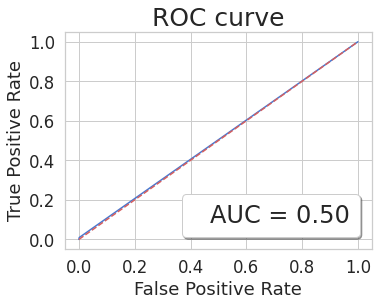

In [ ]:
print(type(y_predict))
print(type(y_predict[0]))
# print(type(y_predict[0][0]))
value_counts = pd.DataFrame(y_predict).value_counts()
print(value_counts)

plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

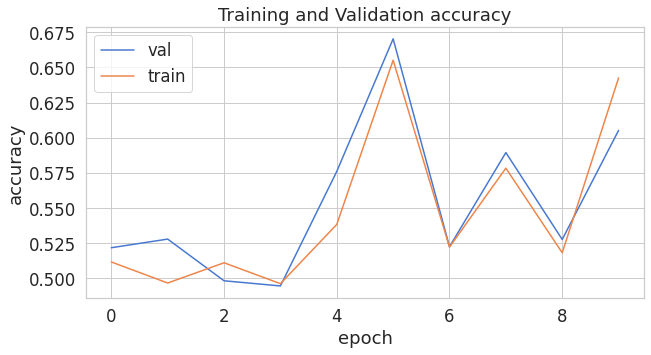

In [ ]:
epoch = [49, 99, 149, 199, 249, 
         299, 349, 399, 449, 499]
lr =  [0.001, 0.0005, 0.00025, 0.000125, 0.0001, 
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
train_acc =	 [0.5114211947417174, 0.4964228699816709, 0.5108496422869981, 0.49596956975896256, 
              0.5381659078815113, 0.6551764914562762, 0.5220441869173614, 0.5782534145331993, 
              0.5179841936183213, 0.6425629200417825]

val_acc =	[0.5215671847696128, 0.5277292375609307, 0.4980226248505472, 0.49434378736319323, 
             0.5759220086452681, 0.670376161133082, 0.5223029522670836, 0.5893497654741102, 
             0.5274533247493792, 0.6051687666697324]

loss = [0.6020089387893677, 0.6727320551872253, 0.6471758484840393, 0.6352295875549316, 
        0.6028238534927368, 0.5261247754096985, 0.6151428818702698, 0.7473244667053223, 
        1.0770686864852905, 0.46549192070961]


plt.figure(figsize=(10,5))
plt.title("Training and Validation accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

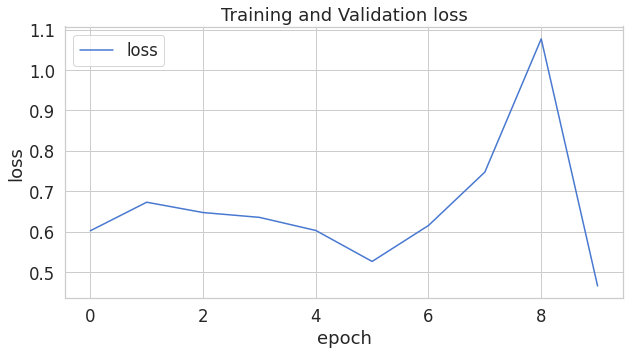

In [ ]:
# Loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation loss")
# plt.plot(val_acc,label="val")
plt.plot(loss,label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### **(Round2) 1_1_OS-CNN_easy_use_Run_and_Save_Model.ipynb**

In [ ]:
import os
from sklearn.metrics import accuracy_score
from os.path import dirname
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# from utils import save_model, save_plots, SaveBestModel

from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
class SaveBestModel:
      """
      Class to save the best model while training. If the current epoch's 
      validation loss is less than the previous least less, then save the
      model state.
      """
      def __init__(
          self, best_valid_loss=float('inf')
      ):
          self.best_valid_loss = best_valid_loss
          
      def __call__(
          self, current_valid_loss, 
          epoch, model, optimizer, criterion
      ):
          if current_valid_loss < self.best_valid_loss:
              self.best_valid_loss = current_valid_loss
              print(f"\nBest validation loss: {self.best_valid_loss}")
              print(f"\nSaving best model for epoch: {epoch+1}\n")
              torch.save({
                  'epoch': epoch+1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': criterion,
                  }, 'outputs/best_model.pth')
          
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/ETH_Cryptocurrency/final_model.pth')

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/ETH_Cryptocurrency/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/ETH_Cryptocurrency/loss.png')

In [ ]:
class OS_CNN_easy_use():
    
    def __init__(self,Result_log_folder, 
                 dataset_name, 
                 device, 
                 start_kernel_size = 1,
                 Max_kernel_size = 89, 
                 paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128], 
                 max_epoch = 2000, 
                 batch_size=16,
                 print_result_every_x_epoch = 50,
                 lr = 0.001
                ):
        
        super(OS_CNN_easy_use, self).__init__()
        
        if not os.path.exists(Result_log_folder +dataset_name+'/'):
            os.makedirs(Result_log_folder +dataset_name+'/')
        Initial_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'initial_model'
        model_save_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'
        

        self.Result_log_folder = Result_log_folder
        self.dataset_name = dataset_name        
        self.model_save_path = model_save_path
        self.Initial_model_path = Initial_model_path
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        
        self.start_kernel_size = start_kernel_size
        self.Max_kernel_size = Max_kernel_size
        self.paramenter_number_of_layer_list = paramenter_number_of_layer_list
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.print_result_every_x_epoch = print_result_every_x_epoch
        self.lr = lr
        self.OS_CNN = None

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # training
    # def train(model, trainloader, optimizer, criterion):
    #     model.train()
    #     print('Training')
    #     train_running_loss = 0.0
    #     train_running_correct = 0
    #     counter = 0
    #     for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    #         counter += 1
    #         image, labels = data
    #         image = image.to(device)
    #         labels = labels.to(device)
    #         optimizer.zero_grad()
            
    #         # forward pass
    #         # outputs = model(image)
    #         outputs = model(data[0])
    #         # calculate the loss
    #         loss = criterion(outputs, data[1])
    #         train_running_loss += loss.item()
    #         # calculate the accuracy
    #         _, preds = torch.max(outputs.data, 1)
    #         train_running_correct += (preds == data[1]).sum().item()
    #         # backpropagation
    #         loss.backward()
    #         # update the optimizer parameters
    #         optimizer.step()
        
    #     # loss and accuracy for the complete epoch
    #     epoch_loss = train_running_loss / counter
    #     epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    #     return epoch_loss, epoch_acc
    
    # # validation
    # def validate(model, testloader, criterion):
    #     model.eval()
    #     print('Validation')
    #     valid_running_loss = 0.0
    #     valid_running_correct = 0
    #     counter = 0
    #     with torch.no_grad():
    #         for i, data in tqdm(enumerate(testloader), total=len(testloader)):
    #             counter += 1
                
    #             # image, labels = data
    #             # image = image.to(device)
    #             # labels = labels.to(device)
    #             # forward pass
    #             # outputs = model(image)
    #             outputs = model(data[0])

    #             # calculate the loss
    #             loss = criterion(outputs, data[1])
    #             valid_running_loss += loss.item()
    #             # calculate the accuracy
    #             _, preds = torch.max(outputs.data, 1)
    #             valid_running_correct += (preds == data[1]).sum().item()
        
    #     # loss and accuracy for the complete epoch
    #     epoch_loss = valid_running_loss / counter
    #     epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    #     return epoch_loss, epoch_acc
    
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@        
        
    def fit(self, X_train, y_train, X_val, y_val):

        print('code is running on ',self.device)
        
        
        # covert numpy to pytorch tensor and put into gpu
        X_train = torch.from_numpy(X_train)
        X_train.requires_grad = False
        X_train = X_train.to(self.device)
        y_train = torch.from_numpy(y_train).to(self.device)
        
        
        X_test = torch.from_numpy(X_val)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)
        y_test = torch.from_numpy(y_val).to(self.device)
        
        
        # add channel dimension to time series data
        if len(X_train.shape) == 2:
            X_train = X_train.unsqueeze_(1)
            X_test = X_test.unsqueeze_(1)

        input_shape = X_train.shape[-1]
        n_class = max(y_train) + 1
        receptive_field_shape= min(int(X_train.shape[-1]/4),self.Max_kernel_size)
        
        # generate parameter list
        layer_parameter_list = generate_layer_parameter_list(self.start_kernel_size,
                                                             receptive_field_shape,
                                                             self.paramenter_number_of_layer_list,
                                                             in_channel = int(X_train.shape[1]))
        
        
        torch_OS_CNN = OS_CNN(layer_parameter_list, n_class.item(), False).to(self.device)
        
        # save_initial_weight
        torch.save(torch_OS_CNN.state_dict(), self.Initial_model_path)
        
        
        # loss, optimizer, scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(torch_OS_CNN.parameters(),lr= self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=0.0001)
        # initialize SaveBestModel class
        save_best_model = SaveBestModel()
        
        # build dataloader
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=True)
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=False)
        
        
        torch_OS_CNN.train()   

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # lists to keep track of losses and accuracies
        train_loss = [] 
        valid_loss = []
        train_acc = [] 
        valid_acc = []
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        
        for i in range(self.max_epoch):
            print(f'epoch No.', i)          

          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            # print(f"[INFO]: Epoch {i+1} of {i}")
            # train_epoch_loss, train_epoch_acc = train(torch_OS_CNN, train_loader, optimizer, criterion)
            # valid_epoch_loss, valid_epoch_acc = validate(torch_OS_CNN, test_loader, criterion)
            # train_loss.append(train_epoch_loss)
            # valid_loss.append(valid_epoch_loss)
            # train_acc.append(train_epoch_acc)
            # valid_acc.append(valid_epoch_acc)
            # print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
            # print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

            # # save the best model till now if we have the least loss in the current epoch
            # save_best_model(valid_epoch_loss, i, torch_OS_CNN, optimizer, criterion)

         # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
            train_running_loss = 0.0
            train_running_correct = 0
            counter = 0
            for sample in train_loader:
                counter += 1
                optimizer.zero_grad()
                y_predict = torch_OS_CNN(sample[0])
                output = criterion(y_predict, sample[1])

                train_running_loss += output.item()
                # calculate the accuracy
                _, preds = torch.max(y_predict, 1)
                train_running_correct += (preds == sample[1]).sum().item()

                output.backward()
                optimizer.step()

            scheduler.step(output)
            # loss and accuracy for the complete epoch
            train_epoch_loss = float(train_running_loss) / float(counter)
            train_epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
            train_loss.append(train_epoch_loss)
            train_acc.append(train_epoch_acc)
            print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            valid_running_loss = 0.0
            valid_running_correct = 0
            counters = 0
            for sample in test_loader:
                counters += 1
                optimizer.zero_grad()
                y_predict = torch_OS_CNN(sample[0])
                output = criterion(y_predict, sample[1])

                valid_running_loss += output.item()
                # calculate the accuracy
                _, preds = torch.max(y_predict, 1)
                valid_running_correct += (preds == sample[1]).sum().item()

                output.backward()
                optimizer.step()

            scheduler.step(output)
            # loss and accuracy for the complete epoch
            valid_epoch_loss = float(valid_running_loss) / float(counters)
            valid_epoch_acc = 100. * (valid_running_correct / len(test_loader.dataset))
            valid_loss.append(valid_epoch_loss)
            valid_acc.append(valid_epoch_acc)
            print(f"valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}")

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


            if eval_condition(i,self.print_result_every_x_epoch):
                for param_group in optimizer.param_groups:
                    print('epoch =',i, 'lr = ', param_group['lr'])
                torch_OS_CNN.eval()
                acc_train = eval_model(torch_OS_CNN, train_loader)
                acc_test = eval_model(torch_OS_CNN, test_loader)
                torch_OS_CNN.train()
                print('train_acc=\t', acc_train, '\t test_acc=\t', acc_test, '\t loss=\t', output.item())
                sentence = 'train_acc=\t'+str(acc_train)+ '\t test_acc=\t'+str(acc_test) 
                print('log saved at:')
                save_to_log(sentence,self.Result_log_folder, self.dataset_name)
                torch.save(torch_OS_CNN.state_dict(), self.model_save_path)

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            # save the trained model weights for a final time
            save_model(i, torch_OS_CNN, optimizer, criterion)
            # save the loss and accuracy plots
            save_plots(train_acc, valid_acc, train_loss, valid_loss)
            print('TRAINING COMPLETE')

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        torch.save(torch_OS_CNN.state_dict(), self.model_save_path)
        self.OS_CNN = torch_OS_CNN

        
        
    def predict(self, X_test):
        
        X_test = torch.from_numpy(X_test)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)
        
        if len(X_test.shape) == 2:
            X_test = X_test.unsqueeze_(1)
        
        test_dataset = TensorDataset(X_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_test.shape[0] / 10, self.batch_size)),2), shuffle=False)
        
        self.OS_CNN.eval()
        
        predict_list = np.array([])
        for sample in test_loader:
            y_predict = self.OS_CNN(sample[0])
            y_predict = y_predict.detach().cpu().numpy()
            y_predict = np.argmax(y_predict, axis=1)
            predict_list = np.concatenate((predict_list, y_predict), axis=0)
            
        return predict_list


In [ ]:
# Result_log_folder = './Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Results_of_OS_CNN_for_multivariate\OS_CNN_result_iter_0
# dataset_path = dirname("./Example_Datasets/UEAArchive_2018/")                              # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Datasets\UEAArchive_2018

# Split_tain_test
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/20_min/'   
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/60_min/'   
# Walk_forward No.1
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/60_min/'
# Walk_forward No.2
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/60_min/'
# Walk_forward No.3
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/60_min/'

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_1min/")                              

dataset_name = [
"ETH_Cryptocurrency",
]

start = time.time()

# for dataset_name in dataset_name_list:
for dataset_name in dataset_name:
    print('running at:', dataset_name)   
    
    # load multivariate data
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader(dataset_path, dataset_name)    # Multivariate
    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
    # X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)                 # Univariate
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader_from_mat( dataset_path, dataset_name )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    
    print('train data type', type(X_train))
    print('train label type',type(y_train))
    print('train data type', type(X_train[0]))
    print('train label type',type(y_train[0]))
    print('train data type', type(X_train[0][0]))
    # print('train label type',type(y_train[0][0]))

    print('val data shape',X_val.shape)
    print('val label shape',y_val.shape)
    
    print('unique train label',np.unique(y_train))
    print('unique val label',np.unique(y_val))
        
    # creat model and log save place
    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder
        dataset_name = dataset_name,      # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu 
        # device = "cuda:0",                     # Tpu 
        max_epoch = 500,                       # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128]
        # paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128]    # Multivariate
        # paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],                    # Univariate
                            )
    
    # X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()

    model.fit(X_train, y_train, X_val, y_val)

    y_predict = model.predict(X_test)
    print('correct:',y_test)
    print('predict:',y_predict)
    
    acc = accuracy_score(y_test, y_predict)
    f1 =  f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict) 
    recall = recall_score(y_test, y_predict)
    class_report = classification_report(y_test, y_predict)
    confusion_metrix = confusion_matrix(y_test, y_predict)
    os_cnn_roc_auc = roc_auc_score(y_test, y_predict)
    
    print(dataset_name,'test acc = ', acc)
    print(dataset_name,'test f1-score = ', f1)
    print(dataset_name,'test precision-score = ', precision)
    print(dataset_name,'test recall-score = ', recall)
    print(dataset_name,'test classification report = ',class_report)
    print(dataset_name,'test confusion metric = ',confusion_metrix)
    print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

done = time.time()
print(f'Time : {done - start}')

Output hidden; open in https://colab.research.google.com to view.

#### **1_2_OS-CNN_load_saved_model_for_prediction.ipynb**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
# model saved in result log folder
# Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
# dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/")                              

#batch_size for test
dataset_name = "ETH_Cryptocurrency"
batch_size = 16
print('test dataset:', dataset_name)

test dataset: ETH_Cryptocurrency


In [ ]:
# load data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
# X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

# X_train = X_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# X_test = X_test.astype(np.float32)

# # put data to GPU
# X_train = torch.from_numpy(X_train)
# X_train.requires_grad = False
# X_train = X_train.to(device)
# X_train = X_train.unsqueeze_(1)
# y_train = torch.from_numpy(y_train).to(device)

# X_test = torch.from_numpy(X_test)
# X_test.requires_grad = False
# X_test = X_test.to(device)
# X_test = X_test.unsqueeze_(1)
# y_test = torch.from_numpy(y_test).to(device)
# input_shape = X_train.shape[-1]
# n_class = max(y_train) + 1

# print('the size of inpute dataset is:',input_shape)
# print('number of class is:',n_class)
  
# #build dataloader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

# test_dataset = TensorDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

X_train_data = X_train.astype(np.float32)
X_val_data = X_val.astype(np.float32)
X_test_data = X_test.astype(np.float32)

# put data to GPU
X_train_data = torch.from_numpy(X_train_data)
X_train_data.requires_grad = False
X_train_data = X_train_data.to(device)
X_train_data = X_train_data.unsqueeze_(1)
y_train_data = torch.from_numpy(y_train).to(device)

X_val_data = torch.from_numpy(X_val_data)
X_val_data.requires_grad = False
X_val_data = X_val_data.to(device)
X_val_data = X_val_data.unsqueeze_(1)
y_val_data = torch.from_numpy(y_val).to(device)

X_test_data = torch.from_numpy(X_test_data)
X_test_data.requires_grad = False
X_test_data = X_test_data.to(device)
X_test_data = X_test_data.unsqueeze_(1)
y_test_data = torch.from_numpy(y_test).to(device)
input_shape = X_train_data.shape[-1]
n_class = max(y_train_data) + 1
# n_class =  max(y_train) - 1

print('the size of inpute dataset is:',input_shape)   # 30
print('number of class is:',n_class)    # 2
  
#build dataloader
train_dataset = TensorDataset(X_train_data, y_train_data)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=True)

val_dataset = TensorDataset(X_val_data, y_val_data)
val_loader = DataLoader(val_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=False)

test_dataset = TensorDataset(X_test_data, y_test_data)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=False)

code is running on:  cuda:0
the size of inpute dataset is: 30
number of class is: tensor(2, device='cuda:0')


In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train_data.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train_data.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

the shape of inpute data is: torch.Size([50739, 1, 30])
the max size of kernel is: 7
the Network structure for ETH_Cryptocurrency is:
[[(1, 56, 1), (1, 56, 2), (1, 56, 3), (1, 56, 5), (1, 56, 7)], [(280, 45, 1), (280, 45, 2), (280, 45, 3), (280, 45, 5), (280, 45, 7)], [(225, 280, 1), (225, 280, 2)]]


In [ ]:
# find model path
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'
best_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_val = eval_model(torch_FCN, val_loader)
acc_test = eval_model(torch_FCN, test_loader)

sentence_test = str(acc_test)
sentence_val = str(acc_val)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)
print(dataset_name,'validation acc = ', acc_val)

ETH_Cryptocurrency test acc =  0.493883932677274
ETH_Cryptocurrency validation acc =  0.6051687666697324


In [ ]:
# ==================== Predict ==================== 
X_tests = torch.from_numpy(X_test)
X_tests.requires_grad = False
X_tests = X_tests.to(device)

if len(X_tests.shape) == 2:
    X_tests = X_tests.unsqueeze_(1)

test_datasets = TensorDataset(X_tests)
test_loaders = DataLoader(test_datasets, batch_size=max(int(min(X_tests.shape[0] / 10, batch_size)),2), shuffle=False)

# OS_CNN.eval()
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

predict_lists = np.array([])

for sample in test_loader:
    y_predicts = torch_FCN(sample[0]).to(device)
    y_predicts = y_predicts.detach().cpu().numpy()
    y_predicts = np.argmax(y_predicts, axis=1)
    predict_lists = np.concatenate((predict_lists, y_predicts), axis=0)

print(predict_lists)
# y_predict = predict(X_test)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
# # ==================== Predict ==================== 
# import torch.nn.functional as F

# X_tests = torch.from_numpy(X_test)
# X_tests.requires_grad = False
# X_tests = X_tests.to(device)

# if len(X_tests.shape) == 2:
#     X_tests = X_tests.unsqueeze_(1)

# test_datasets = TensorDataset(X_tests)
# test_loaders = DataLoader(test_datasets, batch_size=max(int(min(X_tests.shape[0] / 10, batch_size)),2), shuffle=False)

# # OS_CNN.eval()
# torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
# torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
# torch_FCN.eval()

# predict_lists = np.array([])
# # ============================================
# # y_pred_prob_list = np.array([])
# y_pred_prob_list = []
# labels = []
# # ============================================

# for sample in test_loader:
#     y_predicts = torch_FCN(sample[0]).to(device)
#     # print('y_predicts 1 :', y_predicts)
#     # print('type y_predicts 1 :', type(y_predicts)) # <class 'torch.Tensor'>

#     # ============================================
#     y_pred_prob = torch.sigmoid(y_predicts)
#     # y_pred_prob = F.softmax(y_predicts, dim=0)
#     # print('type y_predicts prob 1 :', type(y_pred_prob)) # <class 'torch.Tensor'>
#     y_pred_prob = y_pred_prob.detach().cpu().numpy()
#     # print('type y_predicts prob 2 :', type(y_pred_prob)) # <class 'numpy.ndarray'>
#     y_pred_prob_list.append(y_pred_prob)

#     # ============================================

#     y_predicts = y_predicts.detach().cpu().numpy()
#     # print('y_predicts 2 :', y_predicts)    
#     # print('type y_predicts 2 :', type(y_predicts)) # <class 'numpy.ndarray'>

#     y_predicts = np.argmax(y_predicts, axis=1)
#     # print('y_predicts 3 :', y_predicts)
#     # print('type y_predicts 3 :', type(y_predicts)) # <class 'numpy.ndarray'>

#     predict_lists = np.concatenate((predict_lists, y_predicts), axis=0)
#     # print('y_predicts list 4 :', predict_lists)
#     # print('y_predicts list 4 :', len(predict_lists))
#     # print('type y_predicts list 4 :', type(predict_lists)) # <class 'numpy.ndarray'>

#     # y_pred_prob_list = np.concatenate((y_pred_prob_list, y_pred_prob) .detach().cpu().numpy())

#     # y_testdata = torch_FCN(sample[1]).to(device)
#     # y_testdata.cpu().numpy())
#     # labels = concatenate((labels, y_testdata), axis=0)
#     # y_pred_prob = torch.sigmoid(y_predicts)
#     # y_pred_prob_list.append(y_pred_prob)
#     # labels.append(sample[1].to(device).detach().cpu().numpy())

# # print(predict_lists)


In [ ]:
print(predict_lists)
print(f'len(predict_lists) : {len(predict_lists)}')
# print(f'len(predict_lists[0]) : {len(predict_lists[0])}')
# print(f'len(predict_lists[0][0]) : {len(predict_lists[0][0])}')
# print(f'len(predict_lists[0][0][0]) : {len(predict_lists[0][0][0])}')
# print(f'len(predict_lists[0][0][0][0]) : {len(predict_lists[0][0][0][0])}')

print(f'type(predict_lists[0]) : {type(predict_lists[0])}')
# print(f'type(predict_lists[0][0]) : {type(predict_lists[0][0])}')
# print(f'type(predict_lists[0][0][0]) : {type(predict_lists[0][0][0])}')
# print(f'type(predict_lists[0][0][0][0]) : {type(predict_lists[0][0][0][0])}')

value_counts = pd.DataFrame(predict_lists).value_counts()
print(value_counts)

print(f'predict_lists[:1500] : {predict_lists[:1500]}')
print(f'predict_lists[11246:] : {predict_lists[11246:]}')

# =============================================================================
# y_pred_prob_list = []
# labels = []

# print(f'y_pred_prob_lists[:100] : {y_pred_prob_list[:5]}')
# print(f'count labels : {len(labels)}')
print(f'y_test : {y_test}')
print(f'count y_test :{len(y_test)}')

[0. 0. 0. ... 0. 0. 0.]
len(predict_lists) : 10873
type(predict_lists[0]) : <class 'numpy.float64'>
0.0    10815
1.0       58
dtype: int64
predict_lists[:1500] : [0. 0. 0. ... 0. 0. 0.]
predict_lists[11246:] : []
y_test : [0 0 0 ... 1 1 0]
count y_test :10873


In [ ]:
class_report = classification_report(y_test, predict_lists)
accuracy = accuracy_score(y_test, predict_lists)
f1_test = f1_score(y_test, predict_lists)
precision = precision_score(y_test, predict_lists) 
recall = recall_score(y_test, predict_lists)
confusion_metrix = confusion_matrix(y_test, predict_lists)
os_cnn_roc_auc = roc_auc_score(y_test, predict_lists)

print(class_report)
print(dataset_name,'test accuracy = ', accuracy)
print(dataset_name,'test f1-score = ', f1_test)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test confusion metric = ')
print(confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      5324
           1       0.90      0.01      0.02      5549

    accuracy                           0.49     10873
   macro avg       0.69      0.50      0.34     10873
weighted avg       0.70      0.49      0.33     10873

ETH_Cryptocurrency test accuracy =  0.493883932677274
ETH_Cryptocurrency test f1-score =  0.01854824326734439
ETH_Cryptocurrency test precision-score =  0.896551724137931
ETH_Cryptocurrency test recall-score =  0.009371057848260948
ETH_Cryptocurrency test confusion metric = 
[[5318    6]
 [5497   52]]
ETH_Cryptocurrency test roc_auc =  0.5041220428234543


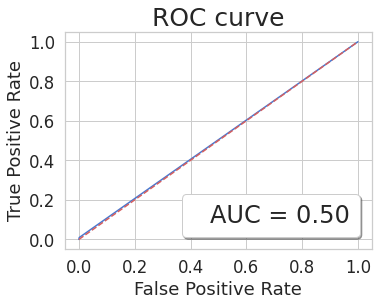

In [ ]:
plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, predict_lists)
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob_list)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

In [ ]:
y_pred_prob_list = []
y_pred_list = []
y_test_batch_list = []

# Loading the best model
# model.load_state_dict(torch.load('./state_dict.pt'))
# model = torch.load(best_model_path)
# model = Model()
# model.load_state_dict(torch.load(best_model_path))

# with torch.no_grad():
#       torch_FCN.eval()
#       for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
#           print(batch_idx)
#           X_test_batch = X_test_batch.to(device)
#           print(f'X_test_batch : {X_test_batch}')
#           y_test_batch = y_test_batch.to(device)
#           # print(X_test_batch)
#           print(f'y_test_batch : {y_test_batch}')

#           #PREDICTION
#           # output = model(X_test_batch)
#           output = torch_FCN(X_test_batch)
#           predict = torch.max(output, 1)
#           print(f'output : {predict}')
          
#           y_pred_prob = torch.sigmoid(output)
#           print(f'y_pred_prob : {y_pred_prob}')
#           y_pred_prob_list.append(y_pred_prob.cpu().numpy())

#           y_pred = torch.round(y_pred_prob)
#           print(f'y_pred : {y_pred}')
#           y_pred_list.append(y_pred.cpu().numpy())

#           # y_test_batch = round(y_test_batch)
#           y_test_batch_list.append(y_test_batch.cpu().numpy())


# with torch.no_grad():
#       torch_FCN.eval()
#       for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
#           print(batch_idx)
#           X_test_batch = X_test_batch.to(device)
#           print(f'X_test_batch : {X_test_batch}')

#           y_test_batch = y_test_batch.to(device)
#           print(f'y_test_batch : {y_test_batch}')

#           #PREDICTION
#           # output = model(X_test_batch)
#           output = torch_FCN(X_test_batch)
#           predict = torch.max(output, 1)
#           print(f'output : {predict}')
          
#           y_pred_prob = torch.sigmoid(output)
#           print(f'y_pred_prob : {y_pred_prob}')
#           y_pred_prob_list.append(y_pred_prob.cpu().numpy())

#           y_pred = torch.round(y_pred_prob)
#           print(f'y_pred : {y_pred}')
#           y_pred_list.append(y_pred.cpu().numpy())

#           # y_test_batch = round(y_test_batch)
#           y_test_batch_list.append(y_test_batch.cpu().numpy())



In [ ]:
# def evaluate(model, test_dataloader, device="cuda"):
#     model.eval()

#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []
    
#     with torch.no_grad():
#         for batch in test_dataloader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)

#             y_predict.append(yhat.cpu().numpy())
#             y_pred_prob = torch.sigmoid(yhat)
#             y_pred = torch.round(y_pred_prob)

#             # predictions.append(yhat_idx.cpu().numpy())
#             labels.append(y_batch.cpu().numpy())           # y_true

#             y_pred_prob_list.append(y_pred_prob)
#             prediction_list.append(y_pred)

#     return predictions, labels,  # Return the model predictions

In [ ]:
# #==================================================================================================
# model = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)

# model_debug = True
# if model_debug:
#     # Evaluate the model
#     # predictions, labels, y_predict, y_pred_prob_list, prediction_list = evaluate(model, test_loader, device=device)

#     model.eval()
#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []    
    
#     with torch.no_grad():
#         for batch in test_loader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)
 
#             labels.append(y_batch.cpu().numpy()) # y_true

#             # ================ prob & predict =================

#             y_pred_prob = torch.sigmoid(yhat)    # prob by sigmoid value 0 to 1
#             y_pred = torch.round(y_pred_prob)    # predict prob >= 0.5 = 1 , prob < 0.5 = 0  

#             y_pred_prob_list.append(y_pred_prob)
#             # prediction_list.append(y_pred)
#             #===================================================
#             # y_prediction = predict(x_batch)
#             # prediction_list.append(y_pred)


#     y_true = np.concatenate(labels, axis=0)
#     print(f'y_true : {y_true}')
#     # y_pred = np.concatenate(predictions, axis=0)
#     # y_predict = np.concatenate(predictions)
#     # print(f'y_pred : {y_predict}')

#     # y_pred = np.concatenate(prediction_list, axis=0)
#     print(prediction_list)
#     # y_pred = np.concatenate(prediction_list)
#     # print(f'y_pred : {y_pred}')

#     acc = accuracy_score(y_true, y_pred)
#     f1_test = f1_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred) 
#     recall = recall_score(y_true, y_pred)
#     class_report = classification_report(y_true, y_pred)
#     confusion_metrix = confusion_matrix(y_true, y_pred)
#     os_cnn_roc_auc = roc_auc_score(y_true, y_pred)

#     print(dataset_name,'test accuracy = ', acc)
#     print(dataset_name,'test f1-score = ', f1_test)
#     print(dataset_name,'test precision = ', precision)
#     print(dataset_name,'test recall = ', recall)
#     print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)
#     print('confusion metric = ', confusion_metrix)
#     print(class_report)

# else:
#     # Final Predictions
#     # predictions, labels = evaluate(model, final_loader, device=device)
#     model.eval()

#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []    
    
#     with torch.no_grad():
#         for batch in test_loader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)

#             y_predict.append(yhat.cpu().np())
#             y_pred_prob = torch.sigmoid(yhat)
#             y_pred = torch.round(y_pred_prob)

#             # predictions.append(yhat_idx.cpu().numpy())
#             labels.append(y_batch.cpu().numpy())           # y_true

#             y_pred_prob_list.append(y_pred_prob)
#             prediction_list.append(y_pred)

#     y_pred = np.concatenate(predictions, axis=0)
#     x_idx = np.arange(X_final_test.shape[0])+1
    
#     final_df = pd.DataFrame({'ImageId':x_idx, 'Label':y_pred})
#     final_df.to_csv('submission.csv', index=False)
#     print('Submission file is ready.')

TypeError: ignored

#### **1_2_OS-CNN_load_saved_model_for_prediction.ipynb**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
# model saved in result log folder
# Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
# dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")

# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   
# dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/UEAArchive_2018/")                              

# dataset_name = "Cryptocurrency"

#batch_size for test
dataset_name = "ETH_Cryptocurrency"
batch_size = 16
print('test dataset:', dataset_name)

test dataset: ETH_Cryptocurrency


In [ ]:
# load data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
# X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# put data to GPU
X_train = torch.from_numpy(X_train)
X_train.requires_grad = False
X_train = X_train.to(device)
X_train = X_train.unsqueeze_(1)
y_train = torch.from_numpy(y_train).to(device)

X_test = torch.from_numpy(X_test)
X_test.requires_grad = False
X_test = X_test.to(device)
X_test = X_test.unsqueeze_(1)
y_test = torch.from_numpy(y_test).to(device)
input_shape = X_train.shape[-1]
n_class = max(y_train) + 1
print('the size of inpute dataset is:',input_shape)
print('number of class is:',n_class)
  
#build dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

code is running on:  cuda:0
the size of inpute dataset is: 30
number of class is: tensor(3, device='cuda:0')


In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

the shape of inpute data is: torch.Size([59623, 1, 30])
the max size of kernel is: 7
the Network structure for ETH_Cryptocurrency is:
[[(1, 56, 1), (1, 56, 2), (1, 56, 3), (1, 56, 5), (1, 56, 7)], [(280, 45, 1), (280, 45, 2), (280, 45, 3), (280, 45, 5), (280, 45, 7)], [(225, 280, 1), (225, 280, 2)]]


In [ ]:
# find model path
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_0/Walk_forward No.2/ETH/30_min/'

best_model_path = Result_log_folder + dataset_name + '/' + dataset_name + 'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_test = eval_model(torch_FCN, test_loader)
f1_test = f1_score(torch_FCN, test_loader)
precision = precision_score(test_loader, torch_FCN) 
recall = recall_score(test_loader, torch_FCN)
class_report = classification_report(test_loader, torch_FCN)
confusion_metrix = confusion_matrix(test_loader, torch_FCN)
os_cnn_roc_auc = roc_auc_score(test_loader, torch_FCN)

sentence = str(acc_test)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)
print(dataset_name,'test f1-score = ', f1_test)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test classification report = ',class_report)
print(dataset_name,'test confusion metric = ',confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

fpr_os_cnn, tpr_os_cnn, thresholds_os_cnn = roc_curve(test_loader, model.predict_proba(torch_FCN)[:,1])

plt.figure()
plt.plot(fpr_os_cnn, tpr_os_cnn, label='OS_CNN(area = %0.5f)' % os_cnn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ETH_Cryptocurrency test acc =  0.7114396394971935


In [ ]:
# https://www.kaggle.com/code/ludovicocuoghi/pytorch-pytorch-lightning-w-optuna-opt
y_pred_prob_list = []
y_pred_list = []


# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

with torch.no_grad():
        model.eval()
        for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
            X_test_batch = X_test_batch.to(DEVICE)
            #PREDICTION
            output = model(X_test_batch)
            y_pred_prob = torch.sigmoid(output)
            y_pred_prob_list.append(y_pred_prob.cpu().numpy())
            y_pred = torch.round(y_pred_prob)
            y_pred_list.append(y_pred.cpu().numpy())

In [ ]:
y_pred_prob_list = [a.squeeze().tolist() for a in y_pred_prob_list]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
print(classification_report(y_test, y_pred_list))

In [ ]:
conf_matrix(y_test, y_pred_list)

In [ ]:
plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_list)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

In [ ]:
# y = []
# for i in range(len(y_predict)):
#   y.append(y_predict[i])
# def sigmoid_output_transform(output):
#     y_pred, y = output
#     y_pred = torch.sigmoid(y_pred)
#     return y_pred, y

def sigmoid_output_transform(output):
    y_pred = output
    y_pred = torch.sigmoid(y_pred)
    return y_pred

y_pred = torch.Tensor(y_predict)  #, requires_grad=True)
print(y_pred[:200])

y_pred = sigmoid_output_transform(y_pred)

print(y_pred[:100])
# print(y[:100])

tensor([2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 1., 1., 1.,
        2., 2., 1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 2.,
        2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2., 2., 1.,
        1., 1., 1., 1., 2., 1., 2., 2., 2., 2., 1., 1., 2., 2., 1., 2., 1., 1.,
        1., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 1., 2., 1., 2., 2., 1., 2.,
        2., 1., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 1., 2.,
        1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 1., 1.,
        2., 2., 2., 2., 1., 1., 2., 2., 1., 2., 2., 1., 1., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 1., 2., 2., 1., 2., 1., 2., 2., 2., 2., 1., 2., 2., 1.,
        2., 1., 2., 1., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
        2., 2., 1., 2., 2., 2., 1., 1., 2., 1., 2., 2., 1., 2., 2., 2., 1., 2.,
        2., 1.])
tensor([0.8808, 0.8808, 0.8808, 0.8808, 0.7311, 0.8808, 0.7311, 0.8808, 0.8808,
        0.8808, 0.8808,

In [ ]:
all_y_true = []
all_y_pred = []

# with torch.no_grad():
pred_y1 = torch.sigmoid(y_pred)
y_pred = pred_y1.cpu().numpy()
y_pred = y_pred > 0.5
y_pred = y_pred.reshape(-1)
y_pred = y_pred.astype(np.uint8)

# all_y_pred.extend(y_pred)

# # Calculate image-level ROC AUC score
# y_true = all_y_true
# y_pred = all_y_pred

# fpr, tpr, _ = roc_curve(y_true, y_pred)
# roc_auc = roc_auc_score(y_true, y_pred)

# plt.figure(1)
# lw = 2
# plt.plot(fpr, tpr, color="darkorange", label="CNN (area = {:.3f})".format(roc_auc))
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc="lower right")
# plt.show()


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print(y_pred[12800:] )
print(len(y_pred))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
13125


In [ ]:
fpr_os_cnn, tpr_os_cnn, thresholds_os_cnn = roc_curve(y_test, y_predict)
# fpr_os_cnn, tpr_os_cnn, thresholds_os_cnn = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr_os_cnn, tpr_os_cnn, color="darkorange",label='OS_CNN(area = %0.5f)' % os_cnn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve')
plt.legend(loc="lower right")
plt.show()

ValueError: ignored

### **Walk forward no.1** 

In [ ]:
import os
from os.path import dirname
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader
# from utils.dataloader.TSC_data_loader import TSC_data_loader                         # .tsv
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader_from_mat   # .mat
from Classifiers.OS_CNN.OS_CNN_easy_use import OS_CNN_easy_use
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

#### **1_1_OS-CNN_easy_use_Run_and_Save_Model.ipynb**

In [ ]:
# Result_log_folder = './Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Results_of_OS_CNN_for_multivariate\OS_CNN_result_iter_0
# dataset_path = dirname("./Example_Datasets/UEAArchive_2018/")                              # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Datasets\UEAArchive_2018

# Split_tain_test
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/60_min/'   
# Walk_forward No.1
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/20_min/'   
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/60_min/'
# Walk_forward No.2
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/60_min/'
# Walk_forward No.3
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/60_min/'

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_1min/")                              

dataset_name = [
"ETH_Cryptocurrency",
]

start = time.time()

# for dataset_name in dataset_name_list:
for dataset_name in dataset_name:
    print('running at:', dataset_name)   
    
    # load multivariate data
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader(dataset_path, dataset_name)    # Multivariate
    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
    # X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)                 # Univariate
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader_from_mat( dataset_path, dataset_name )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    
    print('train data type', type(X_train))
    print('train label type',type(y_train))
    print('train data type', type(X_train[0]))
    print('train label type',type(y_train[0]))
    print('train data type', type(X_train[0][0]))
    # print('train label type',type(y_train[0][0]))

    print('val data shape',X_val.shape)
    print('val label shape',y_val.shape)
    
    print('unique train label',np.unique(y_train))
    print('unique val label',np.unique(y_val))
        
    # creat model and log save place
    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder
        dataset_name = dataset_name,      # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu 
        # device = "cuda:0",                     # Tpu 
        max_epoch = 500,                       # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128]
        # paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128]    # Multivariate
        # paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],                    # Univariate
                            )
    
    # X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()

    model.fit(X_train, y_train, X_val, y_val)

    y_predict = model.predict(X_test)
    print('correct:',y_test)
    print('predict:',y_predict)
    
    acc = accuracy_score(y_test, y_predict)
    f1 =  f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict) 
    recall = recall_score(y_test, y_predict)
    class_report = classification_report(y_test, y_predict)
    confusion_metrix = confusion_matrix(y_test, y_predict)
    os_cnn_roc_auc = roc_auc_score(y_test, y_predict)
    
    print(dataset_name,'test acc = ', acc)
    print(dataset_name,'test f1-score = ', f1)
    print(dataset_name,'test precision-score = ', precision)
    print(dataset_name,'test recall-score = ', recall)
    print(dataset_name,'test classification report = ',class_report)
    print(dataset_name,'test confusion metric = ',confusion_metrix)
    print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

done = time.time()
print(f'Time : {done - start}')

running at: ETH_Cryptocurrency
train data shape (61412, 30)
train label shape (61412,)
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.ndarray'>
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.int64'>
train data type <class 'numpy.float32'>
val data shape (13097, 30)
val label shape (13097,)
unique train label [0 1]
unique val label [0 1]
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5323552400182375 	 test_acc=	 0.5343971901962281 	 loss=	 0.6091402769088745
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_0/Walk_forward No.1/ETH/30_min/ETH_Cryptocurrency/ETH_Cryptocurrency_.txt
epoch = 99 lr =  0.001
train_acc=	 0.5067250700188888 	 test_acc=	 0.5088188134687333 	 loss=	 0.8047248721122742
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of

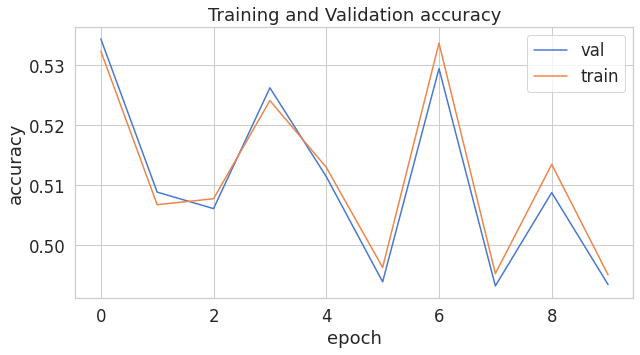

In [ ]:
epoch = [49, 99, 149, 199, 249, 
         299, 349, 399, 449, 499]
lr =  [0.001, 0.0005, 0.00025, 0.000125, 0.0001, 
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
train_acc =	 [0.5323552400182375, 0.5067250700188888, 0.5077183612323325, 0.5240995245228945, 
              0.5129616361623136, 0.4962548036214421, 0.5336904839445059, 0.4952289454829675, 
              0.5134501400377777, 0.4950172604702664]

val_acc =	[0.5343971901962281, 0.5088188134687333, 0.5060700923875697, 0.5262273803161029, 
             0.5114148278231656, 0.4938535542490647, 0.5294342215774605, 0.4931663739787738, 
             0.5087424601053676, 0.4933954340688707]

loss = [0.6091402769088745, 0.8047248721122742, 0.5447470545768738, 0.4596536159515381, 
        0.9065260887145996, 0.3299749493598938, 0.4094763994216919, 0.6409969329833984, 
        0.6954231262207031, 0.8112090826034546]


plt.figure(figsize=(10,5))
plt.title("Training and Validation accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

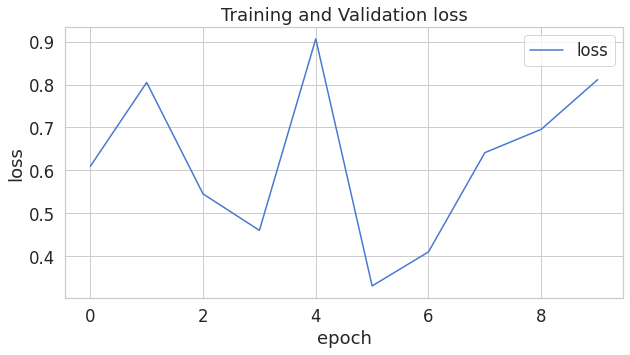

In [ ]:
# Loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation loss")
# plt.plot(val_acc,label="val")
plt.plot(loss,label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### **(Round2) 1_1_OS-CNN_easy_use_Run_and_Save_Model.ipynb**

In [ ]:
import os
from sklearn.metrics import accuracy_score
from os.path import dirname
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# from utils import save_model, save_plots, SaveBestModel

from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
class SaveBestModel:
      """
      Class to save the best model while training. If the current epoch's 
      validation loss is less than the previous least less, then save the
      model state.
      """
      def __init__(
          self, best_valid_loss=float('inf')
      ):
          self.best_valid_loss = best_valid_loss
          
      def __call__(
          self, current_valid_loss, 
          epoch, model, optimizer, criterion
      ):
          if current_valid_loss < self.best_valid_loss:
              self.best_valid_loss = current_valid_loss
              print(f"\nBest validation loss: {self.best_valid_loss}")
              print(f"\nSaving best model for epoch: {epoch+1}\n")
              torch.save({
                  'epoch': epoch+1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': criterion,
                  }, 'outputs/best_model.pth')
          
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/ETH_Cryptocurrency/final_model.pth')

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/ETH_Cryptocurrency/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/ETH_Cryptocurrency/loss.png')


In [ ]:
class OS_CNN_easy_use():
    
    def __init__(self,Result_log_folder, 
                 dataset_name, 
                 device, 
                 start_kernel_size = 1,
                 Max_kernel_size = 89, 
                 paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128], 
                 max_epoch = 2000, 
                 batch_size=16,
                 print_result_every_x_epoch = 50,
                 lr = 0.001
                ):
        
        super(OS_CNN_easy_use, self).__init__()
        
        if not os.path.exists(Result_log_folder +dataset_name+'/'):
            os.makedirs(Result_log_folder +dataset_name+'/')
        Initial_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'initial_model'
        model_save_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'
        

        self.Result_log_folder = Result_log_folder
        self.dataset_name = dataset_name        
        self.model_save_path = model_save_path
        self.Initial_model_path = Initial_model_path
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        
        self.start_kernel_size = start_kernel_size
        self.Max_kernel_size = Max_kernel_size
        self.paramenter_number_of_layer_list = paramenter_number_of_layer_list
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.print_result_every_x_epoch = print_result_every_x_epoch
        self.lr = lr
        self.OS_CNN = None

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # training
    # def train(model, trainloader, optimizer, criterion):
    #     model.train()
    #     print('Training')
    #     train_running_loss = 0.0
    #     train_running_correct = 0
    #     counter = 0
    #     for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    #         counter += 1
    #         image, labels = data
    #         image = image.to(device)
    #         labels = labels.to(device)
    #         optimizer.zero_grad()
            
    #         # forward pass
    #         # outputs = model(image)
    #         outputs = model(data[0])
    #         # calculate the loss
    #         loss = criterion(outputs, data[1])
    #         train_running_loss += loss.item()
    #         # calculate the accuracy
    #         _, preds = torch.max(outputs.data, 1)
    #         train_running_correct += (preds == data[1]).sum().item()
    #         # backpropagation
    #         loss.backward()
    #         # update the optimizer parameters
    #         optimizer.step()
        
    #     # loss and accuracy for the complete epoch
    #     epoch_loss = train_running_loss / counter
    #     epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    #     return epoch_loss, epoch_acc
    
    # # validation
    # def validate(model, testloader, criterion):
    #     model.eval()
    #     print('Validation')
    #     valid_running_loss = 0.0
    #     valid_running_correct = 0
    #     counter = 0
    #     with torch.no_grad():
    #         for i, data in tqdm(enumerate(testloader), total=len(testloader)):
    #             counter += 1
                
    #             # image, labels = data
    #             # image = image.to(device)
    #             # labels = labels.to(device)
    #             # forward pass
    #             # outputs = model(image)
    #             outputs = model(data[0])

    #             # calculate the loss
    #             loss = criterion(outputs, data[1])
    #             valid_running_loss += loss.item()
    #             # calculate the accuracy
    #             _, preds = torch.max(outputs.data, 1)
    #             valid_running_correct += (preds == data[1]).sum().item()
        
    #     # loss and accuracy for the complete epoch
    #     epoch_loss = valid_running_loss / counter
    #     epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    #     return epoch_loss, epoch_acc
    
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@        
        
    def fit(self, X_train, y_train, X_val, y_val):

        print('code is running on ',self.device)
        
        
        # covert numpy to pytorch tensor and put into gpu
        X_train = torch.from_numpy(X_train)
        X_train.requires_grad = False
        X_train = X_train.to(self.device)
        y_train = torch.from_numpy(y_train).to(self.device)
        
        
        X_test = torch.from_numpy(X_val)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)
        y_test = torch.from_numpy(y_val).to(self.device)
        
        
        # add channel dimension to time series data
        if len(X_train.shape) == 2:
            X_train = X_train.unsqueeze_(1)
            X_test = X_test.unsqueeze_(1)

        input_shape = X_train.shape[-1]
        n_class = max(y_train) + 1
        receptive_field_shape= min(int(X_train.shape[-1]/4),self.Max_kernel_size)
        
        # generate parameter list
        layer_parameter_list = generate_layer_parameter_list(self.start_kernel_size,
                                                             receptive_field_shape,
                                                             self.paramenter_number_of_layer_list,
                                                             in_channel = int(X_train.shape[1]))
        
        
        torch_OS_CNN = OS_CNN(layer_parameter_list, n_class.item(), False).to(self.device)
        
        # save_initial_weight
        torch.save(torch_OS_CNN.state_dict(), self.Initial_model_path)
        
        
        # loss, optimizer, scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(torch_OS_CNN.parameters(),lr= self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=0.0001)
        # initialize SaveBestModel class
        save_best_model = SaveBestModel()
        
        # build dataloader
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=True)
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=False)
        
        
        torch_OS_CNN.train()   

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # lists to keep track of losses and accuracies
        train_loss = [] 
        valid_loss = []
        train_acc = [] 
        valid_acc = []
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        
        for i in range(self.max_epoch):
            print(f'epoch No.', i)          

          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            # print(f"[INFO]: Epoch {i+1} of {i}")
            # train_epoch_loss, train_epoch_acc = train(torch_OS_CNN, train_loader, optimizer, criterion)
            # valid_epoch_loss, valid_epoch_acc = validate(torch_OS_CNN, test_loader, criterion)
            # train_loss.append(train_epoch_loss)
            # valid_loss.append(valid_epoch_loss)
            # train_acc.append(train_epoch_acc)
            # valid_acc.append(valid_epoch_acc)
            # print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
            # print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

            # # save the best model till now if we have the least loss in the current epoch
            # save_best_model(valid_epoch_loss, i, torch_OS_CNN, optimizer, criterion)

         # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
            train_running_loss = 0.0
            train_running_correct = 0
            counter = 0
            for sample in train_loader:
                counter += 1
                optimizer.zero_grad()
                y_predict = torch_OS_CNN(sample[0])
                output = criterion(y_predict, sample[1])

                train_running_loss += output.item()
                # calculate the accuracy
                _, preds = torch.max(y_predict, 1)
                train_running_correct += (preds == sample[1]).sum().item()

                output.backward()
                optimizer.step()

            scheduler.step(output)
            # loss and accuracy for the complete epoch
            train_epoch_loss = float(train_running_loss) / float(counter)
            train_epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
            train_loss.append(train_epoch_loss)
            train_acc.append(train_epoch_acc)
            print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            valid_running_loss = 0.0
            valid_running_correct = 0
            counters = 0
            for sample in test_loader:
                counters += 1
                optimizer.zero_grad()
                y_predict = torch_OS_CNN(sample[0])
                output = criterion(y_predict, sample[1])

                valid_running_loss += output.item()
                # calculate the accuracy
                _, preds = torch.max(y_predict, 1)
                valid_running_correct += (preds == sample[1]).sum().item()

                output.backward()
                optimizer.step()

            scheduler.step(output)
            # loss and accuracy for the complete epoch
            valid_epoch_loss = float(valid_running_loss) / float(counters)
            valid_epoch_acc = 100. * (valid_running_correct / len(test_loader.dataset))
            valid_loss.append(valid_epoch_loss)
            valid_acc.append(valid_epoch_acc)
            print(f"valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}")

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


            if eval_condition(i,self.print_result_every_x_epoch):
                for param_group in optimizer.param_groups:
                    print('epoch =',i, 'lr = ', param_group['lr'])
                torch_OS_CNN.eval()
                acc_train = eval_model(torch_OS_CNN, train_loader)
                acc_test = eval_model(torch_OS_CNN, test_loader)
                torch_OS_CNN.train()
                print('train_acc=\t', acc_train, '\t test_acc=\t', acc_test, '\t loss=\t', output.item())
                sentence = 'train_acc=\t'+str(acc_train)+ '\t test_acc=\t'+str(acc_test) 
                print('log saved at:')
                save_to_log(sentence,self.Result_log_folder, self.dataset_name)
                torch.save(torch_OS_CNN.state_dict(), self.model_save_path)

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            # save the trained model weights for a final time
            save_model(i, torch_OS_CNN, optimizer, criterion)
            # save the loss and accuracy plots
            save_plots(train_acc, valid_acc, train_loss, valid_loss)
            print('TRAINING COMPLETE')

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        torch.save(torch_OS_CNN.state_dict(), self.model_save_path)
        self.OS_CNN = torch_OS_CNN

        
        
    def predict(self, X_test):
        
        X_test = torch.from_numpy(X_test)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)
        
        if len(X_test.shape) == 2:
            X_test = X_test.unsqueeze_(1)
        
        test_dataset = TensorDataset(X_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_test.shape[0] / 10, self.batch_size)),2), shuffle=False)
        
        self.OS_CNN.eval()
        
        predict_list = np.array([])
        for sample in test_loader:
            y_predict = self.OS_CNN(sample[0])
            y_predict = y_predict.detach().cpu().numpy()
            y_predict = np.argmax(y_predict, axis=1)
            predict_list = np.concatenate((predict_list, y_predict), axis=0)
            
        return predict_list


In [ ]:
# Result_log_folder = './Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Results_of_OS_CNN_for_multivariate\OS_CNN_result_iter_0
# dataset_path = dirname("./Example_Datasets/UEAArchive_2018/")                              # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Datasets\UEAArchive_2018

# Split_tain_test
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/60_min/'   
# Walk_forward No.1
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/20_min/'   
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/60_min/'
# Walk_forward No.2
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/60_min/'
# Walk_forward No.3
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/60_min/'

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_1min/")                              

dataset_name = [
"ETH_Cryptocurrency",
]

start = time.time()

# for dataset_name in dataset_name_list:
for dataset_name in dataset_name:
    print('running at:', dataset_name)   
    
    # load multivariate data
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader(dataset_path, dataset_name)    # Multivariate
    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
    # X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)                 # Univariate
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader_from_mat( dataset_path, dataset_name )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    
    print('train data type', type(X_train))
    print('train label type',type(y_train))
    print('train data type', type(X_train[0]))
    print('train label type',type(y_train[0]))
    print('train data type', type(X_train[0][0]))
    # print('train label type',type(y_train[0][0]))

    print('val data shape',X_val.shape)
    print('val label shape',y_val.shape)
    
    print('unique train label',np.unique(y_train))
    print('unique val label',np.unique(y_val))
        
    # creat model and log save place
    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder
        dataset_name = dataset_name,      # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu 
        # device = "cuda:0",                     # Tpu 
        max_epoch = 500,                       # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128]
        # paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128]    # Multivariate
        # paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],                    # Univariate
                            )
    
    # X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()

    model.fit(X_train, y_train, X_val, y_val)

    y_predict = model.predict(X_test)
    print('correct:',y_test)
    print('predict:',y_predict)
    
    acc = accuracy_score(y_test, y_predict)
    f1 =  f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict) 
    recall = recall_score(y_test, y_predict)
    class_report = classification_report(y_test, y_predict)
    confusion_metrix = confusion_matrix(y_test, y_predict)
    os_cnn_roc_auc = roc_auc_score(y_test, y_predict)
    
    print(dataset_name,'test acc = ', acc)
    print(dataset_name,'test f1-score = ', f1)
    print(dataset_name,'test precision-score = ', precision)
    print(dataset_name,'test recall-score = ', recall)
    print(dataset_name,'test classification report = ',class_report)
    print(dataset_name,'test confusion metric = ',confusion_metrix)
    print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

done = time.time()
print(f'Time : {done - start}')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(y_predict)
print(f'len(predict_lists) : {len(y_predict)}')
# print(f'len(predict_lists[0]) : {len(predict_lists[0])}')
# print(f'len(predict_lists[0][0]) : {len(predict_lists[0][0])}')
# print(f'len(predict_lists[0][0][0]) : {len(predict_lists[0][0][0])}')
# print(f'len(predict_lists[0][0][0][0]) : {len(predict_lists[0][0][0][0])}')

print(f'type(predict_lists[0]) : {type(y_predict[0])}')
# print(f'type(predict_lists[0][0]) : {type(predict_lists[0][0])}')
# print(f'type(predict_lists[0][0][0]) : {type(predict_lists[0][0][0])}')
# print(f'type(predict_lists[0][0][0][0]) : {type(predict_lists[0][0][0][0])}')

value_counts = pd.DataFrame(y_predict).value_counts()
print(value_counts)

print(f'predict_lists[:1500] : {y_predict[:1500]}')
print(f'predict_lists[11246:] : {y_predict[11246:]}')

# =============================================================================
# y_pred_prob_list = []
# labels = []

# print(f'y_pred_prob_lists[:100] : {y_pred_prob_list[:5]}')
# print(f'count labels : {len(labels)}')
print(f'y_test : {y_test}')
print(f'count y_test :{len(y_test)}')

[1. 1. 0. ... 0. 0. 0.]
len(predict_lists) : 10873
type(predict_lists[0]) : <class 'numpy.float64'>
0.0    10820
1.0       53
dtype: int64
predict_lists[:1500] : [1. 1. 0. ... 0. 0. 0.]
predict_lists[11246:] : []
y_test : [1 1 1 ... 1 0 1]
count y_test :10873


In [ ]:
acc = accuracy_score(y_test, y_predict)
f1 =  f1_score(y_test, y_predict)
precision = precision_score(y_test, y_predict) 
recall = recall_score(y_test, y_predict)
class_report = classification_report(y_test, y_predict)
confusion_metrix = confusion_matrix(y_test, y_predict)
os_cnn_roc_auc = roc_auc_score(y_test, y_predict)

print(dataset_name,'test acc = ', acc)
print(dataset_name,'test f1-score = ', f1)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test classification report = ',class_report)
print(dataset_name,'test confusion metric = ',confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

ETH_Cryptocurrency test acc =  0.49057297893865537
ETH_Cryptocurrency test f1-score =  0.014237408791599928
ETH_Cryptocurrency test precision-score =  0.7547169811320755
ETH_Cryptocurrency test recall-score =  0.007186489399928135
ETH_Cryptocurrency test classification report =                precision    recall  f1-score   support

           0       0.49      1.00      0.66      5307
           1       0.75      0.01      0.01      5566

    accuracy                           0.49     10873
   macro avg       0.62      0.50      0.34     10873
weighted avg       0.63      0.49      0.33     10873

ETH_Cryptocurrency test confusion metric =  [[5294   13]
 [5526   40]]
ETH_Cryptocurrency test roc_auc =  0.5023684472626172


#### **1_2_OS-CNN_load_saved_model_for_prediction.ipynb**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
# model saved in result log folder
# Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
# dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/")                              

#batch_size for test
dataset_name = "ETH_Cryptocurrency"
batch_size = 16
print('test dataset:', dataset_name)

test dataset: ETH_Cryptocurrency


In [ ]:
# load data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
# X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

# X_train = X_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# X_test = X_test.astype(np.float32)

# # put data to GPU
# X_train = torch.from_numpy(X_train)
# X_train.requires_grad = False
# X_train = X_train.to(device)
# X_train = X_train.unsqueeze_(1)
# y_train = torch.from_numpy(y_train).to(device)

# X_test = torch.from_numpy(X_test)
# X_test.requires_grad = False
# X_test = X_test.to(device)
# X_test = X_test.unsqueeze_(1)
# y_test = torch.from_numpy(y_test).to(device)
# input_shape = X_train.shape[-1]
# n_class = max(y_train) + 1

# print('the size of inpute dataset is:',input_shape)
# print('number of class is:',n_class)
  
# #build dataloader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

# test_dataset = TensorDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

X_train_data = X_train.astype(np.float32)
X_val_data = X_val.astype(np.float32)
X_test_data = X_test.astype(np.float32)

# put data to GPU
X_train_data = torch.from_numpy(X_train_data)
X_train_data.requires_grad = False
X_train_data = X_train_data.to(device)
X_train_data = X_train_data.unsqueeze_(1)
y_train_data = torch.from_numpy(y_train).to(device)

X_val_data = torch.from_numpy(X_val_data)
X_val_data.requires_grad = False
X_val_data = X_val_data.to(device)
X_val_data = X_val_data.unsqueeze_(1)
y_val_data = torch.from_numpy(y_val).to(device)

X_test_data = torch.from_numpy(X_test_data)
X_test_data.requires_grad = False
X_test_data = X_test_data.to(device)
X_test_data = X_test_data.unsqueeze_(1)
y_test_data = torch.from_numpy(y_test).to(device)
input_shape = X_train_data.shape[-1]
n_class = max(y_train_data) + 1
# n_class =  max(y_train) - 1

print('the size of inpute dataset is:',input_shape)   # 30
print('number of class is:',n_class)    # 2
  
#build dataloader
train_dataset = TensorDataset(X_train_data, y_train_data)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=True)

val_dataset = TensorDataset(X_val_data, y_val_data)
val_loader = DataLoader(val_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=False)

test_dataset = TensorDataset(X_test_data, y_test_data)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=False)

code is running on:  cuda:0
the size of inpute dataset is: 30
number of class is: tensor(2, device='cuda:0')


In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train_data.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train_data.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

the shape of inpute data is: torch.Size([59642, 1, 30])
the max size of kernel is: 7
the Network structure for ETH_Cryptocurrency is:
[[(1, 56, 1), (1, 56, 2), (1, 56, 3), (1, 56, 5), (1, 56, 7)], [(280, 45, 1), (280, 45, 2), (280, 45, 3), (280, 45, 5), (280, 45, 7)], [(225, 280, 1), (225, 280, 2)]]


In [ ]:
# find model path
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'   
best_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_val = eval_model(torch_FCN, val_loader)
acc_test = eval_model(torch_FCN, test_loader)

sentence_test = str(acc_test)
sentence_val = str(acc_val)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)
print(dataset_name,'validation acc = ', acc_val)

ETH_Cryptocurrency test acc =  0.5420191319471895
ETH_Cryptocurrency validation acc =  0.539850216791486


In [ ]:
# ==================== Predict ==================== 
X_tests = torch.from_numpy(X_test)
X_tests.requires_grad = False
X_tests = X_tests.to(device)

if len(X_tests.shape) == 2:
    X_tests = X_tests.unsqueeze_(1)

test_datasets = TensorDataset(X_tests)
test_loaders = DataLoader(test_datasets, batch_size=max(int(min(X_tests.shape[0] / 10, batch_size)),2), shuffle=False)

# OS_CNN.eval()
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

predict_lists = np.array([])

for sample in test_loader:
    y_predicts = torch_FCN(sample[0]).to(device)
    y_predicts = y_predicts.detach().cpu().numpy()
    y_predicts = np.argmax(y_predicts, axis=1)
    predict_lists = np.concatenate((predict_lists, y_predicts), axis=0)

print(predict_lists)
# y_predict = predict(X_test)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
# # ==================== Predict ==================== 
# import torch.nn.functional as F

# X_tests = torch.from_numpy(X_test)
# X_tests.requires_grad = False
# X_tests = X_tests.to(device)

# if len(X_tests.shape) == 2:
#     X_tests = X_tests.unsqueeze_(1)

# test_datasets = TensorDataset(X_tests)
# test_loaders = DataLoader(test_datasets, batch_size=max(int(min(X_tests.shape[0] / 10, batch_size)),2), shuffle=False)

# # OS_CNN.eval()
# torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
# torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
# torch_FCN.eval()

# predict_lists = np.array([])
# # ============================================
# # y_pred_prob_list = np.array([])
# y_pred_prob_list = []
# labels = []
# # ============================================

# for sample in test_loader:
#     y_predicts = torch_FCN(sample[0]).to(device)
#     # print('y_predicts 1 :', y_predicts)
#     # print('type y_predicts 1 :', type(y_predicts)) # <class 'torch.Tensor'>

#     # ============================================
#     y_pred_prob = torch.sigmoid(y_predicts)
#     # y_pred_prob = F.softmax(y_predicts, dim=0)
#     # print('type y_predicts prob 1 :', type(y_pred_prob)) # <class 'torch.Tensor'>
#     y_pred_prob = y_pred_prob.detach().cpu().numpy()
#     # print('type y_predicts prob 2 :', type(y_pred_prob)) # <class 'numpy.ndarray'>
#     y_pred_prob_list.append(y_pred_prob)

#     # ============================================

#     y_predicts = y_predicts.detach().cpu().numpy()
#     # print('y_predicts 2 :', y_predicts)    
#     # print('type y_predicts 2 :', type(y_predicts)) # <class 'numpy.ndarray'>

#     y_predicts = np.argmax(y_predicts, axis=1)
#     # print('y_predicts 3 :', y_predicts)
#     # print('type y_predicts 3 :', type(y_predicts)) # <class 'numpy.ndarray'>

#     predict_lists = np.concatenate((predict_lists, y_predicts), axis=0)
#     # print('y_predicts list 4 :', predict_lists)
#     # print('y_predicts list 4 :', len(predict_lists))
#     # print('type y_predicts list 4 :', type(predict_lists)) # <class 'numpy.ndarray'>

#     # y_pred_prob_list = np.concatenate((y_pred_prob_list, y_pred_prob) .detach().cpu().numpy())

#     # y_testdata = torch_FCN(sample[1]).to(device)
#     # y_testdata.cpu().numpy())
#     # labels = concatenate((labels, y_testdata), axis=0)
#     # y_pred_prob = torch.sigmoid(y_predicts)
#     # y_pred_prob_list.append(y_pred_prob)
#     # labels.append(sample[1].to(device).detach().cpu().numpy())

# # print(predict_lists)


In [ ]:
print(predict_lists)
print(f'len(predict_lists) : {len(predict_lists)}')
# print(f'len(predict_lists[0]) : {len(predict_lists[0])}')
# print(f'len(predict_lists[0][0]) : {len(predict_lists[0][0])}')
# print(f'len(predict_lists[0][0][0]) : {len(predict_lists[0][0][0])}')
# print(f'len(predict_lists[0][0][0][0]) : {len(predict_lists[0][0][0][0])}')

print(f'type(predict_lists[0]) : {type(predict_lists[0])}')
# print(f'type(predict_lists[0][0]) : {type(predict_lists[0][0])}')
# print(f'type(predict_lists[0][0][0]) : {type(predict_lists[0][0][0])}')
# print(f'type(predict_lists[0][0][0][0]) : {type(predict_lists[0][0][0][0])}')

value_counts = pd.DataFrame(predict_lists).value_counts()
print(value_counts)

print(f'predict_lists[:1500] : {predict_lists[:1500]}')
print(f'predict_lists[11246:] : {predict_lists[11246:]}')

# =============================================================================
# y_pred_prob_list = []
# labels = []

# print(f'y_pred_prob_lists[:100] : {y_pred_prob_list[:5]}')
# print(f'count labels : {len(labels)}')
print(f'y_test : {y_test}')
print(f'count y_test :{len(y_test)}')

[1. 1. 1. ... 1. 1. 1.]
len(predict_lists) : 12649
type(predict_lists[0]) : <class 'numpy.float64'>
1.0    12088
0.0      561
dtype: int64
predict_lists[:1500] : [1. 1. 1. ... 1. 1. 1.]
predict_lists[11246:] : [1. 1. 1. ... 1. 1. 1.]
y_test : [1 1 1 ... 1 1 0]
count y_test :12649


In [ ]:
class_report = classification_report(y_test, predict_lists)
accuracy = accuracy_score(y_test, predict_lists)
f1_test = f1_score(y_test, predict_lists)
precision = precision_score(y_test, predict_lists) 
recall = recall_score(y_test, predict_lists)
confusion_metrix = confusion_matrix(y_test, predict_lists)
os_cnn_roc_auc = roc_auc_score(y_test, predict_lists)

print(class_report)
print(dataset_name,'test accuracy = ', accuracy)
print(dataset_name,'test f1-score = ', f1_test)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test confusion metric = ')
print(confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

              precision    recall  f1-score   support

           0       0.89      0.08      0.15      6232
           1       0.53      0.99      0.69      6417

    accuracy                           0.54     12649
   macro avg       0.71      0.54      0.42     12649
weighted avg       0.71      0.54      0.42     12649

ETH_Cryptocurrency test accuracy =  0.5420191319471895
ETH_Cryptocurrency test f1-score =  0.6869494731153742
ETH_Cryptocurrency test precision-score =  0.5258107213765718
ETH_Cryptocurrency test recall-score =  0.9904940003116721
ETH_Cryptocurrency test confusion metric = 
[[ 500 5732]
 [  61 6356]]
ETH_Cryptocurrency test roc_auc =  0.5353625328901108


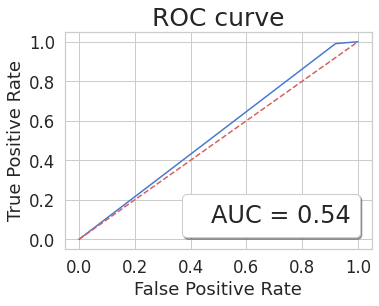

In [ ]:
plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, predict_lists)
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob_list)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

In [ ]:
y_pred_prob_list = []
y_pred_list = []
y_test_batch_list = []

# Loading the best model
# model.load_state_dict(torch.load('./state_dict.pt'))
# model = torch.load(best_model_path)
# model = Model()
# model.load_state_dict(torch.load(best_model_path))

# with torch.no_grad():
#       torch_FCN.eval()
#       for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
#           print(batch_idx)
#           X_test_batch = X_test_batch.to(device)
#           print(f'X_test_batch : {X_test_batch}')
#           y_test_batch = y_test_batch.to(device)
#           # print(X_test_batch)
#           print(f'y_test_batch : {y_test_batch}')

#           #PREDICTION
#           # output = model(X_test_batch)
#           output = torch_FCN(X_test_batch)
#           predict = torch.max(output, 1)
#           print(f'output : {predict}')
          
#           y_pred_prob = torch.sigmoid(output)
#           print(f'y_pred_prob : {y_pred_prob}')
#           y_pred_prob_list.append(y_pred_prob.cpu().numpy())

#           y_pred = torch.round(y_pred_prob)
#           print(f'y_pred : {y_pred}')
#           y_pred_list.append(y_pred.cpu().numpy())

#           # y_test_batch = round(y_test_batch)
#           y_test_batch_list.append(y_test_batch.cpu().numpy())


# with torch.no_grad():
#       torch_FCN.eval()
#       for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
#           print(batch_idx)
#           X_test_batch = X_test_batch.to(device)
#           print(f'X_test_batch : {X_test_batch}')

#           y_test_batch = y_test_batch.to(device)
#           print(f'y_test_batch : {y_test_batch}')

#           #PREDICTION
#           # output = model(X_test_batch)
#           output = torch_FCN(X_test_batch)
#           predict = torch.max(output, 1)
#           print(f'output : {predict}')
          
#           y_pred_prob = torch.sigmoid(output)
#           print(f'y_pred_prob : {y_pred_prob}')
#           y_pred_prob_list.append(y_pred_prob.cpu().numpy())

#           y_pred = torch.round(y_pred_prob)
#           print(f'y_pred : {y_pred}')
#           y_pred_list.append(y_pred.cpu().numpy())

#           # y_test_batch = round(y_test_batch)
#           y_test_batch_list.append(y_test_batch.cpu().numpy())



In [ ]:
# def evaluate(model, test_dataloader, device="cuda"):
#     model.eval()

#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []
    
#     with torch.no_grad():
#         for batch in test_dataloader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)

#             y_predict.append(yhat.cpu().numpy())
#             y_pred_prob = torch.sigmoid(yhat)
#             y_pred = torch.round(y_pred_prob)

#             # predictions.append(yhat_idx.cpu().numpy())
#             labels.append(y_batch.cpu().numpy())           # y_true

#             y_pred_prob_list.append(y_pred_prob)
#             prediction_list.append(y_pred)

#     return predictions, labels,  # Return the model predictions

In [ ]:
# #==================================================================================================
# model = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)

# model_debug = True
# if model_debug:
#     # Evaluate the model
#     # predictions, labels, y_predict, y_pred_prob_list, prediction_list = evaluate(model, test_loader, device=device)

#     model.eval()
#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []    
    
#     with torch.no_grad():
#         for batch in test_loader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)
 
#             labels.append(y_batch.cpu().numpy()) # y_true

#             # ================ prob & predict =================

#             y_pred_prob = torch.sigmoid(yhat)    # prob by sigmoid value 0 to 1
#             y_pred = torch.round(y_pred_prob)    # predict prob >= 0.5 = 1 , prob < 0.5 = 0  

#             y_pred_prob_list.append(y_pred_prob)
#             # prediction_list.append(y_pred)
#             #===================================================
#             # y_prediction = predict(x_batch)
#             # prediction_list.append(y_pred)


#     y_true = np.concatenate(labels, axis=0)
#     print(f'y_true : {y_true}')
#     # y_pred = np.concatenate(predictions, axis=0)
#     # y_predict = np.concatenate(predictions)
#     # print(f'y_pred : {y_predict}')

#     # y_pred = np.concatenate(prediction_list, axis=0)
#     print(prediction_list)
#     # y_pred = np.concatenate(prediction_list)
#     # print(f'y_pred : {y_pred}')

#     acc = accuracy_score(y_true, y_pred)
#     f1_test = f1_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred) 
#     recall = recall_score(y_true, y_pred)
#     class_report = classification_report(y_true, y_pred)
#     confusion_metrix = confusion_matrix(y_true, y_pred)
#     os_cnn_roc_auc = roc_auc_score(y_true, y_pred)

#     print(dataset_name,'test accuracy = ', acc)
#     print(dataset_name,'test f1-score = ', f1_test)
#     print(dataset_name,'test precision = ', precision)
#     print(dataset_name,'test recall = ', recall)
#     print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)
#     print('confusion metric = ', confusion_metrix)
#     print(class_report)

# else:
#     # Final Predictions
#     # predictions, labels = evaluate(model, final_loader, device=device)
#     model.eval()

#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []    
    
#     with torch.no_grad():
#         for batch in test_loader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)

#             y_predict.append(yhat.cpu().np())
#             y_pred_prob = torch.sigmoid(yhat)
#             y_pred = torch.round(y_pred_prob)

#             # predictions.append(yhat_idx.cpu().numpy())
#             labels.append(y_batch.cpu().numpy())           # y_true

#             y_pred_prob_list.append(y_pred_prob)
#             prediction_list.append(y_pred)

#     y_pred = np.concatenate(predictions, axis=0)
#     x_idx = np.arange(X_final_test.shape[0])+1
    
#     final_df = pd.DataFrame({'ImageId':x_idx, 'Label':y_pred})
#     final_df.to_csv('submission.csv', index=False)
#     print('Submission file is ready.')

TypeError: ignored

#### **1_2_OS-CNN_load_saved_model_for_prediction.ipynb**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
# model saved in result log folder
# Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
# dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")

# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   
# dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/UEAArchive_2018/")                              

# dataset_name = "Cryptocurrency"

#batch_size for test
dataset_name = "ETH_Cryptocurrency"
batch_size = 16
print('test dataset:', dataset_name)

test dataset: ETH_Cryptocurrency


In [ ]:
# load data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
# X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# put data to GPU
X_train = torch.from_numpy(X_train)
X_train.requires_grad = False
X_train = X_train.to(device)
X_train = X_train.unsqueeze_(1)
y_train = torch.from_numpy(y_train).to(device)

X_test = torch.from_numpy(X_test)
X_test.requires_grad = False
X_test = X_test.to(device)
X_test = X_test.unsqueeze_(1)
y_test = torch.from_numpy(y_test).to(device)
input_shape = X_train.shape[-1]
n_class = max(y_train) + 1
print('the size of inpute dataset is:',input_shape)
print('number of class is:',n_class)
  
#build dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

code is running on:  cuda:0
the size of inpute dataset is: 30
number of class is: tensor(3, device='cuda:0')


In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

the shape of inpute data is: torch.Size([59623, 1, 30])
the max size of kernel is: 7
the Network structure for ETH_Cryptocurrency is:
[[(1, 56, 1), (1, 56, 2), (1, 56, 3), (1, 56, 5), (1, 56, 7)], [(280, 45, 1), (280, 45, 2), (280, 45, 3), (280, 45, 5), (280, 45, 7)], [(225, 280, 1), (225, 280, 2)]]


In [ ]:
# find model path
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_0/Walk_forward No.2/ETH/30_min/'

best_model_path = Result_log_folder + dataset_name + '/' + dataset_name + 'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_test = eval_model(torch_FCN, test_loader)
f1_test = f1_score(torch_FCN, test_loader)
precision = precision_score(test_loader, torch_FCN) 
recall = recall_score(test_loader, torch_FCN)
class_report = classification_report(test_loader, torch_FCN)
confusion_metrix = confusion_matrix(test_loader, torch_FCN)
os_cnn_roc_auc = roc_auc_score(test_loader, torch_FCN)

sentence = str(acc_test)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)
print(dataset_name,'test f1-score = ', f1_test)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test classification report = ',class_report)
print(dataset_name,'test confusion metric = ',confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

fpr_os_cnn, tpr_os_cnn, thresholds_os_cnn = roc_curve(test_loader, model.predict_proba(torch_FCN)[:,1])

plt.figure()
plt.plot(fpr_os_cnn, tpr_os_cnn, label='OS_CNN(area = %0.5f)' % os_cnn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ETH_Cryptocurrency test acc =  0.7114396394971935


### **Walk forward no.2** 

In [ ]:
import os
from os.path import dirname
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader
# from utils.dataloader.TSC_data_loader import TSC_data_loader                         # .tsv
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader_from_mat   # .mat
from Classifiers.OS_CNN.OS_CNN_easy_use import OS_CNN_easy_use
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

#### **1_1_OS-CNN_easy_use_Run_and_Save_Model.ipynb**

In [ ]:
# Result_log_folder = './Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Results_of_OS_CNN_for_multivariate\OS_CNN_result_iter_0
# dataset_path = dirname("./Example_Datasets/UEAArchive_2018/")                              # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Datasets\UEAArchive_2018

# Split_tain_test
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/60_min/'   
# Walk_forward No.1
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/60_min/'
# Walk_forward No.2
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/20_min/'   
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/60_min/'
# Walk_forward No.3
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/60_min/'

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_1min/")                              

dataset_name = [
"ETH_Cryptocurrency",
]

start = time.time()

# for dataset_name in dataset_name_list:
for dataset_name in dataset_name:
    print('running at:', dataset_name)   
    
    # load multivariate data
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader(dataset_path, dataset_name)    # Multivariate
    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
    # X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)                 # Univariate
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader_from_mat( dataset_path, dataset_name )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    
    print('train data type', type(X_train))
    print('train label type',type(y_train))
    print('train data type', type(X_train[0]))
    print('train label type',type(y_train[0]))
    print('train data type', type(X_train[0][0]))
    # print('train label type',type(y_train[0][0]))

    print('val data shape',X_val.shape)
    print('val label shape',y_val.shape)
    
    print('unique train label',np.unique(y_train))
    print('unique val label',np.unique(y_val))
        
    # creat model and log save place
    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder
        dataset_name = dataset_name,      # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu 
        # device = "cuda:0",                     # Tpu 
        max_epoch = 500,                       # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128]
        # paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128]    # Multivariate
        # paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],                    # Univariate
                            )
    
    # X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()

    model.fit(X_train, y_train, X_val, y_val)

    y_predict = model.predict(X_test)
    print('correct:',y_test)
    print('predict:',y_predict)
    
    acc = accuracy_score(y_test, y_predict)
    f1 =  f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict) 
    recall = recall_score(y_test, y_predict)
    class_report = classification_report(y_test, y_predict)
    confusion_metrix = confusion_matrix(y_test, y_predict)
    os_cnn_roc_auc = roc_auc_score(y_test, y_predict)
    
    print(dataset_name,'test acc = ', acc)
    print(dataset_name,'test f1-score = ', f1)
    print(dataset_name,'test precision-score = ', precision)
    print(dataset_name,'test recall-score = ', recall)
    print(dataset_name,'test classification report = ',class_report)
    print(dataset_name,'test confusion metric = ',confusion_metrix)
    print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

done = time.time()
print(f'Time : {done - start}')

running at: ETH_Cryptocurrency
train data shape (59642, 30)
train label shape (59642,)
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.ndarray'>
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.int64'>
train data type <class 'numpy.float32'>
val data shape (12685, 30)
val label shape (12685,)
unique train label [0 1]
unique val label [0 1]
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5064551825894504 	 test_acc=	 0.5052424122979897 	 loss=	 0.67983478307724
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_0/Walk_forward No.2/ETH/30_min/ETH_Cryptocurrency/ETH_Cryptocurrency_.txt
epoch = 99 lr =  0.001
train_acc=	 0.5892827202307099 	 test_acc=	 0.5947181710681908 	 loss=	 0.905384361743927
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS

<class 'numpy.ndarray'>
<class 'numpy.float64'>
1.0    12088
0.0      561
dtype: int64


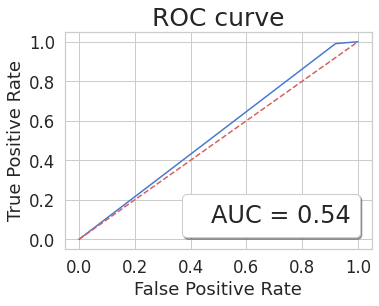

In [ ]:
print(type(y_predict))
print(type(y_predict[0]))
# print(type(y_predict[0][0]))
value_counts = pd.DataFrame(y_predict).value_counts()
print(value_counts)

plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

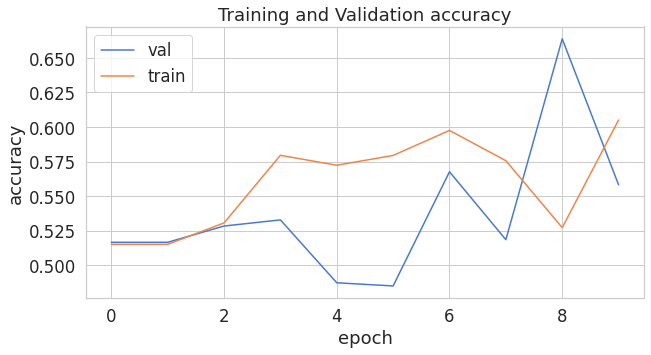

In [ ]:
epoch = [49, 99, 149, 199, 249, 
         299, 349, 399, 449, 499]
lr =  [0.001, 0.0005, 0.00025, 0.000125, 0.0001, 
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
train_acc =	 [0.5150307110796125, 0.5150307110796125, 0.5305339003071108, 0.5795092133238837, 
              0.572289156626506, 0.5794058587290338, 0.5975076777699031, 0.5755965036617057, 
              0.5271084337349398, 0.6050673281360737]

test_acc =	[0.5103132161955691, 0.5103132161955691, 0.5318424890617404, 0.5745537884575318, 
             0.5671921661226474, 0.5753177303979443, 0.5903187721369539, 0.5708035280227793, 
             0.5216334467671366, 0.6030974373220362]

loss = [0.6926925182342529, 0.6775632500648499, 0.5778528451919556, 0.5478848218917847, 
        0.48093122243881226, 0.6178834438323975, 0.5900947451591492, 0.6202903985977173, 
        0.45140522718429565, 0.5377845168113708]

plt.figure(figsize=(10,5))
plt.title("Training and Validation accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

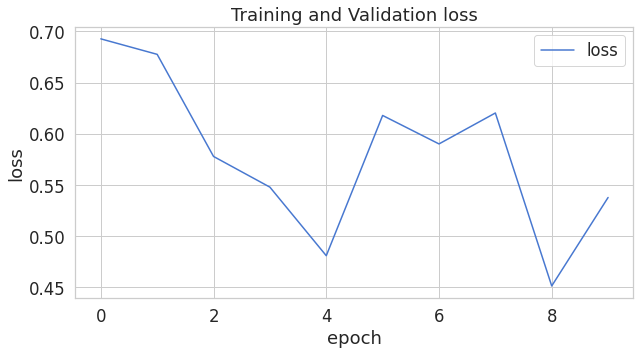

In [ ]:
# Loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation loss")
# plt.plot(val_acc,label="val")
plt.plot(loss,label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### **(Round2) 1_1_OS-CNN_easy_use_Run_and_Save_Model.ipynb**

In [ ]:
import os
from sklearn.metrics import accuracy_score
from os.path import dirname
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# from utils import save_model, save_plots, SaveBestModel

from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
class SaveBestModel:
      """
      Class to save the best model while training. If the current epoch's 
      validation loss is less than the previous least less, then save the
      model state.
      """
      def __init__(
          self, best_valid_loss=float('inf')
      ):
          self.best_valid_loss = best_valid_loss
          
      def __call__(
          self, current_valid_loss, 
          epoch, model, optimizer, criterion
      ):
          if current_valid_loss < self.best_valid_loss:
              self.best_valid_loss = current_valid_loss
              print(f"\nBest validation loss: {self.best_valid_loss}")
              print(f"\nSaving best model for epoch: {epoch+1}\n")
              torch.save({
                  'epoch': epoch+1,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': criterion,
                  }, 'outputs/best_model.pth')
          
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/ETH_Cryptocurrency/final_model.pth')

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/ETH_Cryptocurrency/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/ETH_Cryptocurrency/loss.png')


In [ ]:
class OS_CNN_easy_use():
    
    def __init__(self,Result_log_folder, 
                 dataset_name, 
                 device, 
                 start_kernel_size = 1,
                 Max_kernel_size = 89, 
                 paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128], 
                 max_epoch = 2000, 
                 batch_size=16,
                 print_result_every_x_epoch = 50,
                 lr = 0.001
                ):
        
        super(OS_CNN_easy_use, self).__init__()
        
        if not os.path.exists(Result_log_folder +dataset_name+'/'):
            os.makedirs(Result_log_folder +dataset_name+'/')
        Initial_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'initial_model'
        model_save_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'
        

        self.Result_log_folder = Result_log_folder
        self.dataset_name = dataset_name        
        self.model_save_path = model_save_path
        self.Initial_model_path = Initial_model_path
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        
        self.start_kernel_size = start_kernel_size
        self.Max_kernel_size = Max_kernel_size
        self.paramenter_number_of_layer_list = paramenter_number_of_layer_list
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.print_result_every_x_epoch = print_result_every_x_epoch
        self.lr = lr
        self.OS_CNN = None

    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # training
    # def train(model, trainloader, optimizer, criterion):
    #     model.train()
    #     print('Training')
    #     train_running_loss = 0.0
    #     train_running_correct = 0
    #     counter = 0
    #     for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    #         counter += 1
    #         image, labels = data
    #         image = image.to(device)
    #         labels = labels.to(device)
    #         optimizer.zero_grad()
            
    #         # forward pass
    #         # outputs = model(image)
    #         outputs = model(data[0])
    #         # calculate the loss
    #         loss = criterion(outputs, data[1])
    #         train_running_loss += loss.item()
    #         # calculate the accuracy
    #         _, preds = torch.max(outputs.data, 1)
    #         train_running_correct += (preds == data[1]).sum().item()
    #         # backpropagation
    #         loss.backward()
    #         # update the optimizer parameters
    #         optimizer.step()
        
    #     # loss and accuracy for the complete epoch
    #     epoch_loss = train_running_loss / counter
    #     epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    #     return epoch_loss, epoch_acc
    
    # # validation
    # def validate(model, testloader, criterion):
    #     model.eval()
    #     print('Validation')
    #     valid_running_loss = 0.0
    #     valid_running_correct = 0
    #     counter = 0
    #     with torch.no_grad():
    #         for i, data in tqdm(enumerate(testloader), total=len(testloader)):
    #             counter += 1
                
    #             # image, labels = data
    #             # image = image.to(device)
    #             # labels = labels.to(device)
    #             # forward pass
    #             # outputs = model(image)
    #             outputs = model(data[0])

    #             # calculate the loss
    #             loss = criterion(outputs, data[1])
    #             valid_running_loss += loss.item()
    #             # calculate the accuracy
    #             _, preds = torch.max(outputs.data, 1)
    #             valid_running_correct += (preds == data[1]).sum().item()
        
    #     # loss and accuracy for the complete epoch
    #     epoch_loss = valid_running_loss / counter
    #     epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    #     return epoch_loss, epoch_acc
    
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@        
        
    def fit(self, X_train, y_train, X_val, y_val):

        print('code is running on ',self.device)
        
        
        # covert numpy to pytorch tensor and put into gpu
        X_train = torch.from_numpy(X_train)
        X_train.requires_grad = False
        X_train = X_train.to(self.device)
        y_train = torch.from_numpy(y_train).to(self.device)
        
        
        X_test = torch.from_numpy(X_val)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)
        y_test = torch.from_numpy(y_val).to(self.device)
        
        
        # add channel dimension to time series data
        if len(X_train.shape) == 2:
            X_train = X_train.unsqueeze_(1)
            X_test = X_test.unsqueeze_(1)

        input_shape = X_train.shape[-1]
        n_class = max(y_train) + 1
        receptive_field_shape= min(int(X_train.shape[-1]/4),self.Max_kernel_size)
        
        # generate parameter list
        layer_parameter_list = generate_layer_parameter_list(self.start_kernel_size,
                                                             receptive_field_shape,
                                                             self.paramenter_number_of_layer_list,
                                                             in_channel = int(X_train.shape[1]))
        
        
        torch_OS_CNN = OS_CNN(layer_parameter_list, n_class.item(), False).to(self.device)
        
        # save_initial_weight
        torch.save(torch_OS_CNN.state_dict(), self.Initial_model_path)
        
        
        # loss, optimizer, scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(torch_OS_CNN.parameters(),lr= self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=0.0001)
        # initialize SaveBestModel class
        save_best_model = SaveBestModel()
        
        # build dataloader
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=True)
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_train.shape[0] / 10, self.batch_size)),2), shuffle=False)
        
        
        torch_OS_CNN.train()   

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # lists to keep track of losses and accuracies
        train_loss = [] 
        valid_loss = []
        train_acc = [] 
        valid_acc = []
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        
        for i in range(self.max_epoch):
            print(f'epoch No.', i)          

          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            # print(f"[INFO]: Epoch {i+1} of {i}")
            # train_epoch_loss, train_epoch_acc = train(torch_OS_CNN, train_loader, optimizer, criterion)
            # valid_epoch_loss, valid_epoch_acc = validate(torch_OS_CNN, test_loader, criterion)
            # train_loss.append(train_epoch_loss)
            # valid_loss.append(valid_epoch_loss)
            # train_acc.append(train_epoch_acc)
            # valid_acc.append(valid_epoch_acc)
            # print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
            # print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

            # # save the best model till now if we have the least loss in the current epoch
            # save_best_model(valid_epoch_loss, i, torch_OS_CNN, optimizer, criterion)

         # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
            train_running_loss = 0.0
            train_running_correct = 0
            counter = 0
            for sample in train_loader:
                counter += 1
                optimizer.zero_grad()
                y_predict = torch_OS_CNN(sample[0])
                output = criterion(y_predict, sample[1])

                train_running_loss += output.item()
                # calculate the accuracy
                _, preds = torch.max(y_predict, 1)
                train_running_correct += (preds == sample[1]).sum().item()

                output.backward()
                optimizer.step()

            scheduler.step(output)
            # loss and accuracy for the complete epoch
            train_epoch_loss = float(train_running_loss) / float(counter)
            train_epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
            train_loss.append(train_epoch_loss)
            train_acc.append(train_epoch_acc)
            print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            valid_running_loss = 0.0
            valid_running_correct = 0
            counters = 0
            for sample in test_loader:
                counters += 1
                optimizer.zero_grad()
                y_predict = torch_OS_CNN(sample[0])
                output = criterion(y_predict, sample[1])

                valid_running_loss += output.item()
                # calculate the accuracy
                _, preds = torch.max(y_predict, 1)
                valid_running_correct += (preds == sample[1]).sum().item()

                output.backward()
                optimizer.step()

            scheduler.step(output)
            # loss and accuracy for the complete epoch
            valid_epoch_loss = float(valid_running_loss) / float(counters)
            valid_epoch_acc = 100. * (valid_running_correct / len(test_loader.dataset))
            valid_loss.append(valid_epoch_loss)
            valid_acc.append(valid_epoch_acc)
            print(f"valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}")

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


            if eval_condition(i,self.print_result_every_x_epoch):
                for param_group in optimizer.param_groups:
                    print('epoch =',i, 'lr = ', param_group['lr'])
                torch_OS_CNN.eval()
                acc_train = eval_model(torch_OS_CNN, train_loader)
                acc_test = eval_model(torch_OS_CNN, test_loader)
                torch_OS_CNN.train()
                print('train_acc=\t', acc_train, '\t test_acc=\t', acc_test, '\t loss=\t', output.item())
                sentence = 'train_acc=\t'+str(acc_train)+ '\t test_acc=\t'+str(acc_test) 
                print('log saved at:')
                save_to_log(sentence,self.Result_log_folder, self.dataset_name)
                torch.save(torch_OS_CNN.state_dict(), self.model_save_path)

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

            # save the trained model weights for a final time
            save_model(i, torch_OS_CNN, optimizer, criterion)
            # save the loss and accuracy plots
            save_plots(train_acc, valid_acc, train_loss, valid_loss)
            print('TRAINING COMPLETE')

        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        torch.save(torch_OS_CNN.state_dict(), self.model_save_path)
        self.OS_CNN = torch_OS_CNN

        
        
    def predict(self, X_test):
        
        X_test = torch.from_numpy(X_test)
        X_test.requires_grad = False
        X_test = X_test.to(self.device)
        
        if len(X_test.shape) == 2:
            X_test = X_test.unsqueeze_(1)
        
        test_dataset = TensorDataset(X_test)
        test_loader = DataLoader(test_dataset, batch_size=max(int(min(X_test.shape[0] / 10, self.batch_size)),2), shuffle=False)
        
        self.OS_CNN.eval()
        
        predict_list = np.array([])
        for sample in test_loader:
            y_predict = self.OS_CNN(sample[0])
            y_predict = y_predict.detach().cpu().numpy()
            y_predict = np.argmax(y_predict, axis=1)
            predict_list = np.concatenate((predict_list, y_predict), axis=0)
            
        return predict_list


In [ ]:
# Result_log_folder = './Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Results_of_OS_CNN_for_multivariate\OS_CNN_result_iter_0
# dataset_path = dirname("./Example_Datasets/UEAArchive_2018/")                              # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Datasets\UEAArchive_2018

# Split_tain_test
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/60_min/'   
# Walk_forward No.1
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/60_min/'
# Walk_forward No.2
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/20_min/'   
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/60_min/'
# Walk_forward No.3
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/60_min/'

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_1min/")                              

dataset_name = [
"ETH_Cryptocurrency",
]

start = time.time()

# for dataset_name in dataset_name_list:
for dataset_name in dataset_name:
    print('running at:', dataset_name)   
    
    # load multivariate data
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader(dataset_path, dataset_name)    # Multivariate
    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
    # X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)                 # Univariate
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader_from_mat( dataset_path, dataset_name )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    
    print('train data type', type(X_train))
    print('train label type',type(y_train))
    print('train data type', type(X_train[0]))
    print('train label type',type(y_train[0]))
    print('train data type', type(X_train[0][0]))
    # print('train label type',type(y_train[0][0]))

    print('val data shape',X_val.shape)
    print('val label shape',y_val.shape)
    
    print('unique train label',np.unique(y_train))
    print('unique val label',np.unique(y_val))
        
    # creat model and log save place
    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder
        dataset_name = dataset_name,      # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu 
        # device = "cuda:0",                     # Tpu 
        max_epoch = 500,                       # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128]
        # paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128]    # Multivariate
        # paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],                    # Univariate
                            )
    
    # X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()

    model.fit(X_train, y_train, X_val, y_val)

    y_predict = model.predict(X_test)
    print('correct:',y_test)
    print('predict:',y_predict)
    
    acc = accuracy_score(y_test, y_predict)
    f1 =  f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict) 
    recall = recall_score(y_test, y_predict)
    class_report = classification_report(y_test, y_predict)
    confusion_metrix = confusion_matrix(y_test, y_predict)
    os_cnn_roc_auc = roc_auc_score(y_test, y_predict)
    
    print(dataset_name,'test acc = ', acc)
    print(dataset_name,'test f1-score = ', f1)
    print(dataset_name,'test precision-score = ', precision)
    print(dataset_name,'test recall-score = ', recall)
    print(dataset_name,'test classification report = ',class_report)
    print(dataset_name,'test confusion metric = ',confusion_metrix)
    print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

done = time.time()
print(f'Time : {done - start}')

Output hidden; open in https://colab.research.google.com to view.

<class 'numpy.ndarray'>
<class 'numpy.float64'>
1.0    12088
0.0      561
dtype: int64


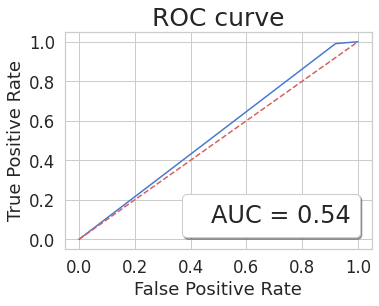

In [ ]:
print(type(y_predict))
print(type(y_predict[0]))
# print(type(y_predict[0][0]))
value_counts = pd.DataFrame(y_predict).value_counts()
print(value_counts)

plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

#### **1_2_OS-CNN_load_saved_model_for_prediction.ipynb**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

ModuleNotFoundError: ignored

In [ ]:
# model saved in result log folder
# Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
# dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/")                              

#batch_size for test
dataset_name = "ETH_Cryptocurrency"
batch_size = 16
print('test dataset:', dataset_name)

In [ ]:
# load data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
# X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

# X_train = X_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# X_test = X_test.astype(np.float32)

# # put data to GPU
# X_train = torch.from_numpy(X_train)
# X_train.requires_grad = False
# X_train = X_train.to(device)
# X_train = X_train.unsqueeze_(1)
# y_train = torch.from_numpy(y_train).to(device)

# X_test = torch.from_numpy(X_test)
# X_test.requires_grad = False
# X_test = X_test.to(device)
# X_test = X_test.unsqueeze_(1)
# y_test = torch.from_numpy(y_test).to(device)
# input_shape = X_train.shape[-1]
# n_class = max(y_train) + 1

# print('the size of inpute dataset is:',input_shape)
# print('number of class is:',n_class)
  
# #build dataloader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

# test_dataset = TensorDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

X_train_data = X_train.astype(np.float32)
X_val_data = X_val.astype(np.float32)
X_test_data = X_test.astype(np.float32)

# put data to GPU
X_train_data = torch.from_numpy(X_train_data)
X_train_data.requires_grad = False
X_train_data = X_train_data.to(device)
X_train_data = X_train_data.unsqueeze_(1)
y_train_data = torch.from_numpy(y_train).to(device)

X_val_data = torch.from_numpy(X_val_data)
X_val_data.requires_grad = False
X_val_data = X_val_data.to(device)
X_val_data = X_val_data.unsqueeze_(1)
y_val_data = torch.from_numpy(y_val).to(device)

X_test_data = torch.from_numpy(X_test_data)
X_test_data.requires_grad = False
X_test_data = X_test_data.to(device)
X_test_data = X_test_data.unsqueeze_(1)
y_test_data = torch.from_numpy(y_test).to(device)
input_shape = X_train_data.shape[-1]
n_class = max(y_train_data) + 1
# n_class =  max(y_train) - 1

print('the size of inpute dataset is:',input_shape)   # 30
print('number of class is:',n_class)    # 2
  
#build dataloader
train_dataset = TensorDataset(X_train_data, y_train_data)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=True)

val_dataset = TensorDataset(X_val_data, y_val_data)
val_loader = DataLoader(val_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=False)

test_dataset = TensorDataset(X_test_data, y_test_data)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train_data.shape[0] / 10, batch_size)), shuffle=False)

In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train_data.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train_data.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

In [ ]:
# find model path
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'
best_model_path = Result_log_folder +dataset_name+'/'+dataset_name+'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_val = eval_model(torch_FCN, val_loader)
acc_test = eval_model(torch_FCN, test_loader)

sentence_test = str(acc_test)
sentence_val = str(acc_val)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)
print(dataset_name,'validation acc = ', acc_val)

In [ ]:
# ==================== Predict ==================== 
# np.argmax() = ได้ตำแหน่งที่มีค่าสูงสุด
# .detach () = Returns a new Tensor, detached from the current graph. The result will never require gradient. This method also affects forward mode AD gradients and the result will never have forward mode AD gradients. 
# https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html
# np.concatenate = hstack จะเป็นการเอาอาเรย์มาต่อกัน เท่ากับ np.concatenate( (a, b),axis=0)

X_tests = torch.from_numpy(X_test)
X_tests.requires_grad = False
X_tests = X_tests.to(device)

if len(X_tests.shape) == 2:
    X_tests = X_tests.unsqueeze_(1)

test_datasets = TensorDataset(X_tests)
test_loaders = DataLoader(test_datasets, batch_size=max(int(min(X_tests.shape[0] / 10, batch_size)),2), shuffle=False)

# OS_CNN.eval()
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

predict_lists = np.array([])

for sample in test_loader:
    y_predicts = torch_FCN(sample[0]).to(device)
    y_predicts = y_predicts.detach().cpu().numpy()
    y_predicts = np.argmax(y_predicts, axis=1)
    predict_lists = np.concatenate((predict_lists, y_predicts), axis=0)

print(predict_lists)
# y_predict = predict(X_test)

In [ ]:
# # ==================== Predict ==================== 
# import torch.nn.functional as F

# X_tests = torch.from_numpy(X_test)
# X_tests.requires_grad = False
# X_tests = X_tests.to(device)

# if len(X_tests.shape) == 2:
#     X_tests = X_tests.unsqueeze_(1)

# test_datasets = TensorDataset(X_tests)
# test_loaders = DataLoader(test_datasets, batch_size=max(int(min(X_tests.shape[0] / 10, batch_size)),2), shuffle=False)

# # OS_CNN.eval()
# torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
# torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
# torch_FCN.eval()

# predict_lists = np.array([])
# # ============================================
# # y_pred_prob_list = np.array([])
# y_pred_prob_list = []
# labels = []
# # ============================================

# for sample in test_loader:
#     y_predicts = torch_FCN(sample[0]).to(device)
#     # print('y_predicts 1 :', y_predicts)
#     # print('type y_predicts 1 :', type(y_predicts)) # <class 'torch.Tensor'>

#     # ============================================
#     y_pred_prob = torch.sigmoid(y_predicts)
#     # y_pred_prob = F.softmax(y_predicts, dim=0)
#     # print('type y_predicts prob 1 :', type(y_pred_prob)) # <class 'torch.Tensor'>
#     y_pred_prob = y_pred_prob.detach().cpu().numpy()
#     # print('type y_predicts prob 2 :', type(y_pred_prob)) # <class 'numpy.ndarray'>
#     y_pred_prob_list.append(y_pred_prob)

#     # ============================================

#     y_predicts = y_predicts.detach().cpu().numpy()
#     # print('y_predicts 2 :', y_predicts)    
#     # print('type y_predicts 2 :', type(y_predicts)) # <class 'numpy.ndarray'>

#     y_predicts = np.argmax(y_predicts, axis=1)
#     # print('y_predicts 3 :', y_predicts)
#     # print('type y_predicts 3 :', type(y_predicts)) # <class 'numpy.ndarray'>

#     predict_lists = np.concatenate((predict_lists, y_predicts), axis=0)
#     # print('y_predicts list 4 :', predict_lists)
#     # print('y_predicts list 4 :', len(predict_lists))
#     # print('type y_predicts list 4 :', type(predict_lists)) # <class 'numpy.ndarray'>

#     # y_pred_prob_list = np.concatenate((y_pred_prob_list, y_pred_prob) .detach().cpu().numpy())

#     # y_testdata = torch_FCN(sample[1]).to(device)
#     # y_testdata.cpu().numpy())
#     # labels = concatenate((labels, y_testdata), axis=0)
#     # y_pred_prob = torch.sigmoid(y_predicts)
#     # y_pred_prob_list.append(y_pred_prob)
#     # labels.append(sample[1].to(device).detach().cpu().numpy())

# # print(predict_lists)


In [ ]:
print(predict_lists)
print(f'len(predict_lists) : {len(predict_lists)}')
# print(f'len(predict_lists[0]) : {len(predict_lists[0])}')
# print(f'len(predict_lists[0][0]) : {len(predict_lists[0][0])}')
# print(f'len(predict_lists[0][0][0]) : {len(predict_lists[0][0][0])}')
# print(f'len(predict_lists[0][0][0][0]) : {len(predict_lists[0][0][0][0])}')

print(f'type(predict_lists[0]) : {type(predict_lists[0])}')
# print(f'type(predict_lists[0][0]) : {type(predict_lists[0][0])}')
# print(f'type(predict_lists[0][0][0]) : {type(predict_lists[0][0][0])}')
# print(f'type(predict_lists[0][0][0][0]) : {type(predict_lists[0][0][0][0])}')

value_counts = pd.DataFrame(predict_lists).value_counts()
print(value_counts)

print(f'predict_lists[:1500] : {predict_lists[:1500]}')
print(f'predict_lists[11246:] : {predict_lists[11246:]}')

# =============================================================================
# y_pred_prob_list = []
# labels = []

# print(f'y_pred_prob_lists[:100] : {y_pred_prob_list[:5]}')
# print(f'count labels : {len(labels)}')
print(f'y_test : {y_test}')
print(f'count y_test :{len(y_test)}')

In [ ]:
class_report = classification_report(y_test, predict_lists)
accuracy = accuracy_score(y_test, predict_lists)
f1_test = f1_score(y_test, predict_lists)
precision = precision_score(y_test, predict_lists) 
recall = recall_score(y_test, predict_lists)
confusion_metrix = confusion_matrix(y_test, predict_lists)
os_cnn_roc_auc = roc_auc_score(y_test, predict_lists)

print(class_report)
print(dataset_name,'test accuracy = ', accuracy)
print(dataset_name,'test f1-score = ', f1_test)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test confusion metric = ')
print(confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

In [ ]:
plt.figure(figsize = (5.5, 4))

fpr, tpr, _ = roc_curve(y_test, predict_lists)
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob_list)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
plt.show()

In [ ]:
y_pred_prob_list = []
y_pred_list = []
y_test_batch_list = []

# Loading the best model
# model.load_state_dict(torch.load('./state_dict.pt'))
# model = torch.load(best_model_path)
# model = Model()
# model.load_state_dict(torch.load(best_model_path))

# with torch.no_grad():
#       torch_FCN.eval()
#       for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
#           print(batch_idx)
#           X_test_batch = X_test_batch.to(device)
#           print(f'X_test_batch : {X_test_batch}')
#           y_test_batch = y_test_batch.to(device)
#           # print(X_test_batch)
#           print(f'y_test_batch : {y_test_batch}')

#           #PREDICTION
#           # output = model(X_test_batch)
#           output = torch_FCN(X_test_batch)
#           predict = torch.max(output, 1)
#           print(f'output : {predict}')
          
#           y_pred_prob = torch.sigmoid(output)
#           print(f'y_pred_prob : {y_pred_prob}')
#           y_pred_prob_list.append(y_pred_prob.cpu().numpy())

#           y_pred = torch.round(y_pred_prob)
#           print(f'y_pred : {y_pred}')
#           y_pred_list.append(y_pred.cpu().numpy())

#           # y_test_batch = round(y_test_batch)
#           y_test_batch_list.append(y_test_batch.cpu().numpy())


# with torch.no_grad():
#       torch_FCN.eval()
#       for batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader):
#           print(batch_idx)
#           X_test_batch = X_test_batch.to(device)
#           print(f'X_test_batch : {X_test_batch}')

#           y_test_batch = y_test_batch.to(device)
#           print(f'y_test_batch : {y_test_batch}')

#           #PREDICTION
#           # output = model(X_test_batch)
#           output = torch_FCN(X_test_batch)
#           predict = torch.max(output, 1)
#           print(f'output : {predict}')
          
#           y_pred_prob = torch.sigmoid(output)
#           print(f'y_pred_prob : {y_pred_prob}')
#           y_pred_prob_list.append(y_pred_prob.cpu().numpy())

#           y_pred = torch.round(y_pred_prob)
#           print(f'y_pred : {y_pred}')
#           y_pred_list.append(y_pred.cpu().numpy())

#           # y_test_batch = round(y_test_batch)
#           y_test_batch_list.append(y_test_batch.cpu().numpy())



In [ ]:
# def evaluate(model, test_dataloader, device="cuda"):
#     model.eval()

#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []
    
#     with torch.no_grad():
#         for batch in test_dataloader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)

#             y_predict.append(yhat.cpu().numpy())
#             y_pred_prob = torch.sigmoid(yhat)
#             y_pred = torch.round(y_pred_prob)

#             # predictions.append(yhat_idx.cpu().numpy())
#             labels.append(y_batch.cpu().numpy())           # y_true

#             y_pred_prob_list.append(y_pred_prob)
#             prediction_list.append(y_pred)

#     return predictions, labels,  # Return the model predictions

In [ ]:
# #==================================================================================================
# model = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)

# model_debug = True
# if model_debug:
#     # Evaluate the model
#     # predictions, labels, y_predict, y_pred_prob_list, prediction_list = evaluate(model, test_loader, device=device)

#     model.eval()
#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []    
    
#     with torch.no_grad():
#         for batch in test_loader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)
 
#             labels.append(y_batch.cpu().numpy()) # y_true

#             # ================ prob & predict =================

#             y_pred_prob = torch.sigmoid(yhat)    # prob by sigmoid value 0 to 1
#             y_pred = torch.round(y_pred_prob)    # predict prob >= 0.5 = 1 , prob < 0.5 = 0  

#             y_pred_prob_list.append(y_pred_prob)
#             # prediction_list.append(y_pred)
#             #===================================================
#             # y_prediction = predict(x_batch)
#             # prediction_list.append(y_pred)


#     y_true = np.concatenate(labels, axis=0)
#     print(f'y_true : {y_true}')
#     # y_pred = np.concatenate(predictions, axis=0)
#     # y_predict = np.concatenate(predictions)
#     # print(f'y_pred : {y_predict}')

#     # y_pred = np.concatenate(prediction_list, axis=0)
#     print(prediction_list)
#     # y_pred = np.concatenate(prediction_list)
#     # print(f'y_pred : {y_pred}')

#     acc = accuracy_score(y_true, y_pred)
#     f1_test = f1_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred) 
#     recall = recall_score(y_true, y_pred)
#     class_report = classification_report(y_true, y_pred)
#     confusion_metrix = confusion_matrix(y_true, y_pred)
#     os_cnn_roc_auc = roc_auc_score(y_true, y_pred)

#     print(dataset_name,'test accuracy = ', acc)
#     print(dataset_name,'test f1-score = ', f1_test)
#     print(dataset_name,'test precision = ', precision)
#     print(dataset_name,'test recall = ', recall)
#     print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)
#     print('confusion metric = ', confusion_metrix)
#     print(class_report)

# else:
#     # Final Predictions
#     # predictions, labels = evaluate(model, final_loader, device=device)
#     model.eval()

#     predictions = []
#     labels = []
#     y_predict = []

#     y_pred_prob_list = []
#     prediction_list = []    
    
#     with torch.no_grad():
#         for batch in test_loader:
            
#             x_batch, y_batch = batch
            
#             # Move to device
#             x_batch, y_batch = x_batch.float().to(device), y_batch.type(torch.LongTensor).to(device)
#             yhat = model(x_batch) # No unpacking occurs in CNNs
            
#             # Calculate the index of the maximum argument
#             # yhat_idx = torch.argmax(yhat, dim=1)

#             y_predict.append(yhat.cpu().np())
#             y_pred_prob = torch.sigmoid(yhat)
#             y_pred = torch.round(y_pred_prob)

#             # predictions.append(yhat_idx.cpu().numpy())
#             labels.append(y_batch.cpu().numpy())           # y_true

#             y_pred_prob_list.append(y_pred_prob)
#             prediction_list.append(y_pred)

#     y_pred = np.concatenate(predictions, axis=0)
#     x_idx = np.arange(X_final_test.shape[0])+1
    
#     final_df = pd.DataFrame({'ImageId':x_idx, 'Label':y_pred})
#     final_df.to_csv('submission.csv', index=False)
#     print('Submission file is ready.')

#### **1_2_OS-CNN_load_saved_model_for_prediction.ipynb**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
# model saved in result log folder
# Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
# dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")

# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   
# dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/UEAArchive_2018/")                              

# dataset_name = "Cryptocurrency"

#batch_size for test
dataset_name = "ETH_Cryptocurrency"
batch_size = 16
print('test dataset:', dataset_name)

test dataset: ETH_Cryptocurrency


In [ ]:
# load data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
# X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# put data to GPU
X_train = torch.from_numpy(X_train)
X_train.requires_grad = False
X_train = X_train.to(device)
X_train = X_train.unsqueeze_(1)
y_train = torch.from_numpy(y_train).to(device)

X_test = torch.from_numpy(X_test)
X_test.requires_grad = False
X_test = X_test.to(device)
X_test = X_test.unsqueeze_(1)
y_test = torch.from_numpy(y_test).to(device)
input_shape = X_train.shape[-1]
n_class = max(y_train) + 1
print('the size of inpute dataset is:',input_shape)
print('number of class is:',n_class)
  
#build dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

code is running on:  cuda:0
the size of inpute dataset is: 30
number of class is: tensor(3, device='cuda:0')


In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

the shape of inpute data is: torch.Size([59623, 1, 30])
the max size of kernel is: 7
the Network structure for ETH_Cryptocurrency is:
[[(1, 56, 1), (1, 56, 2), (1, 56, 3), (1, 56, 5), (1, 56, 7)], [(280, 45, 1), (280, 45, 2), (280, 45, 3), (280, 45, 5), (280, 45, 7)], [(225, 280, 1), (225, 280, 2)]]


In [ ]:
# find model path
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_0/Walk_forward No.2/ETH/30_min/'

best_model_path = Result_log_folder + dataset_name + '/' + dataset_name + 'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_test = eval_model(torch_FCN, test_loader)
f1_test = f1_score(torch_FCN, test_loader)
precision = precision_score(test_loader, torch_FCN) 
recall = recall_score(test_loader, torch_FCN)
class_report = classification_report(test_loader, torch_FCN)
confusion_metrix = confusion_matrix(test_loader, torch_FCN)
os_cnn_roc_auc = roc_auc_score(test_loader, torch_FCN)

sentence = str(acc_test)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)
print(dataset_name,'test f1-score = ', f1_test)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test classification report = ',class_report)
print(dataset_name,'test confusion metric = ',confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

fpr_os_cnn, tpr_os_cnn, thresholds_os_cnn = roc_curve(test_loader, model.predict_proba(torch_FCN)[:,1])

plt.figure()
plt.plot(fpr_os_cnn, tpr_os_cnn, label='OS_CNN(area = %0.5f)' % os_cnn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ETH_Cryptocurrency test acc =  0.7114396394971935


### **Walk forward no.3** 

In [ ]:
import os
from os.path import dirname
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader
# from utils.dataloader.TSC_data_loader import TSC_data_loader                         # .tsv
# from utils.dataloader.TSC_data_loader import TSC_multivariate_data_loader_from_mat   # .mat
from Classifiers.OS_CNN.OS_CNN_easy_use import OS_CNN_easy_use
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

#### **1_1_OS-CNN_easy_use_Run_and_Save_Model.ipynb**

In [ ]:
# Result_log_folder = './Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Results_of_OS_CNN_for_multivariate\OS_CNN_result_iter_0
# dataset_path = dirname("./Example_Datasets/UEAArchive_2018/")                              # C:\Semester 4\BADS9000 IS\OS-CNN-master\Example_Datasets\UEAArchive_2018

# Split_tain_test
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Split_train_test/ETH/60_min/'   
# Walk_forward No.1
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.1/ETH/60_min/'
# Walk_forward No.2
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/20_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/30_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.2/ETH/60_min/'
# Walk_forward No.3
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/5_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/10_min/'   
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/20_min/'   
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'
# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/60_min/'

dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/ETH_1min/")                              

dataset_name = [
"ETH_Cryptocurrency",
]

start = time.time()

# for dataset_name in dataset_name_list:
for dataset_name in dataset_name:
    print('running at:', dataset_name)   
    
    # load multivariate data
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader(dataset_path, dataset_name)    # Multivariate
    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
    # X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)                 # Univariate
    # X_train, y_train, X_test, y_test = TSC_multivariate_data_loader_from_mat( dataset_path, dataset_name )

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print('train data shape', X_train.shape)
    print('train label shape',y_train.shape)
    
    print('train data type', type(X_train))
    print('train label type',type(y_train))
    print('train data type', type(X_train[0]))
    print('train label type',type(y_train[0]))
    print('train data type', type(X_train[0][0]))
    # print('train label type',type(y_train[0][0]))

    print('val data shape',X_val.shape)
    print('val label shape',y_val.shape)
    
    print('unique train label',np.unique(y_train))
    print('unique val label',np.unique(y_val))
        
    # creat model and log save place
    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder
        dataset_name = dataset_name,      # dataset_name for creat log under Result_log_folder
        device = "cuda:0",                     # Gpu 
        # device = "cuda:0",                     # Tpu 
        max_epoch = 500,                       # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128]
        # paramenter_number_of_layer_list = [8*128*X_train.shape[1], 5*128*256 + 2*256*128]    # Multivariate
        # paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],                    # Univariate
                            )
    
    # X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # X_train, y_train, X_test, y_test = X_train.cuda(), y_train.cuda(), X_test.cuda(), y_test.cuda()

    model.fit(X_train, y_train, X_val, y_val)

    y_predict = model.predict(X_test)
    print('correct:',y_test)
    print('predict:',y_predict)
    
    acc = accuracy_score(y_test, y_predict)
    f1 =  f1_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict) 
    recall = recall_score(y_test, y_predict)
    class_report = classification_report(y_test, y_predict)
    confusion_metrix = confusion_matrix(y_test, y_predict)
    os_cnn_roc_auc = roc_auc_score(y_test, y_predict)
    
    print(dataset_name,'test acc = ', acc)
    print(dataset_name,'test f1-score = ', f1)
    print(dataset_name,'test precision-score = ', precision)
    print(dataset_name,'test recall-score = ', recall)
    print(dataset_name,'test classification report = ',class_report)
    print(dataset_name,'test confusion metric = ',confusion_metrix)
    print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

done = time.time()
print(f'Time : {done - start}')

running at: ETH_Cryptocurrency
train data shape (59623, 30)
train label shape (59623,)
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.ndarray'>
train data type <class 'numpy.ndarray'>
train label type <class 'numpy.int64'>
train data type <class 'numpy.float32'>
val data shape (12659, 30)
val label shape (12659,)
unique train label [1 2]
unique val label [1 2]
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5071197356724754 	 test_acc=	 0.5051741843747531 	 loss=	 0.6721481680870056
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_0/Walk_forward No.2/ETH/30_min/ETH_Cryptocurrency/ETH_Cryptocurrency_.txt
epoch = 99 lr =  0.0005
train_acc=	 0.49799573989903223 	 test_acc=	 0.49877557468994393 	 loss=	 0.7131088376045227
log saved at:
/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results

#### **1_2_OS-CNN_load_saved_model_for_prediction.ipynb**

In [ ]:
import os
from os.path import dirname
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from utils.dataloader.TSC_data_loader import TSC_data_loader
from Classifiers.OS_CNN.OS_CNN_Structure_build import generate_layer_parameter_list
from Classifiers.OS_CNN.log_manager import eval_condition, eval_model, save_to_log
from Classifiers.OS_CNN.OS_CNN import OS_CNN

In [ ]:
# model saved in result log folder
# Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'
# dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")

# Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_multivariate/OS_CNN_result_iter_0/'   
# dataset_path = dirname("./content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Datasets/UEAArchive_2018/")                              

# dataset_name = "Cryptocurrency"

#batch_size for test
dataset_name = "ETH_Cryptocurrency"
batch_size = 16
print('test dataset:', dataset_name)

test dataset: ETH_Cryptocurrency


In [ ]:
# load data
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0 )
# X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('code is running on: ',device)    

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# put data to GPU
X_train = torch.from_numpy(X_train)
X_train.requires_grad = False
X_train = X_train.to(device)
X_train = X_train.unsqueeze_(1)
y_train = torch.from_numpy(y_train).to(device)

X_test = torch.from_numpy(X_test)
X_test.requires_grad = False
X_test = X_test.to(device)
X_test = X_test.unsqueeze_(1)
y_test = torch.from_numpy(y_test).to(device)
input_shape = X_train.shape[-1]
n_class = max(y_train) + 1
print('the size of inpute dataset is:',input_shape)
print('number of class is:',n_class)
  
#build dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=int(min(X_train.shape[0] / 10, batch_size)), shuffle=False)

code is running on:  cuda:0
the size of inpute dataset is: 30
number of class is: tensor(3, device='cuda:0')


In [ ]:
#net parameter
paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128] 
Max_kernel_size = 89

# calcualte network structure
receptive_field_shape= min(int(X_train.shape[-1]/4),Max_kernel_size)
print('the shape of inpute data is:',X_train.shape)
print('the max size of kernel is:', receptive_field_shape)
layer_parameter_list = generate_layer_parameter_list(1,receptive_field_shape,paramenter_number_of_layer_list)
print('the Network structure for',dataset_name,'is:')
print(layer_parameter_list)

the shape of inpute data is: torch.Size([59623, 1, 30])
the max size of kernel is: 7
the Network structure for ETH_Cryptocurrency is:
[[(1, 56, 1), (1, 56, 2), (1, 56, 3), (1, 56, 5), (1, 56, 7)], [(280, 45, 1), (280, 45, 2), (280, 45, 3), (280, 45, 5), (280, 45, 7)], [(225, 280, 1), (225, 280, 2)]]


In [ ]:
# find model path
Result_log_folder = '/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS9000 IS/Colab_TSC_Cryptocurrency/Example_Results_of_OS_CNN_for_univariate/OS_CNN_result_iter_1/Walk_forward No.3/ETH/30_min/'
best_model_path = Result_log_folder + dataset_name + '/' + dataset_name + 'Best_model'

# build os-cnn net and load weight
torch_FCN = OS_CNN(layer_parameter_list, n_class.item(), False).to(device)
torch_FCN.load_state_dict(torch.load(best_model_path, map_location=device))
torch_FCN.eval()

acc_test = eval_model(torch_FCN, test_loader)
f1_test = f1_score(torch_FCN, test_loader)
precision = precision_score(test_loader, torch_FCN) 
recall = recall_score(test_loader, torch_FCN)
class_report = classification_report(test_loader, torch_FCN)
confusion_metrix = confusion_matrix(test_loader, torch_FCN)
os_cnn_roc_auc = roc_auc_score(test_loader, torch_FCN)

sentence = str(acc_test)
torch.cuda.empty_cache()
print(dataset_name,'test acc = ', acc_test)
print(dataset_name,'test f1-score = ', f1_test)
print(dataset_name,'test precision-score = ', precision)
print(dataset_name,'test recall-score = ', recall)
print(dataset_name,'test classification report = ',class_report)
print(dataset_name,'test confusion metric = ',confusion_metrix)
print(dataset_name,'test roc_auc = ',os_cnn_roc_auc)

fpr_os_cnn, tpr_os_cnn, thresholds_os_cnn = roc_curve(test_loader, model.predict_proba(torch_FCN)[:,1])

plt.figure()
plt.plot(fpr_os_cnn, tpr_os_cnn, label='OS_CNN(area = %0.5f)' % os_cnn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ETH_Cryptocurrency test acc =  0.7114396394971935


https://github.com/dl4sits/BreizhCrops/blob/master/breizhcrops/models/OmniScaleCNN.py  
https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/nbs/109_models.OmniScaleCNN.ipynb#scrollTo=d2ghCeoyCy-f  


https://openreview.net/pdf?id=PDYs7Z2XFGv  
https://openreview.net/forum?id=PDYs7Z2XFGv

# Code_example_of_theoretical_proof => Compare Other model

https://github.com/Wensi-Tang/OS-CNN/blob/master/3_1_compare_result.ipynb

https://github.com/Wensi-Tang/OS-CNN/tree/master/Code_example_of_theoretical_proof
  
- 1_1_Deep_Learning_Convolution_and_Convolution_theorem.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/1_1_Deep_Learning_Convolution_and_Convolution_theorem.ipynb

https://www.kaggle.com/code/hirotaka0122/time-series-classification-using-cnn/notebook#TIme-Series-Classification-Task
  
1D-CNN : 
https://towardsdatascience.com/hands-on-climate-time-series-classification-with-deep-learning-using-python-6d5de81004c9

- 2_1_Time_and_Space_Complexity_of_OS-CNN_Vs_FCN_ResNet.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/2_1_Time_and_Space_Complexity_of_OS-CNN_Vs_FCN_ResNet.ipynb
  
- 3_1_Positional_information_loss_of_FCN_and_how_OS-CNN_overcome_this.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/3_1_Positional_information_loss_of_FCN_and_how_OS-CNN_overcome_this.ipynb
  
- 3_2_FCN_with_different_kernel_size.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/3_2_FCN_with_different_kernel_size.ipynb
  
- 3_3_verification%20_of_Pytorch_FCN_%26_ResNet_implementation.ipynb
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/3_3_verification%20_of_Pytorch_FCN_%26_ResNet_implementation.ipynb

- 4_1_OS-CNN_load_saved_model_and_visualization_weight.ipynb
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/4_1_OS-CNN_load_saved_model_and_visualization_weight.ipynb

- 4_2_Frequency_Resolution.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/4_2_Frequency_Resolution.ipynb

- 4_3_Check_No_representation_ability_lose.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/4_3_Check_No_representation_ability_lose.ipynb

- 4_4_calculate_prime_model_size.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/4_4_calculate_prime_model_size.ipynb

- 4_5_Enough_channel.ipynb  
https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/4_5_Enough_channel.ipynb



ตัวอย่าง งาน time series

- สรุป time series อันนี้ดีของ medium
https://nutdnuy.medium.com/%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%A7%E0%B8%B4%E0%B9%80%E0%B8%84%E0%B8%A3%E0%B8%B2%E0%B8%B0%E0%B8%AB%E0%B9%8C%E0%B8%82%E0%B9%89%E0%B8%AD%E0%B8%A1%E0%B8%B9%E0%B8%A5%E0%B8%AD%E0%B8%99%E0%B8%B8%E0%B8%81%E0%B8%A3%E0%B8%A1%E0%B9%80%E0%B8%A7%E0%B8%A5%E0%B8%B2%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2-python-c30aaa4ee6ee

- อันนี้บอกว่า LSTM require 3 Dimension  
https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

https://colab.research.google.com/drive/1wWvtA5RC6-is6J8W86wzK52Knr3N1Xbm

https://medium.com/@ivanpetrovic_94238/recurrent-neural-networks-on-cryptocurrency-chainlink-price-prediction-with-tensorflow-2-a0192908984a

https://hackernoon.com/dont-be-fooled-deceptive-cryptocurrency-price-predictions-using-deep-learning-bf27e4837151

https://www.pytorials.com/predict-cryptocurrency-price-using-lstm/

- Predicting Cryptocurrency Price With Tensorflow and Keras ใช้ 1D-CNN และ model อื่นๆ  
https://medium.com/@huangkh19951228/predicting-cryptocurrency-price-with-tensorflow-and-keras-e1674b0dc58a

- อันนี้ทำ EDA ดี  
https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html

- https://github.com/orgs/QuantLet/repositories?q=crypto&type=all&language=&sort=

- https://github.com/QuantLet/CRIXdeeplearning/tree/master/ethtuning

- https://github.com/salvatorecorvaglia/Estimation-Data-Analysis-with-Applications/blob/master/Project/Bitcoin%20Price%20Prediction%20using%20LSTM%20and%20ARIMA%20with%20Quandl%20API.ipynb

- https://github.com/search?q=cryptocurrency+predict&type=Repositories

- https://github.com/JerryWei03/DeepCryptocurrency

- ARMA CryptoCurrency  
 https://www.kaggle.com/code/dantimbrell/arma-cryptocurrency#Ups-and-Downs

- https://github.com/khuangaf/CryptocurrencyPrediction

- https://github.com/abhinavsagar/cryptocurrency-price-prediction

- https://github.com/emirhanai/Cryptocurrency-Prediction-with-Artificial-Intelligence

- https://github.com/manthanthakker/BitcoinPrediction

- https://github.com/SiaFahim/lstm-crypto-predictor

- https://github.com/joe-wojniak/PythonForFinance

- https://medium.com/analytics-vidhya/time-series-analysis-of-cryptocurrencies-using-deep-learning-fbprophet-48abdb2e7ebf9

- time series analysis  
https://towardsdatascience.com/time-series-analysis-7138ec68754a

- https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook

other  
- https://github.com/kadambini-indurkar/CryptocurrencyPrediction/blob/master/predict.py  
- https://github.com/Harshit2019/CRYPTOCURRENCY-PRICE-PREDICTION-/blob/main/project/final_project.ipynb  
- https://github.com/Ashishkutchi/capstone-w2020-t2-g03-Time-Series-Forecasting-of-Bitcoin-Price/blob/master/Bitcoin_Prediction_RNN_LSTM.ipynb  
- https://github.com/sachinbhalekar/COMP541-CryptoCurrencyPrediction/blob/master/NeuralNetworkContinuous.ipynb

## **1. Deep_Learning_Convolution_and_Convolution_theorem**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# buidng two singal
input_signal_length = 6
kernel_filter_length =4

#generate signal x
X = np.random.rand(input_signal_length)

#generate weight in a filter of 1D CNN
w = np.random.rand(kernel_filter_length)

print("the singal X:\n\n",X, end="\n\n")
print("the kernal W:\n\n", w, end="\n\n")

# expend dimention of signal to fit requirement of CNN
X_torch = torch.from_numpy(X).unsqueeze(0).unsqueeze(0)

# expend dimention of filter to fit requirement of CNN
w_torch = torch.from_numpy(w).unsqueeze(0).unsqueeze(0)

In [ ]:
# the conventional reslut of deep learning
m = nn.ConstantPad1d(kernel_filter_length-1, 0)
deeplearning_conv_result = F.conv1d(m(X_torch) ,w_torch)
print('result of 1D convolution in deep learning: \n\n x*w = \n\n',deeplearning_conv_result.numpy(),'\n')

In [ ]:
###########
#  this is important:
#  conventional in signal processing for x and y_reverse(y') equals to y
###########
w_reverse = np.flip(w,axis=0)
print('kernel in signal processing w\':\n\n',w_reverse, end="\n\n")

# the conventional reslut of signal processing
signal_processing_result = np.convolve(X, w_reverse, mode='full')
print('result of 1D convolution in signal processing: \n\n x(*)w\'= \n\n',signal_processing_result)
print('\n\nthe result is same with the x*w = \n\n', deeplearning_conv_result.numpy())

In [ ]:
print("the singal X:\n\n",X, end="\n\n")

X_pad = np.pad(X, (0,len(w_reverse)-1), 'constant', constant_values=(0, 0))

print("the singal X_pad:\n\n",X_pad, end="\n\n")

print("the kernal W:\n\n", w, end="\n\n")
w_reverse_pad = np.pad(w_reverse, (0,len(X)-1), 'constant', constant_values=(0, 0))

print("the kernal W\'_pad:\n\n", w_reverse_pad, end="\n\n")

In [ ]:
X_pad_fft = np.fft.fft(X_pad)
w_reverse_pad_fft = np.fft.fft(w_reverse_pad)
print("singal in frequency domain: \n\n fft(x_pad) = \n\n",X_pad_fft, end="\n\n")
print("kernel in frequency domain: \n\n fft(w\'_pad) = \n\n",w_reverse_pad_fft, end="\n\n")

result = np.multiply(X_pad_fft,w_reverse_pad_fft)
print("conv result in frequency domain: \n\n fft(x_pad).fft(w'_pad) = \n\n",result, end="\n\n")

print("reconstruct result from frequency domain result: \n\n ifft(fft(x_pad).fft(w'_pad) )= \n\n",np.fft.ifft(result), end="\n\n")
print('\n\nthe result is same with the \n\n x*w = \n\n', deeplearning_conv_result.numpy())

In [ ]:
# varification of singal processing conv equation

def maumal_conv(x,y,n):
    N = len(x)
    M = len(y)
    result = 0
    for m in range(M):
        if n-M+1+m <N and n-M+1+m>= 0:
            temp = x[n-M+1+m]
        else:
            temp = 0.0
        result = result+ temp*y[M-1-m]
    return result

signal_processing_result = np.convolve(X, w_reverse, mode='full')

print("correct result:\n\n",signal_processing_result,end='\n\n')

print("result calculated by the equation in the paper:\n\n")
for i in range(input_signal_length+kernel_filter_length-1):
    print(maumal_conv(X,w_reverse,i),end='\t')

## **2. Time_and_Space_Complexity_of_OS-CNN_Vs_FCN_ResNet.ipynb**  
- https://github.com/Wensi-Tang/OS-CNN/blob/master/Classifiers/ResNet.py

- https://github.com/Wensi-Tang/OS-CNN/blob/master/Code_example_of_theoretical_proof/2_1_Time_and_Space_Complexity_of_OS-CNN_Vs_FCN_ResNet.ipynb

## **Compare_result**  
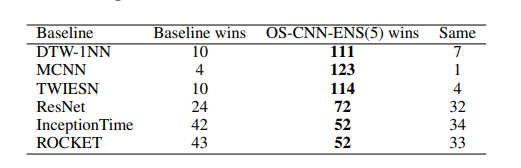

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import rankdata

def string2pair(information):
    if type(information) == np.float64:
        mean = information
        std = 0
    else:
        information = information.strip()
        information = information.strip(')')
        result = information.split('(')
        mean = float(result[0])
        std = float(result[1])
    return (mean,std)


# deep learning classifier:
#'MLP','FCN','ResNet','Encoder','MCNN','t-LeNet','MCDCNN','Time-CNN','TWIESN','InceptionTime','OS-CNN'
#'OS-CNN-ENS(2)','OS-CNN-ENS(3)','OS-CNN-ENS(4)',...,'OS-CNN-ENS(10)',

# traditional classifier:
#'1-NN DTW','1-NN DTW CV','TSBF','LS','EE(PROP)','BOSS','ST','WEASEL','HIVE-COTE','COTE','PF'


# full
get_result_list = ['Encoder','FCN','ResNet','MLP','MCNN','t-LeNet','MCDCNN',
                    'Time-CNN','TWIESN','1-NN DTW CV','1-NN DTW',
                    'LS','TSBF','EE(PROP)','PF','ST','BOSS','WEASEL','Flat-COTE','HIVE-COTE','InceptionTime','Inception',
                   'OS-CNN','OS-CNN-ENS(5)','OS-CNN-ENS(8)']

get_result_list = ['FCN','ResNet','1-NN DTW CV','1-NN DTW','BOSS','WEASEL','Flat-COTE','HIVE-COTE','InceptionTime','Inception',
                   'OS-CNN','OS-CNN-ENS(5)','OS-CNN-ENS(8)']

# ablation study of general solution
# get_result_list = ['FCN(16)','FCN(50)','FCN(100)','FCN(150)','FCN(200)','OS-CNN']

#SOTA
#get_result_list = ['ST','ResNet','WEASEL','HIVE-COTE','InceptionTime','OS-CNN-ENS(8)']

#ablation
#get_result_list = ['ST','ResNet','WEASEL','InceptionTime','OS-CNN-ENS(5)']

#non ensemble SOTA baseline
#get_result_list = ['ResNet','WEASEL','OS-CNN'] 

#get_result_list = ['OS-CNN','OS-CNN-ENS(2)','OS-CNN-ENS(3)','OS-CNN-ENS(4)','OS-CNN-ENS(5)','OS-CNN-ENS(6)','OS-CNN-ENS(7)','OS-CNN-ENS(8)']

#get_result_list =['ST','ResNet','WEASEL','HIVE-COTE','InceptionTime','OS-CNN-ENS(5)']

print(get_result_list)

['FCN', 'ResNet', '1-NN DTW CV', '1-NN DTW', 'BOSS', 'WEASEL', 'Flat-COTE', 'HIVE-COTE', 'InceptionTime', 'Inception', 'OS-CNN', 'OS-CNN-ENS(5)', 'OS-CNN-ENS(8)']


In [ ]:
result_path = './Full_result.csv'

file = pd.read_csv(result_path)
result_block = np.zeros([file.shape[0],len(get_result_list)])
for i in range(file.shape[0]):
    data_name = file['dataset_name'][i]
    for j, keras_Baseline in enumerate (get_result_list):
        temp = string2pair(file[keras_Baseline][i])
        result_block[i,j] = temp[0]
print('average accuracy', np.mean(result_block,axis=0))

FileNotFoundError: ignored

In [ ]:
def get_maxest_index(result_block):
    index = np.argsort(result_block,axis = 1)
    temp = np.zeros(result_block.shape)
    for i in range(result_block.shape[0]):
        l=result_block[i,:]
        temp[i,:] = rankdata(l,method='min')
        temp[i,:] = rankdata(l)
    return temp



def get_average_rank_and_wins(result_block):
    max_index_result = get_maxest_index(-result_block)
    average_rank =  np.around( np.average(max_index_result,axis=0), decimals=6)
    

    wins = np.count_nonzero(max_index_result==1, axis = 0)

    return average_rank, wins

average_rank, wins= get_average_rank_and_wins(result_block)

print('average rank',average_rank)
print('wins', wins)

In [ ]:
import pandas as pd
def blod_min(array):
    blod_val = min(array)
    output_result = []
    for i in array:
        if i == blod_val:
            element_str = 'blodstart '+str(i)+' blodend'
        else:
            element_str = str(i)
        output_result.append(element_str)    
    return output_result

def blod_max(array):
    blod_val = max(array)
    output_result = []
    for i in array:
        if i == blod_val:
            element_str = 'blodstart '+str(i)+' blodend'
        else:
            element_str = str(i)
        output_result.append(element_str)    
    return output_result


df = pd.DataFrame({'Classifier': get_result_list})
df = df.T

df.loc['Average rank'] = average_rank
df.loc['Counts of wins'] = wins
print(df.index[df.index=='Average rank'])
print(df,end='\n\n')



df = pd.DataFrame({'Classifier': get_result_list})
df = df.T

average_accuracy_dp = np.round(np.mean(result_block,axis=0),2)

df.loc['Average rank'] = blod_min(average_rank)
df.loc['Counts of wins'] = blod_max(wins)
df.loc['Average accuracy(\%)'] = blod_max(average_accuracy_dp)

z = df.to_latex(header = None)
z = z.replace("blodstart ", "\\textbf{")
z = z.replace(" blodend ", "}")
z = z.replace("\\\\", " \\\\ \hline")
z = z.replace("\\toprule", "\hline")
z = z.replace("\\bottomrule", "")
z = z.replace("l"*(df.shape[1]+1), "|l"*(df.shape[1]+1)+"|")

print(z)

In [ ]:
df = pd.DataFrame({'Classifier': ['Baseline wins',get_result_list[-1]+' wins','Same']})
df = df.T

fig = plt.figure()
plt.xlabel('Baseline better')
plt.ylabel(get_result_list[-1]+' better')
plt.plot([0,100], [0,100], '--', linewidth=2, markersize=0, label ='Equal',c ='C0')
plt.axis('equal')
for i in range(len(get_result_list)-1):
    temp = result_block[:,[i,-1]]
    temp = np.around(result_block[:,[i,-1]], decimals=2)
    print(get_result_list[i],wilcoxon(temp[:,0],temp[:,1])) 
    max_index_temp = get_maxest_index(-temp)
    wins = np.count_nonzero(max_index_temp<2, axis = 0)
    count_same = (wins[0]+wins[1]-85)
    loss_win_tie = [wins[0]-count_same,wins[1]-count_same,count_same]
    df.loc[get_result_list[i]] = blod_max(loss_win_tie)
    plt.scatter(temp[:,0],temp[:,1],label = get_result_list[-1]+' VS '+get_result_list[i], s =10)
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
print(df)
z = df.to_latex(header = None)
z = z.replace("blodstart ", "\\textbf{")
z = z.replace(" blodend ", "}")
z = z.replace("\\\\", " \\\\ \hline")
z = z.replace("\\toprule", "\hline")
z = z.replace("\\bottomrule", "")
z = z.replace("l"*(df.shape[1]+1), "|l"*(df.shape[1]+1)+"|")
print(z)

fig.savefig("./result_compare.pdf", bbox_inches='tight')

In [ ]:
df = pd.DataFrame(['classifier_name','dataset_name','accuracy'])
df = df.T
dataset_name_list = file['dataset_name']
#print(dataset_name_list)
for j,classifier_name in enumerate(get_result_list):
    for i,dataset_name in enumerate(dataset_name_list):
        #print(classifier_name,i,result_block[i,j])
        #print(classifier_name,i,result_block[i,j])
        df = df.append([[classifier_name,i,result_block[i,j]]]) 
example_path = './CD_diagram/example.csv'
df.to_csv(example_path,index=False,header =False )

In [ ]:
Image_Outline =['Adiac',
'ArrowHead',
'BeetleFly',
'BirdChicken',
'Car',
'DiatomSizeReduction',
'DistalPhalanxOutlineAgeGroup',
'DistalPhalanxOutlineCorrect',
'DistalPhalanxTW',
'FaceAll',
'FaceFour',
'FacesUCR',
'FiftyWords',
'Fish',
'HandOutlines',
'Herring',
'MedicalImages',
'MiddlePhalanxOutlineAgeGroup',
'MiddlePhalanxOutlineCorrect',
'MiddlePhalanxTW',
'OSULeaf',
'PhalangesOutlinesCorrect',
'Plane',
'ProximalPhalanxOutlineAgeGroup',
'ProximalPhalanxOutlineCorrect',
'ProximalPhalanxTW',
'ShapesAll',
'SwedishLeaf',
'Symbols',
'WordSynonyms',
'Worms',
'WormsTwoClass',
'Yoga'
 ]

Motion_Sensors = ['CricketX',
'CricketY',
'CricketZ',
'GunPoint',
'Haptics',
'InlineSkate',
'ToeSegmentation1',
'ToeSegmentation2',
'UWaveGestureLibraryAll',
'UWaveGestureLibraryX',
'UWaveGestureLibraryY',
'UWaveGestureLibraryZ']

Sensor_Readings=['Beef',
'ChlorineConcentration',
'CinCECGTorso',
'Coffee',
'Computers',
'Earthquakes',
'ECG200',
'ECG5000',
'ECGFiveDays',
'ElectricDevices',
'FordA',
'FordB',
'Ham',
'InsectWingbeatSound',
'ItalyPowerDemand',
'LargeKitchenAppliances',
'Lightning2',
'Lightning7',
'Meat',
'MoteStrain',
'NonInvasiveFetalECGThorax1',
'NonInvasiveFetalECGThorax2',
'OliveOil',
'Phoneme',
'RefrigerationDevices',
'ScreenType',
'SmallKitchenAppliances',
'SonyAIBORobotSurface1',
'SonyAIBORobotSurface2',
'StarLightCurves',
'Strawberry',
'Trace',
'TwoPatterns',
'Wafer',
'Wine']

Synthetic=['CBF',
         'Mallat',
          'ShapeletSim',
          'SyntheticControl',
          'TwoLeadECG'
          ]

In [ ]:
result_path = './Full_result.csv'

file = pd.read_csv(result_path)
dataset_type_list= [Image_Outline, Motion_Sensors, Sensor_Readings,Synthetic]
dataset_type_name_list= ['Image_Outline', 'Motion_Sensors', 'Sensor_Readings','Synthetic']



df = pd.DataFrame({'Classifier': get_result_list})
df = df.T


for dataset_type_index,dataset_type in enumerate(dataset_type_list):
    data_name_list = dataset_type
    result_block = np.zeros([len(data_name_list),len(get_result_list)])
    for i,data_name in enumerate(data_name_list):
        dfb = file[file['dataset_name']==data_name].index.values.astype(int)
        for j, keras_Baseline in enumerate (get_result_list):
            temp = file.iloc[dfb][keras_Baseline]
            temp = string2pair(temp.values[0])
            result_block[i,j] = temp[0]
    average_rank, wins= get_average_rank_and_wins(result_block)
    #temp = np.round(wins*100/np.sum(wins),2)
    #print(average_rank, wins)
    df.loc[dataset_type_name_list[dataset_type_index]+'('+str(len(dataset_type))+')'] = blod_min(average_rank)


z = df.to_latex(header = None)
z = z.replace("blodstart ", "\\textbf{")
z = z.replace(" blodend ", "}")
z = z.replace("\\\\", " \\\\ \hline")
z = z.replace("\\toprule", "\hline")
z = z.replace("\\bottomrule", "")
z = z.replace("l"*(df.shape[1]+1), "|l"*(df.shape[1]+1)+"|")
print(z)

In [ ]:
Size_1_to_100 =[
'ItalyPowerDemand',
'SyntheticControl',
'SonyAIBORobotSurface2',
'SonyAIBORobotSurface1',
'DistalPhalanxOutlineAgeGroup',
'DistalPhalanxOutlineCorrect',
'DistalPhalanxTW',
'MiddlePhalanxOutlineAgeGroup',
'MiddlePhalanxOutlineCorrect',
'MiddlePhalanxTW',
'PhalangesOutlinesCorrect',
'ProximalPhalanxOutlineAgeGroup',
'ProximalPhalanxOutlineCorrect',
'ProximalPhalanxTW',
'TwoPatterns',
'MoteStrain',
'ECG200',
'ElectricDevices',
'MedicalImages',
]

Size_101_to_200=[
'CBF',
'SwedishLeaf',
'TwoLeadECG',
'FaceAll',
'FacesUCR',
'ECGFiveDays',
'ECG5000',
'Plane',
'GunPoint',
'Wafer',
'ChlorineConcentration',
'Adiac',

]

Size_201_to_300 =[
'Wine',
'Strawberry',
'ArrowHead',
'InsectWingbeatSound',
'FiftyWords',
'WordSynonyms',
'Trace',
'ToeSegmentation1',
'Coffee',
'CricketX',
'CricketY',
'CricketZ',
]

Size_301_to_400 =[
'UWaveGestureLibraryAll',
'UWaveGestureLibraryX',
'UWaveGestureLibraryY',
'Lightning7',
'ToeSegmentation2',
'DiatomSizeReduction',
'FaceFour',
]

Size_401_to_500 =[
'Symbols',
'Yoga',
'OSULeaf',
'Ham',
'Meat',
'Fish',
'Beef',
'FordA',
'FordB',
'ShapeletSim',
]
Size_501_to_600 =[
    'BeetleFly',
'BirdChicken',
'Car',
'Earthquakes',
'Herring',
'ShapesAll',
'OliveOil',
]
Size_601_to_ =[
'Lightning2',
'Computers',
'LargeKitchenAppliances',
'RefrigerationDevices',
'ScreenType',
'SmallKitchenAppliances',
'NonInvasiveFetalECGThorax1',
'NonInvasiveFetalECGThorax2',
'Worms',
'WormsTwoClass',
'UWaveGestureLibraryZ',
'Mallat',
'Phoneme',
'StarLightCurves',
'Haptics',
'CinCECGTorso',
'InlineSkate',
'HandOutlines',]

In [ ]:
file = pd.read_csv(result_path)
dataset_type_list= [
    Size_1_to_100, 
    Size_101_to_200, 
    Size_201_to_300,
    Size_301_to_400,
    Size_401_to_500,
    Size_501_to_600,
    Size_601_to_]

dataset_type_name_list= [
    'Size_1_to_100', 
    'Size_101_to_200', 
    'Size_201_to_300',
    'Size_301_to_400',
'Size_401_to_500',
'Size_501_to_600',
'Size_601_to_',
]



data_name_list = file['dataset_name']

df = pd.DataFrame({'Classifier': get_result_list})
df = df.T


for dataset_type_index,dataset_type in enumerate(dataset_type_list):

    data_name_list = dataset_type
    result_block = np.zeros([len(data_name_list),len(get_result_list)])
    for i,data_name in enumerate(data_name_list):
        dfb = file[file['dataset_name']==data_name].index.values.astype(int)
        for j, keras_Baseline in enumerate (get_result_list):
            temp = file.iloc[dfb][keras_Baseline]
            temp = string2pair(temp.values[0])
            result_block[i,j] = temp[0]
        
    average_rank, wins= get_average_rank_and_wins(result_block)
    print(average_rank, wins)
    #temp = np.round(wins*100/np.sum(wins),2)
    df.loc[dataset_type_name_list[dataset_type_index]+'('+str(len(dataset_type))+')'] = blod_min(average_rank)


z = df.to_latex(header = None)
z = z.replace("blodstart ", "\\textbf{")
z = z.replace(" blodend ", "}")
z = z.replace("\\\\", " \\\\ \hline")
z = z.replace("\\toprule", "\hline")
z = z.replace("\\bottomrule", "")
z = z.replace("l"*(df.shape[1]+1), "|l"*(df.shape[1]+1)+"|")
print(z)

In [ ]:
def draw_a_weasel_graph(result_block,dataset_list,dataset_class_name, main_classifer_name):
    dataset_type_list = dataset_class_name[0]
    dataset_type_name_list = dataset_class_name[1]
    z = [0]
    for i in dataset_type_list:
        z.append(len(i))

    
    orange_name = str(result_block.shape[1]-1)+" baseline classifiers"
    
    Last_results = result_block[:,-1]
    Other_result = result_block[:,0:-1]
    lowst_line = np.amin(Other_result,axis=1)
    highest_line = np.amax(Other_result,axis=1)
    
    larger_ind = Last_results>highest_line
    equal_ind = Last_results==highest_line 
    
    x_index_list = np.asarray(list(range(result_block.shape[0])))

    f = plt.figure(figsize=(15,3))
    ax = f.add_subplot(111)
    ax.fill_between(x_index_list, lowst_line, highest_line,facecolor='orange',label=orange_name)
    ax.plot(x_index_list, Last_results,'m-',label=main_classifer_name)
    ax.set_xticks(x_index_list) # make sure there is only 1 tick per value
    ax.set_xticklabels(dataset_list,rotation='vertical')
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Datasets ordered by Type")
    
    ax.scatter(x_index_list[larger_ind],Last_results[larger_ind], c = 'r',s =50, marker='o')
    ax.scatter(x_index_list[equal_ind],Last_results[equal_ind],c = 'g',s =50, marker = 'o')
    ax.grid(True)
    ax.legend(loc='lower right', bbox_to_anchor=(1, 1))
    #center lower
    iloc = 0
    for ind,i in enumerate(z[:-1]):
        iloc = iloc+i
        ax.plot([iloc-0.5,iloc-0.5], [0,100], 'b--', linewidth=3, markersize=0)
        ax.text(iloc, 30, dataset_type_name_list[ind],
         rotation=-90,
         horizontalalignment='left',
         verticalalignment='center',
         multialignment='center')


In [ ]:
result_path = './Full_result.csv'
file = pd.read_csv(result_path)
dataset_type_list= [Image_Outline, Motion_Sensors, Sensor_Readings,Synthetic]
dataset_type_name_list= ['Image_Outline', 'Motion_Sensors', 'Sensor_Readings','Synthetic']


df = pd.DataFrame({'Classifier': get_result_list})
df = df.T

big_result_block = []
name_list = []

for dataset_type_index,dataset_type in enumerate(dataset_type_list):

    data_name_list = dataset_type
    result_block = np.zeros([len(data_name_list),len(get_result_list)])
    for i,data_name in enumerate(data_name_list):
        dfb = file[file['dataset_name']==data_name].index.values.astype(int)    
        for j, Baseline_name in enumerate (get_result_list):
            temp = file.iloc[dfb][Baseline_name]
            temp = string2pair(temp.values[0])
            result_block[i,j] = temp[0]
            
    if len(big_result_block)==0:
        big_result_block = result_block
        name_list = dataset_type
    else:
        name_list = name_list+dataset_type
        big_result_block = np.concatenate((big_result_block,result_block),axis=0,)
    
    average_rank, wins= get_average_rank_and_wins(result_block)
    
    wins2= np.round(wins*100/len(data_name_list),2)

draw_a_weasel_graph(big_result_block,name_list,dataset_class_name=[dataset_type_list,dataset_type_name_list], main_classifer_name= 'OS-CNN')